In [1]:
# system
import os

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import flt.tools as tools

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

Welcome to JupyROOT 6.30/04


In [2]:
n_templates   = 96
corr_window   = [-10,10]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'bias_test'
range_zenith  = [30.6,87.35]
range_omega   = [0.,2.]
n_bins_zenith = 10
n_bins_omega  = 10

param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'

bias_dataset_file = f'/sps/grand/pcorrea/nutrig/database/sig/sig_dataset_{dataset}_bins_{n_bins_zenith}x{n_bins_omega}_zenith_{range_zenith[0]}_{range_zenith[1]}_omega_diff_{range_omega[0]}_{range_omega[1]}_seed_300.npz'
bias_res_file     = f'/sps/grand/pcorrea/nutrig/template/results_bias/results_template_FLT_{pol}_sig_dataset_{dataset}_bins_{n_bins_zenith}x{n_bins_omega}_zenith_{range_zenith[0]}_{range_zenith[1]}_omega_diff_{range_omega[0]}_{range_omega[1]}_seed_300_{param_str}.npz'

In [3]:
with np.load(bias_dataset_file) as f:
    zenith     = f['zenith']
    omega_diff = f['omega_diff']
    snr        = np.max( f['snr'][:,:2],axis=1 )

bias_results = tools.load_results(bias_res_file,n_pol)

In [4]:
idx_template_best = np.zeros(bias_results['corr_max'].shape,dtype=int)

for i, corr_best_all in enumerate(bias_results['corr_best_all']):
    corr_best_pol = np.zeros(n_pol)

    for j in range(n_pol):
        corr_best_pol[j] = np.abs(corr_best_all[j,bias_results['idx_template_best'][i,j]])

    idx_pol_corr_max     = np.argmax(corr_best_pol)
    idx_template_best[i] = bias_results['idx_template_best'][i,idx_pol_corr_max]

In [5]:
bin_edges_zenith = np.linspace(range_zenith[0],range_zenith[1],n_bins_zenith+1)
bin_edges_omega  = np.linspace(range_omega[0],range_omega[1],n_bins_omega+1)

bin_centers_zenith = (bin_edges_zenith[1:] + bin_edges_zenith[:-1])/2
bin_centers_omega  = (bin_edges_omega[1:] + bin_edges_omega[:-1])/2

best_template_per_bin          = np.zeros((n_bins_zenith,n_bins_omega))
counts_best_template_per_bin   = np.zeros((n_bins_zenith,n_bins_omega))
fraction_best_template_per_bin = np.zeros((n_bins_zenith,n_bins_omega))
sim_counts_per_bin             = np.zeros((n_bins_zenith,n_bins_omega))



for i in range(n_bins_zenith):
    for j in range(n_bins_omega):
        mask_bin = np.where(np.logical_and( np.logical_and( zenith>=bin_edges_zenith[i],zenith<bin_edges_zenith[i+1] ),
                                            np.logical_and( omega_diff>=bin_edges_omega[j],omega_diff<bin_edges_omega[j+1] ) ),
                            True,
                            False)

        sim_counts_per_bin[i,j] = len(mask_bin[mask_bin==True])

        idx_template_best_bin, counts_idx_template_best_bin = np.unique(idx_template_best[mask_bin],return_counts=True)

        try:
            idx_max_counts                      = np.argmax(counts_idx_template_best_bin)
            best_template_per_bin[i,j]          = idx_template_best_bin[idx_max_counts]
            counts_best_template_per_bin[i,j]   = counts_idx_template_best_bin[idx_max_counts]
            fraction_best_template_per_bin[i,j] = counts_idx_template_best_bin[idx_max_counts]/np.sum(counts_idx_template_best_bin)
        except:
            best_template_per_bin[i,j]          = -1
            counts_best_template_per_bin[i,j]   = 0
            fraction_best_template_per_bin[i,j] = 0

        # plt.figure(figsize=(20,7))
        # hist = plt.bar(idx_template_best_bin,counts_idx_template_best_bin/np.sum(counts_idx_template_best_bin))
        
        # plt.xlim([0,100])
        # plt.ylim([0,.7])
        # plt.xlabel('Template ID')
        # plt.ylabel('Fraction of times as best fit')
        # title = f'Counts in bin: {np.sum(counts_idx_template_best_bin):.0f}, ' + r'$' + f'{bin_edges_zenith[i]:.2f}' + r'^{\circ} \leq \theta <' + f'{bin_edges_zenith[i+1]:.2f}' + r'^{\circ},~' + f'{bin_edges_omega[j]:.2f}' + r'\leq |\omega-\omega_c|/\omega_c <' + f'{bin_edges_omega[j+1]:.2f}' + r'$'
        # plt.title(title,fontsize=10)
        # # #plt.text(60,81,f'Expected: {}')
        # # for id, fraction in zip(idx_template_best_bin,counts_idx_template_best_bin/np.sum(counts_idx_template_best_bin)):
        # #     plt.text(id,fraction,id,va='bottom',ha='center',fontsize=12)
        # # plt.show()

        # plt.hist(snr[mask_bin],bins=np.arange(0,100))
        # plt.show()

        

In [23]:
omega_grid,zenith_grid = np.meshgrid(bin_edges_omega,bin_edges_zenith)

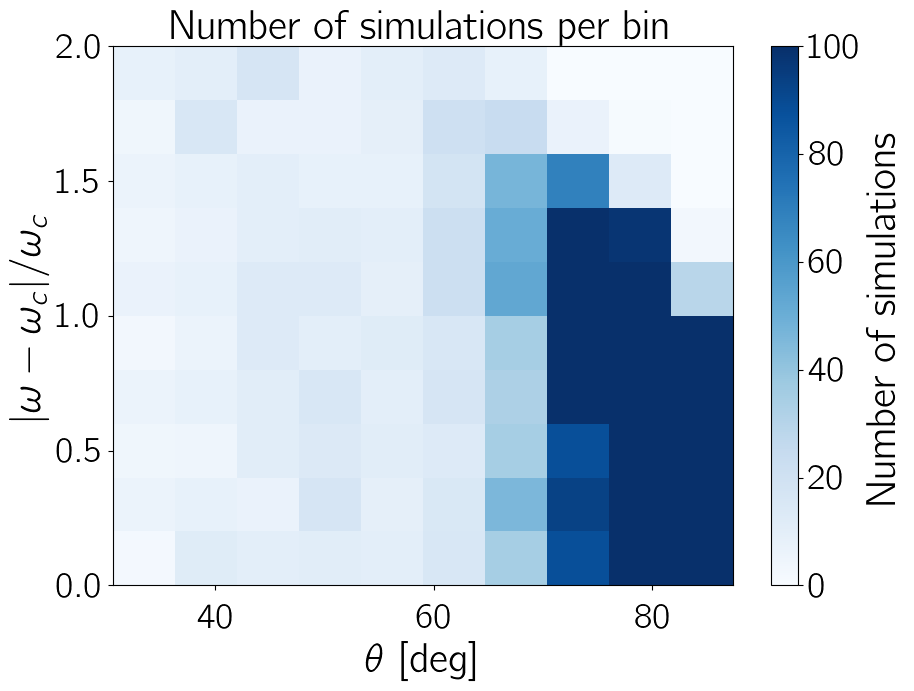

In [24]:
fig, ax = plt.subplots()
ax.grid(False)

hist = ax.pcolormesh(zenith_grid,omega_grid,sim_counts_per_bin,cmap='Blues',vmin=0,vmax=100)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')
plt.colorbar(hist,label='Number of simulations')

ax.set_title('Number of simulations per bin')

plt.show()

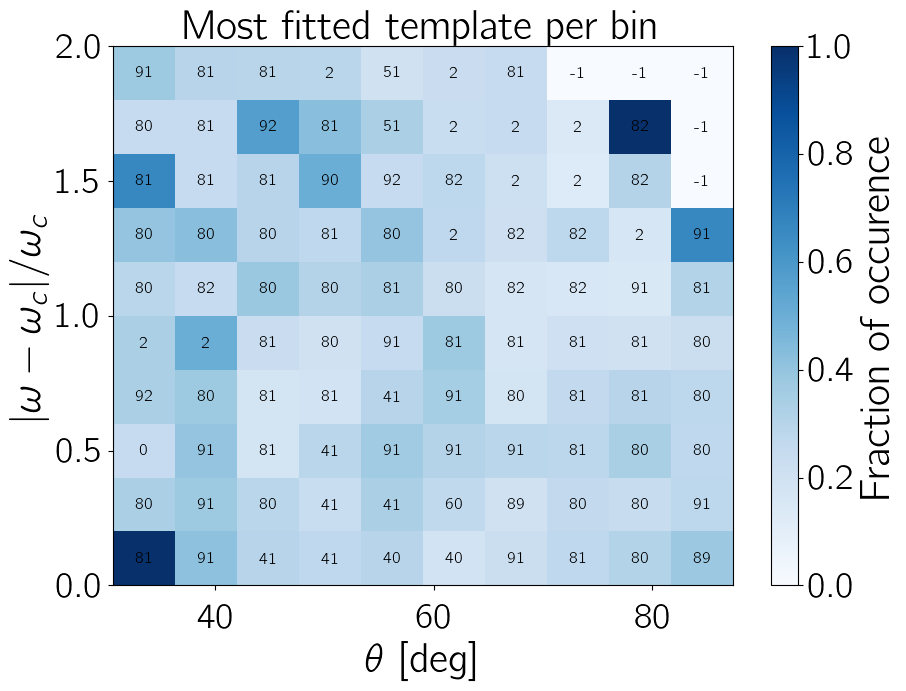

In [25]:
fig, ax = plt.subplots()
ax.grid(False)

hist = ax.pcolormesh(zenith_grid,omega_grid,fraction_best_template_per_bin,cmap='Blues',vmin=0)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')
plt.colorbar(hist,label='Fraction of occurence')

for i, bin_zenith in enumerate(bin_centers_zenith):
    for j, bin_omega in enumerate(bin_centers_omega):
        ax.text(bin_zenith,bin_omega,f'{best_template_per_bin[i,j]:.0f}',fontsize=12,va='center',ha='center')

ax.set_title('Most fitted template per bin')

plt.show()

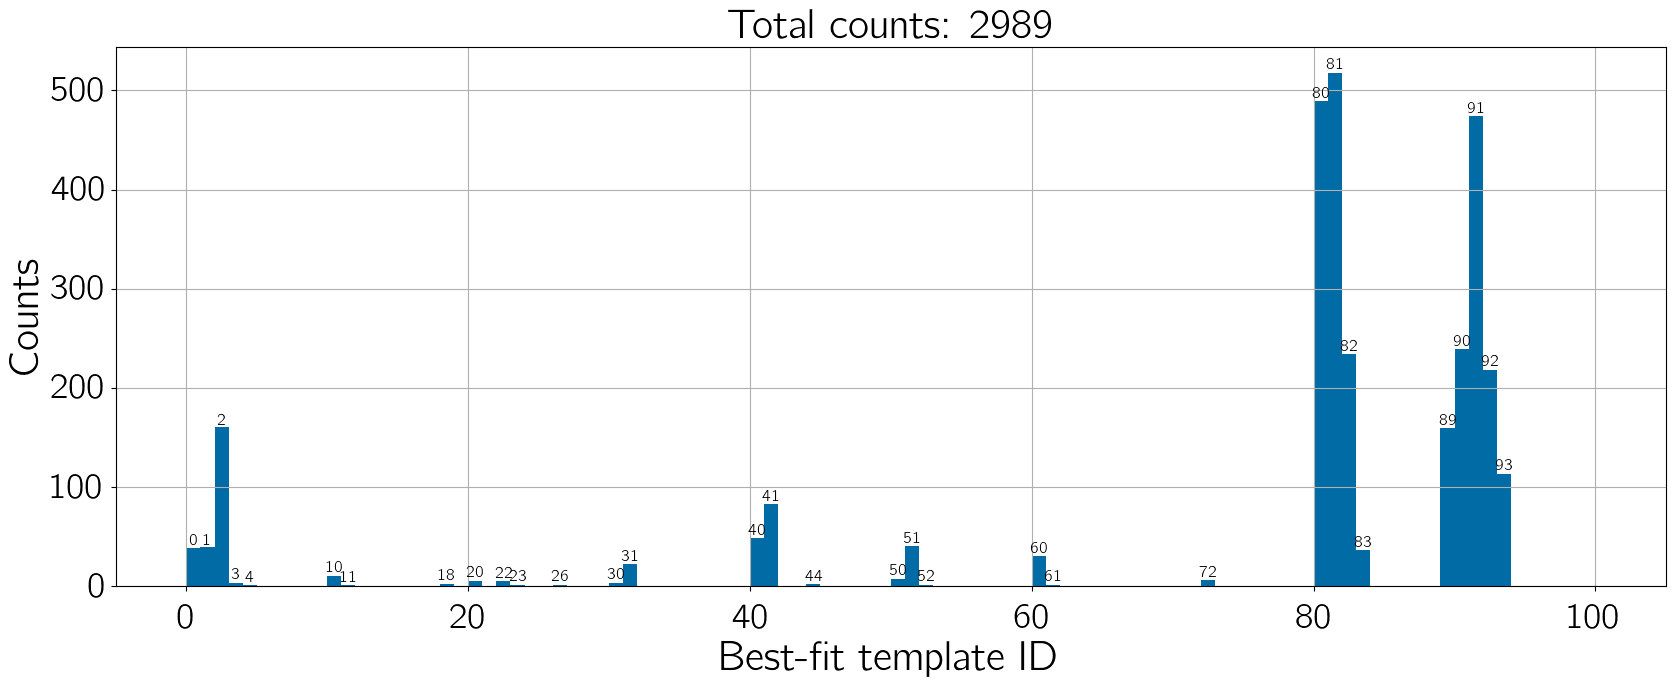

In [26]:
#weights = np.where(counts_best_template_per_bin>0,1/counts_best_template_per_bin,0)

fig, ax = plt.subplots()
fig.set_size_inches(20,7)

hist = ax.hist(idx_template_best,bins=100,range=(0,100)) #weights=counts_best_template_per_bin.flatten(),

for id in np.arange(0,100):
    if hist[0][id] > 0:
        text = ax.text( (hist[1][id]+ hist[1][id+1])/2, hist[0][id], f'{hist[1][id]:.0f}', fontsize=12, ha='center', va='bottom')

ax.set_xlabel('Best-fit template ID')
ax.set_ylabel('Counts')

title = f'Total counts: {hist[0].sum():.0f}'
ax.set_title(title)

plt.show()

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


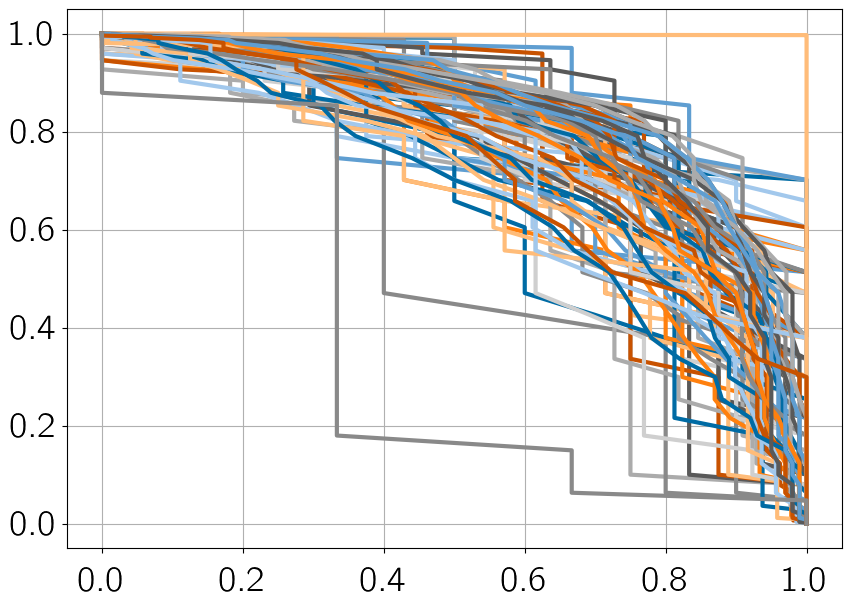

In [27]:
bkg_res_file  = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
bkg_res_file  = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_th1_55_th2_35_train_seed_300_{param_str}.npz' # 1 kHz
bkg_results   = tools.load_results(bkg_res_file,n_pol)

corr_thresh = np.arange(0,1,.01)

bkg_sel_eff = tools.get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
bkg_rej_eff = 1 - bkg_sel_eff

bkg_rej_eff_for_sig_sel_eff_90 = np.zeros((n_bins_zenith,n_bins_omega))

for i in range(n_bins_zenith):
    for j in range(n_bins_omega):
        mask_bin = np.where(np.logical_and( np.logical_and( zenith>=bin_edges_zenith[i],zenith<bin_edges_zenith[i+1] ),
                                            np.logical_and( omega_diff>=bin_edges_omega[j],omega_diff<bin_edges_omega[j+1] ) ),
                            True,
                            False)
        sig_sel_eff = tools.get_selection_efficiency(bias_results['corr_max'][mask_bin],corr_thresh)
        thresh = np.where(sig_sel_eff<.9)[0]

        if np.any(thresh):
            bkg_rej_eff_for_sig_sel_eff_90[i,j] = bkg_rej_eff[thresh[0]]

        plt.plot(sig_sel_eff,bkg_rej_eff)

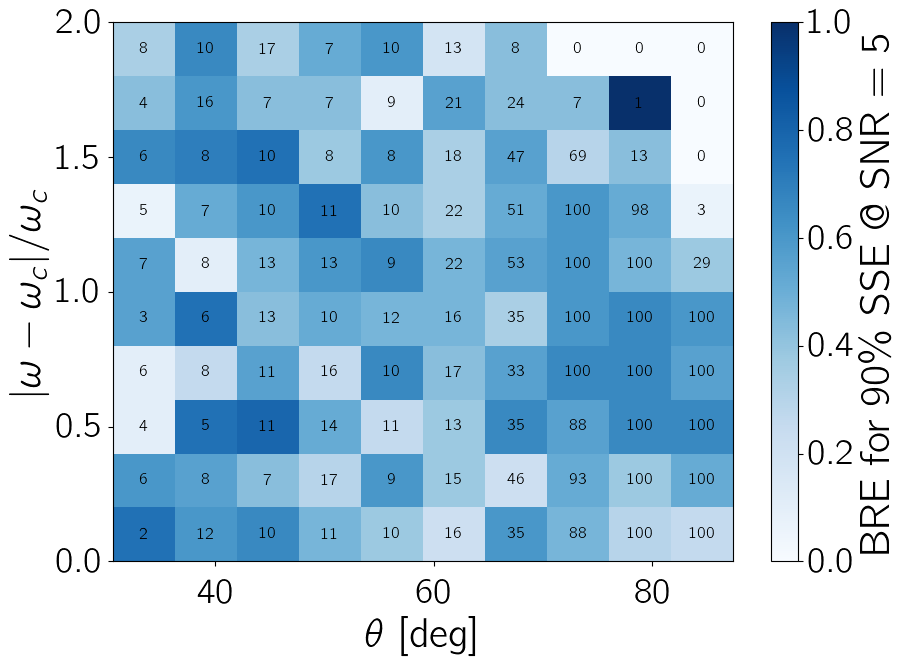

In [28]:
fig, ax = plt.subplots()
ax.grid(False)

hist = ax.pcolormesh(zenith_grid,omega_grid,bkg_rej_eff_for_sig_sel_eff_90,cmap='Blues',vmin=0,vmax=1)
cbar = plt.colorbar(hist,label='BRE for 90\% SSE @ SNR = 5')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')

for i, bin_zenith in enumerate(bin_centers_zenith):
    for j, bin_omega in enumerate(bin_centers_omega):
        ax.text(bin_zenith,bin_omega,f'{sim_counts_per_bin[i,j]:.0f}',fontsize=12,va='center',ha='center')
        
plt.show()

-0.20483078019237622
-0.21343890274314212


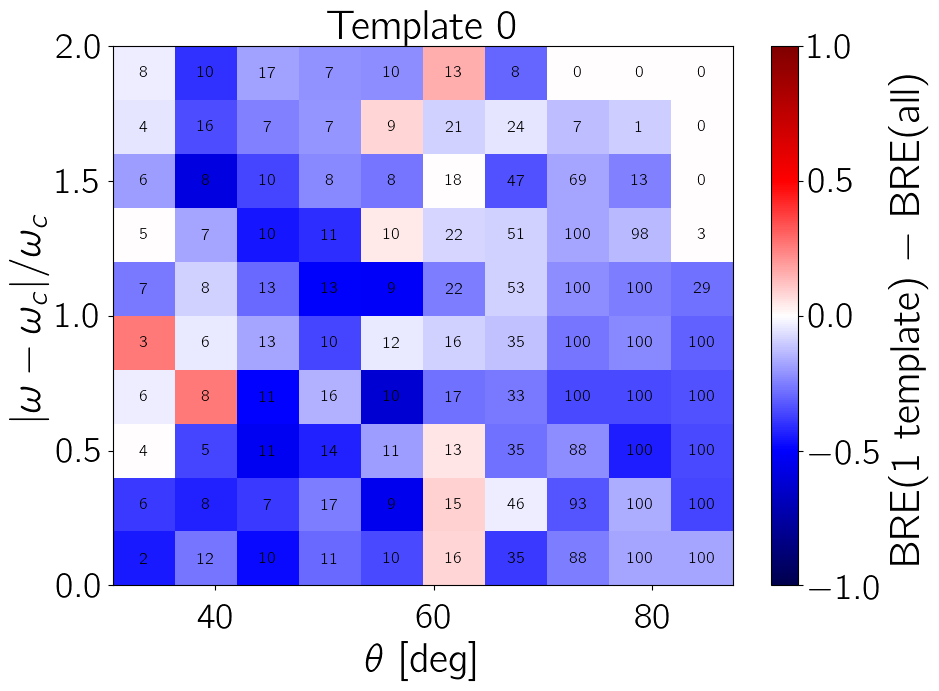

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.21828286426790172
-0.2357780548628429


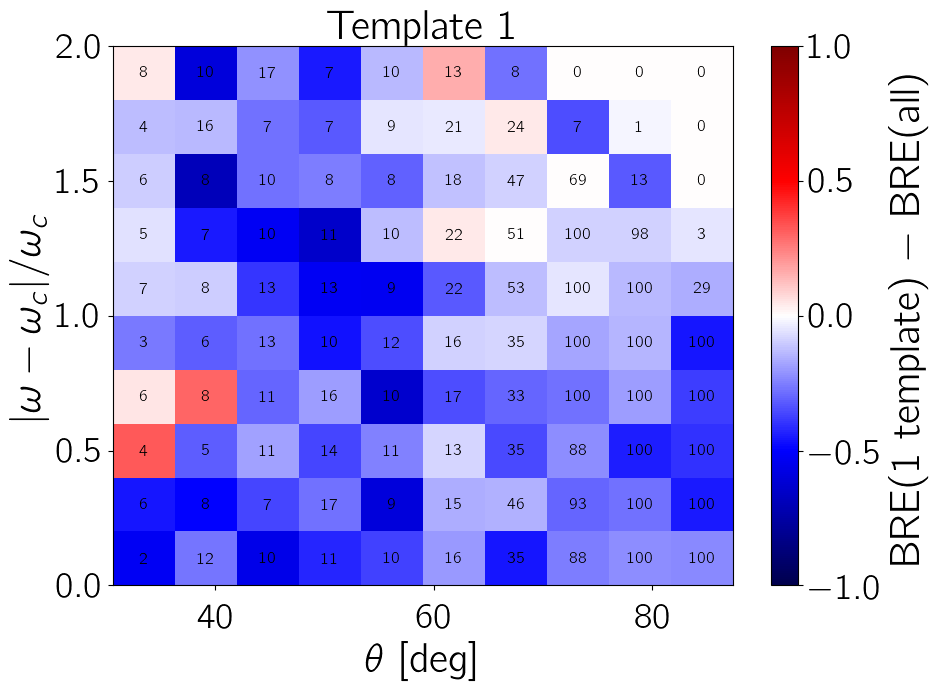

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.18768079800498755
-0.1996059850374065


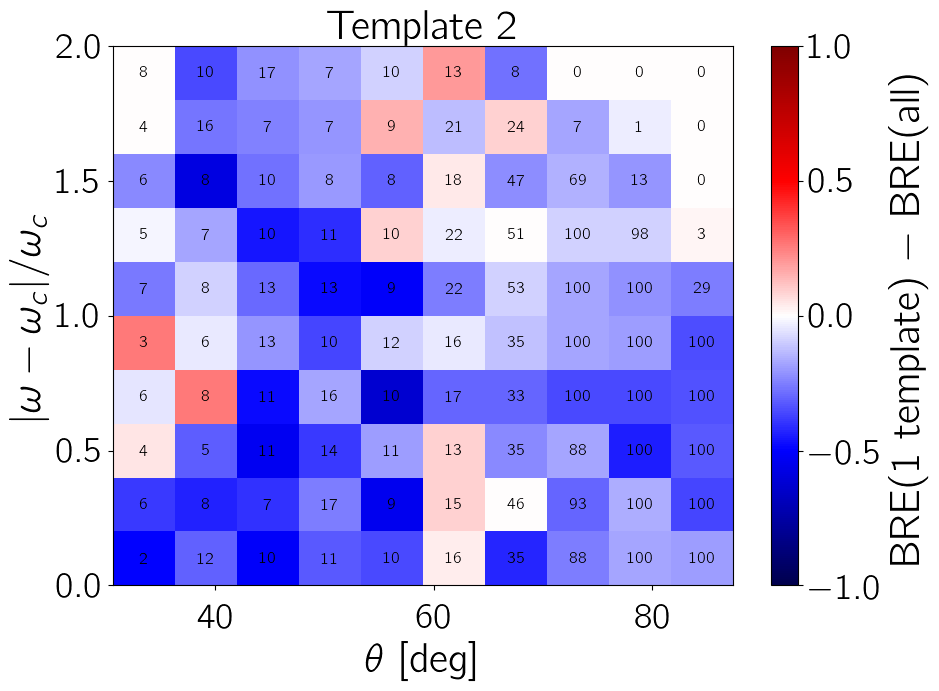

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.13833986462415393
-0.1234488778054863


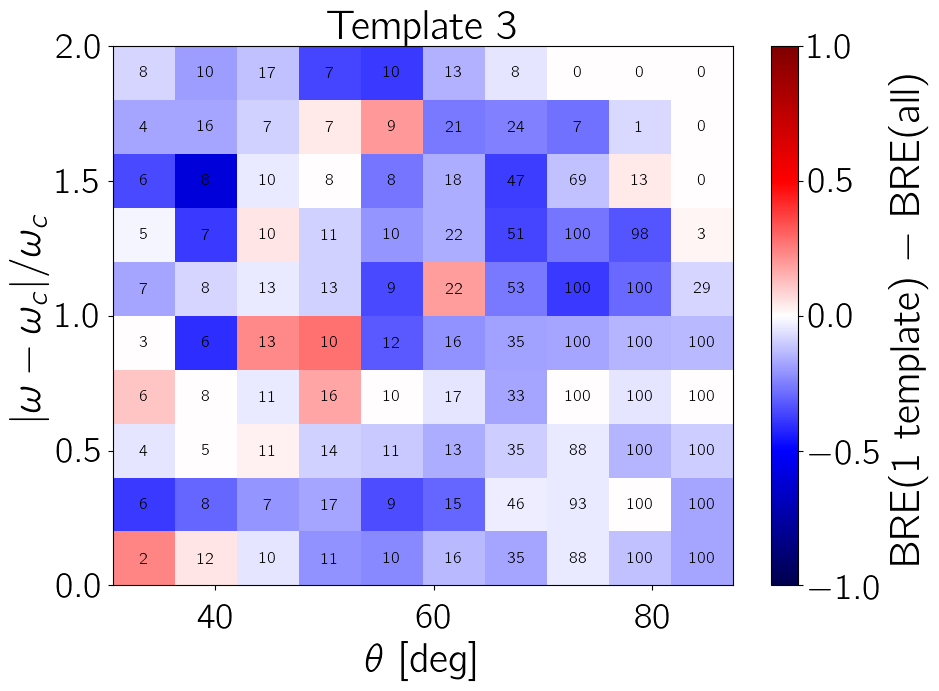

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.11127182044887782
-0.1405062344139651


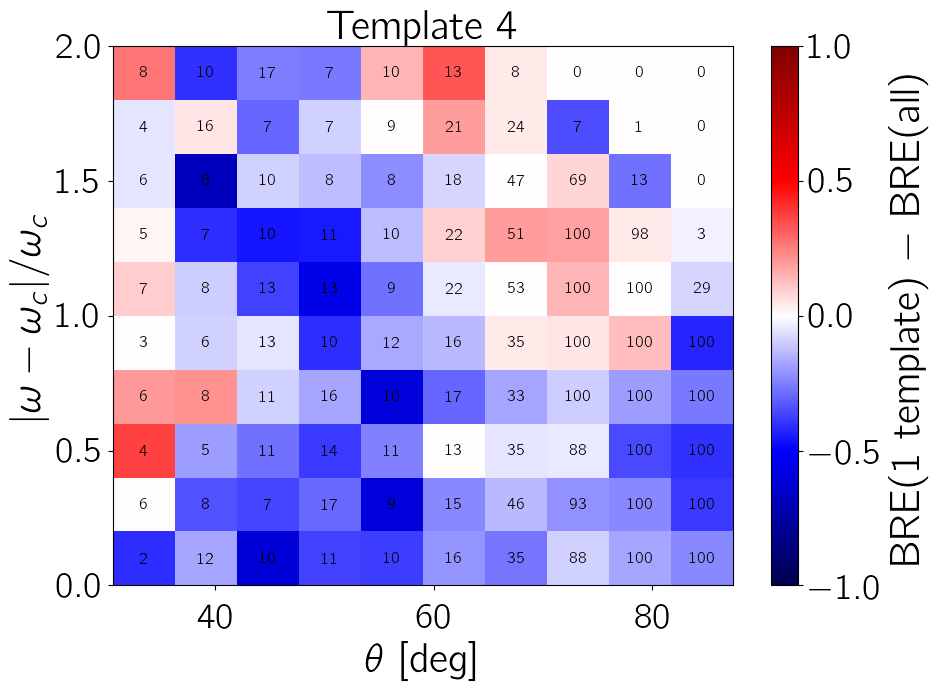

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.016950480940505885
-0.049890274314214465


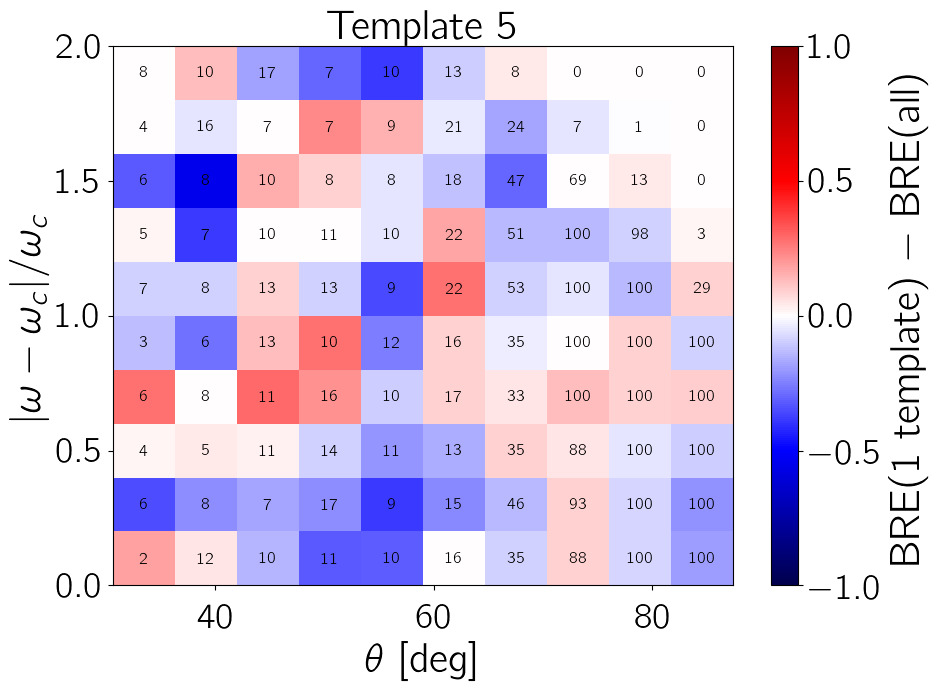

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.0005628785179907471
-0.03003990024937657


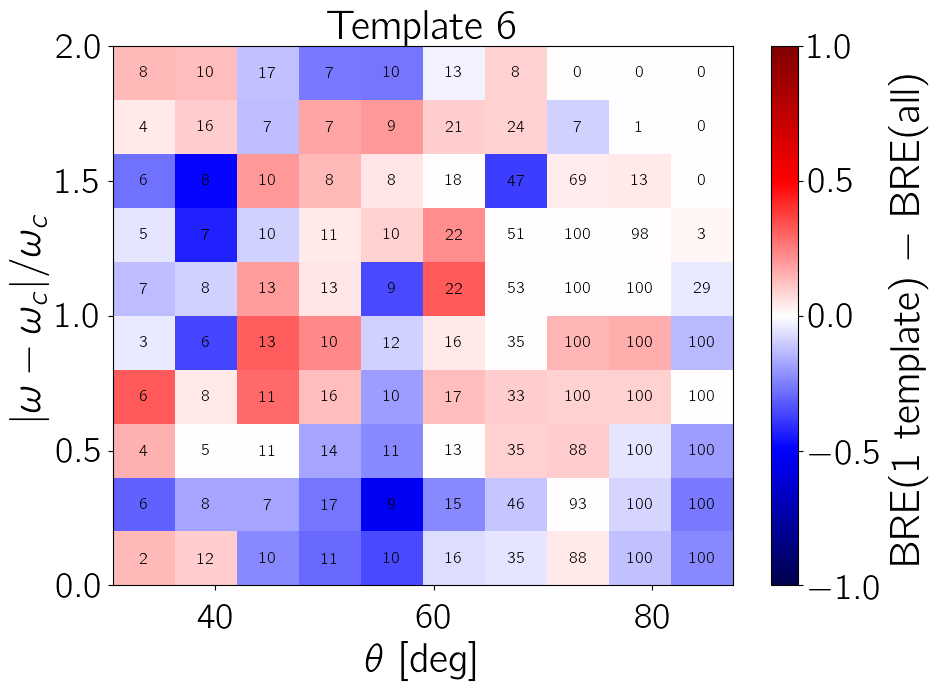

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.011414321339508378
-0.06300249376558603


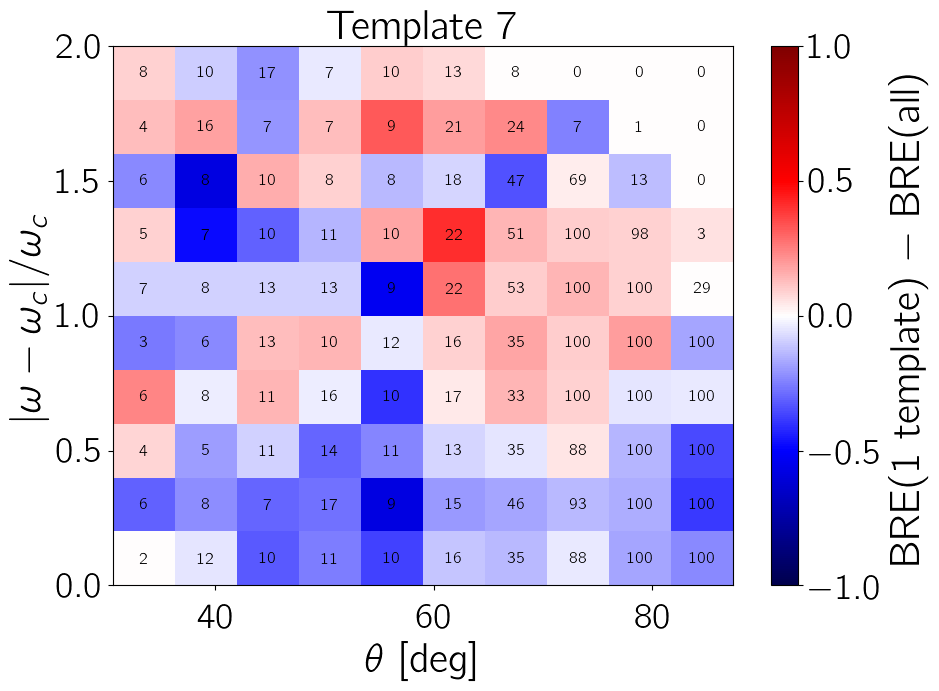

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.2104096900605629
-0.23177306733167086


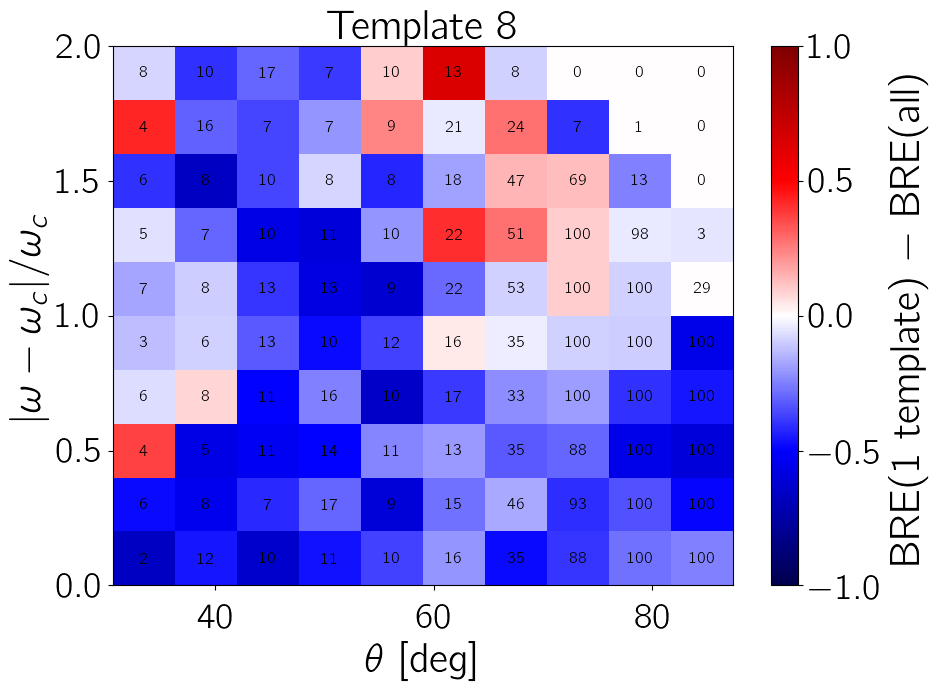

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.10671891699323123
-0.15123690773067333


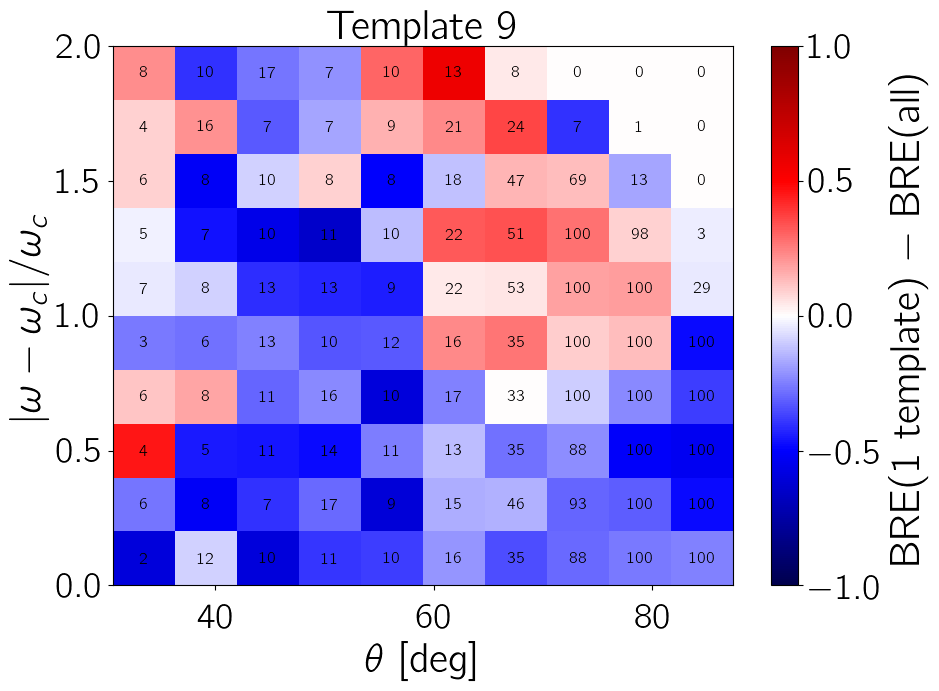

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.16944068400427503
-0.18717955112219453


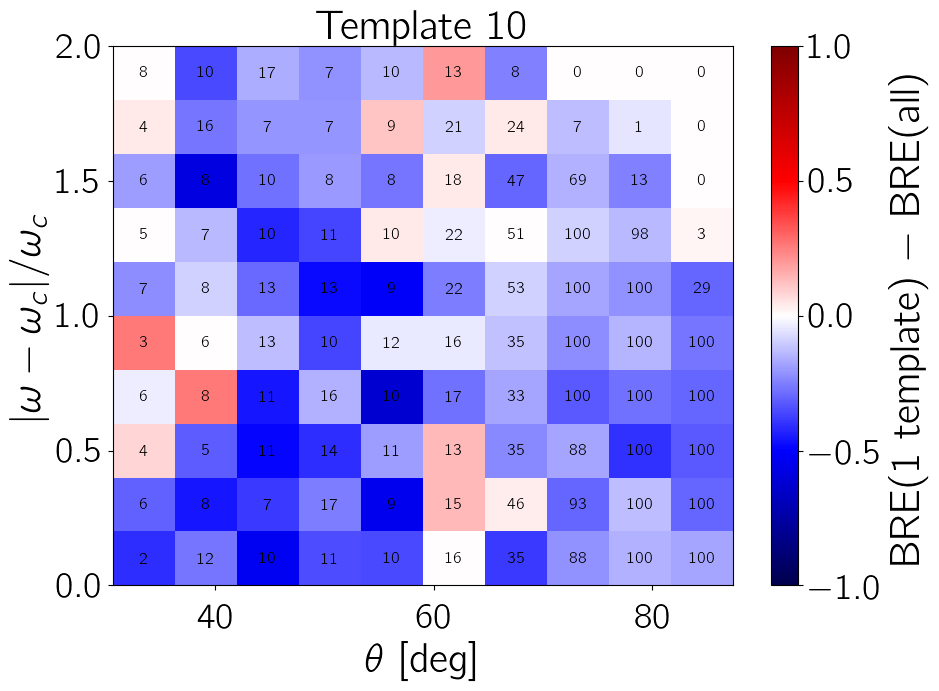

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.1518988243676523
-0.13685536159600997


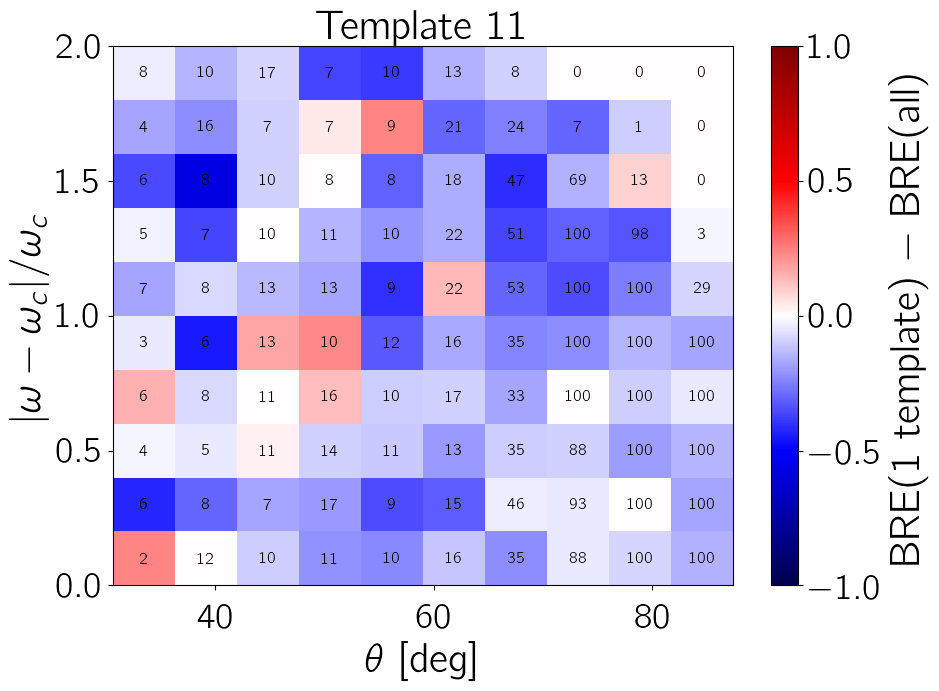

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.09445671535447096
-0.13623192019950126


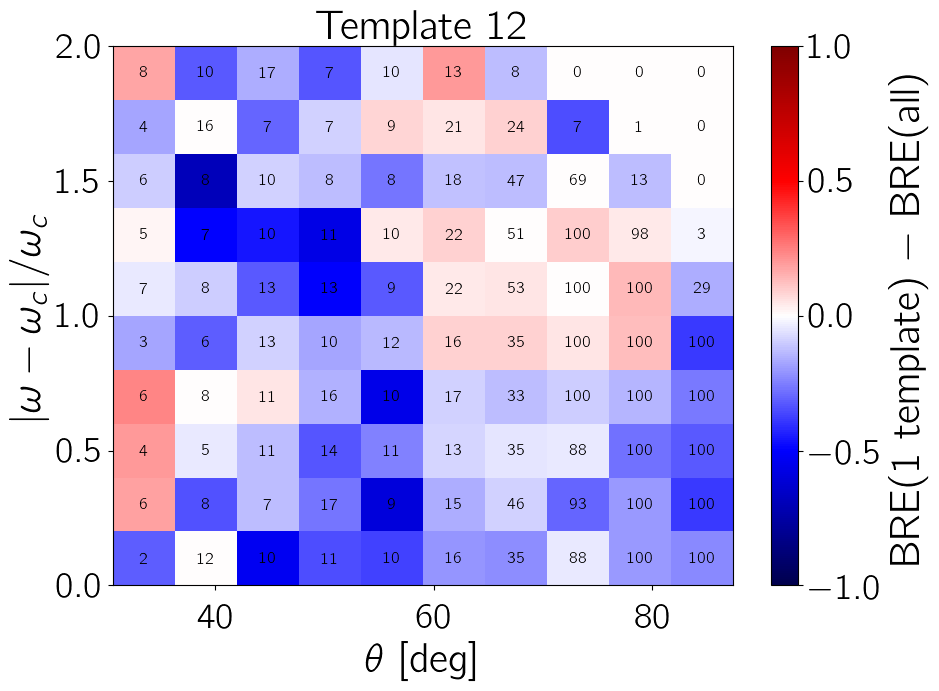

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.0564018525115782
-0.0859775561097257


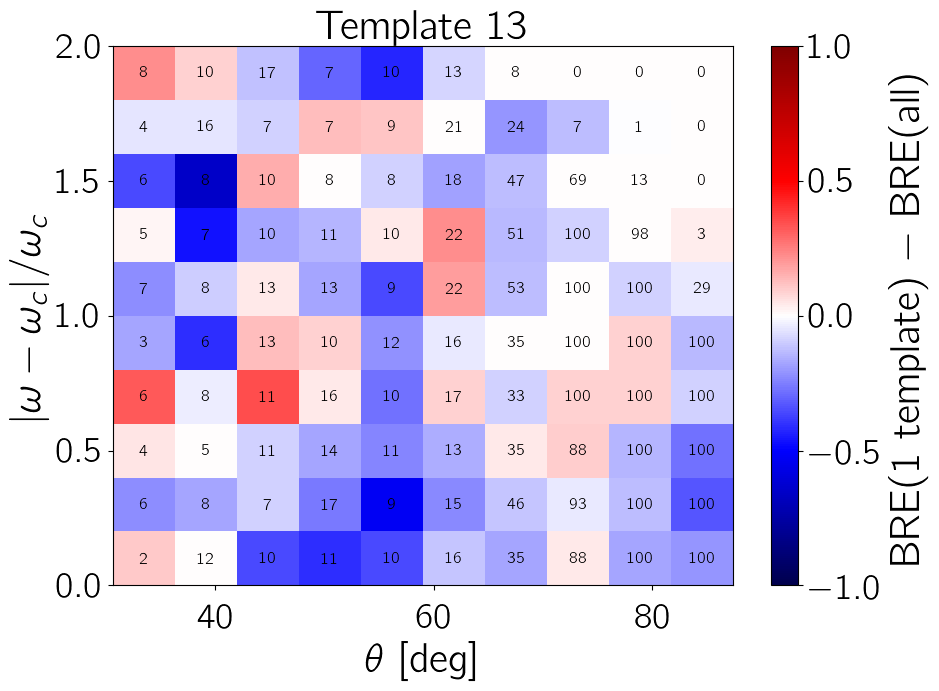

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.008257926612041335
-0.04627680798004988


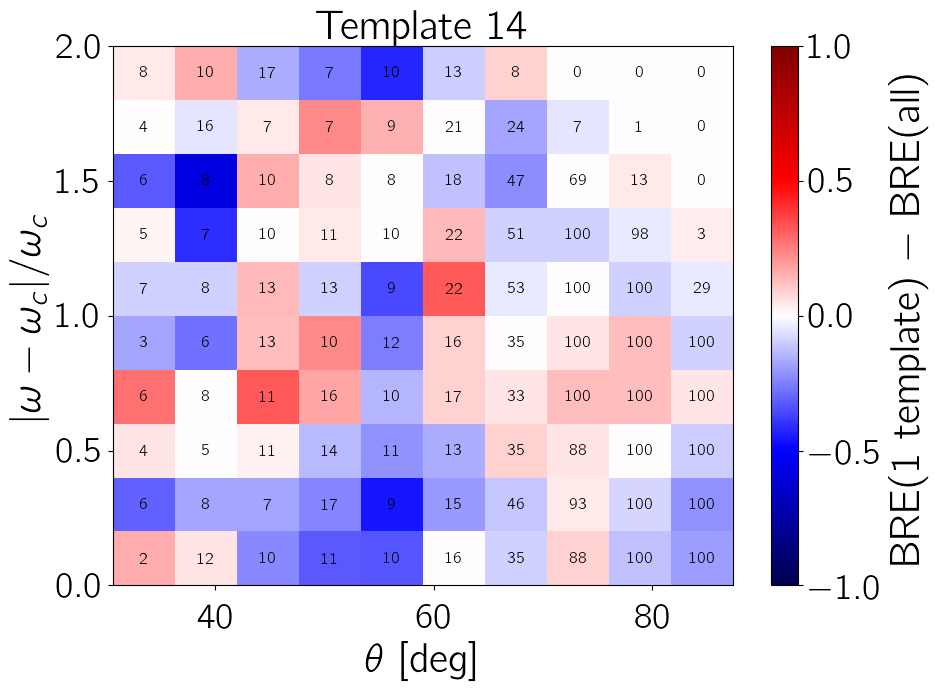

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.05591734948343428
-0.11523192019950124


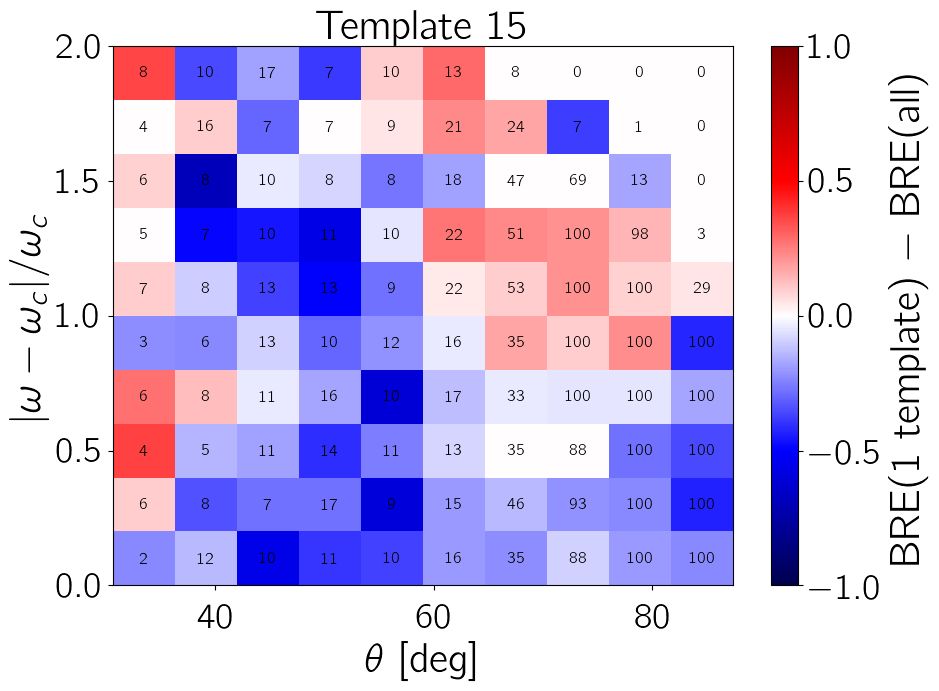

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.052597078731742054
0.0037107231920199446


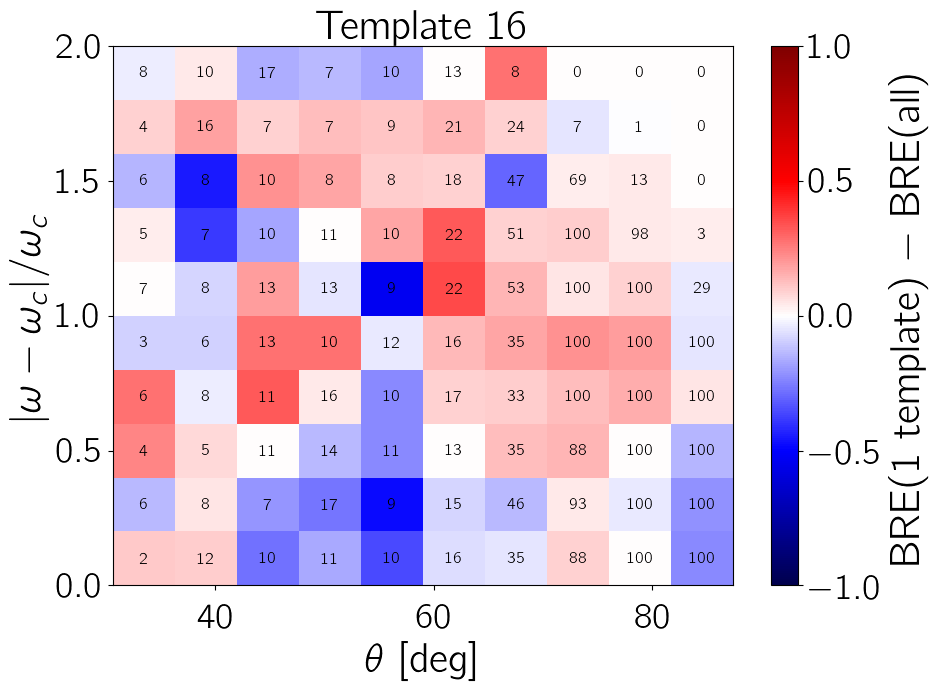

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.0443035268970431
-0.005441396508728182


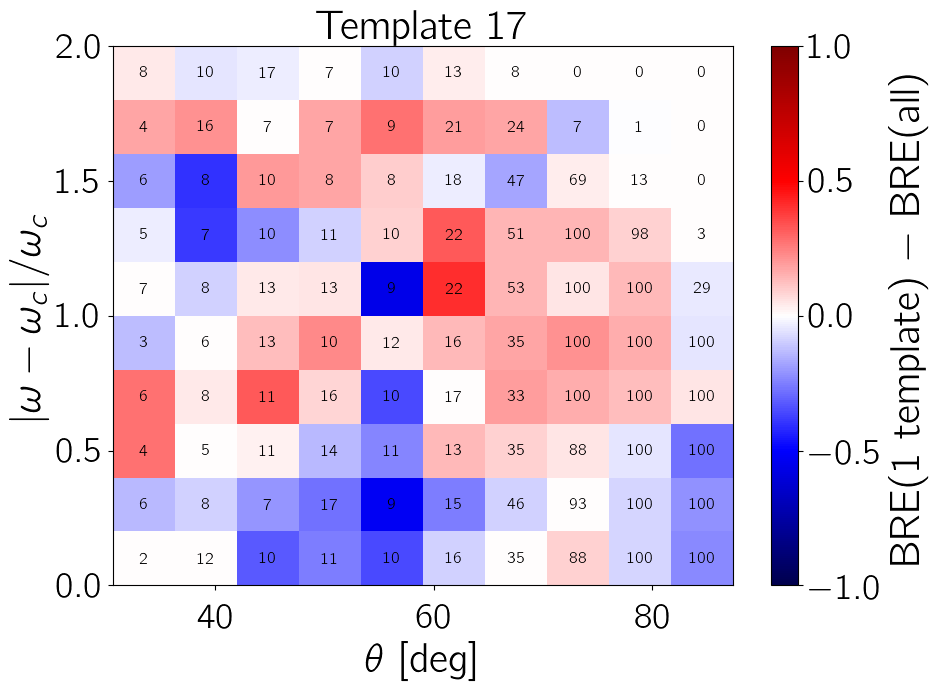

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.013865336658354122
-0.06658104738154616


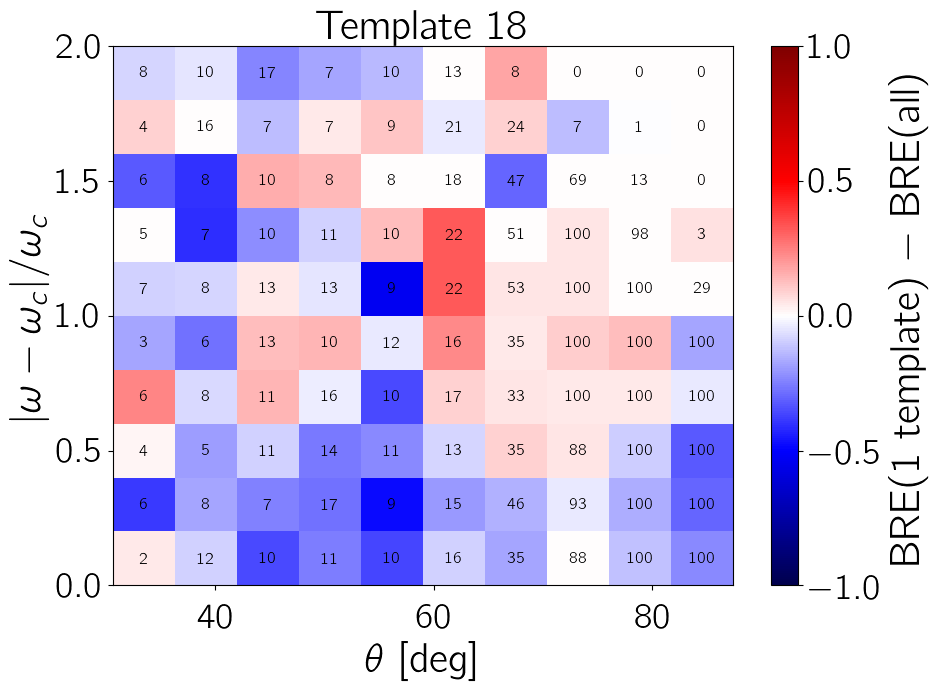

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.005336658354114695
-0.07043142144638405


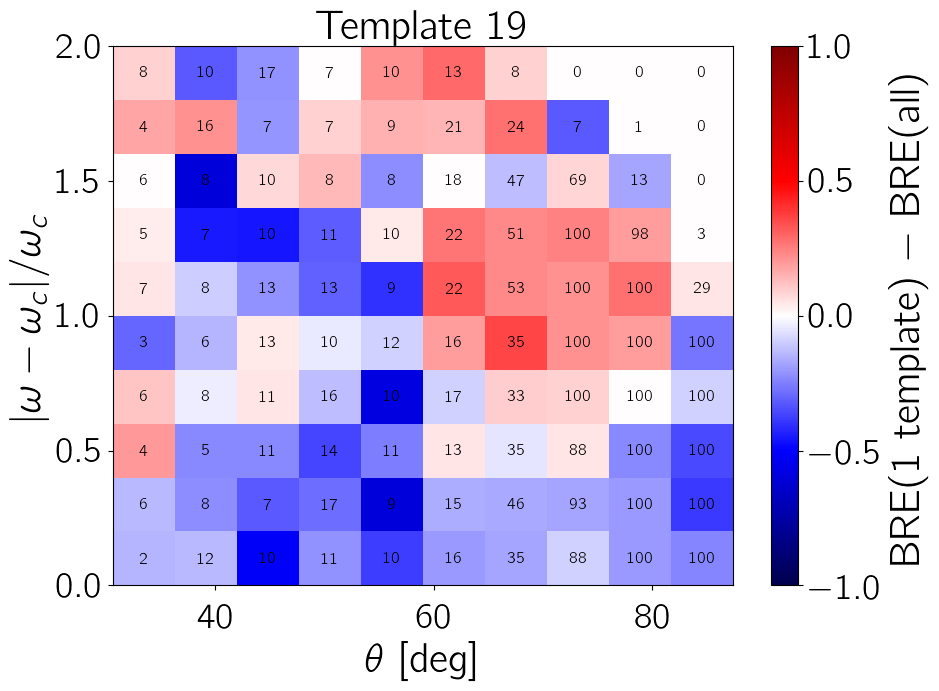

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.26301389383683654
-0.21518703241895262


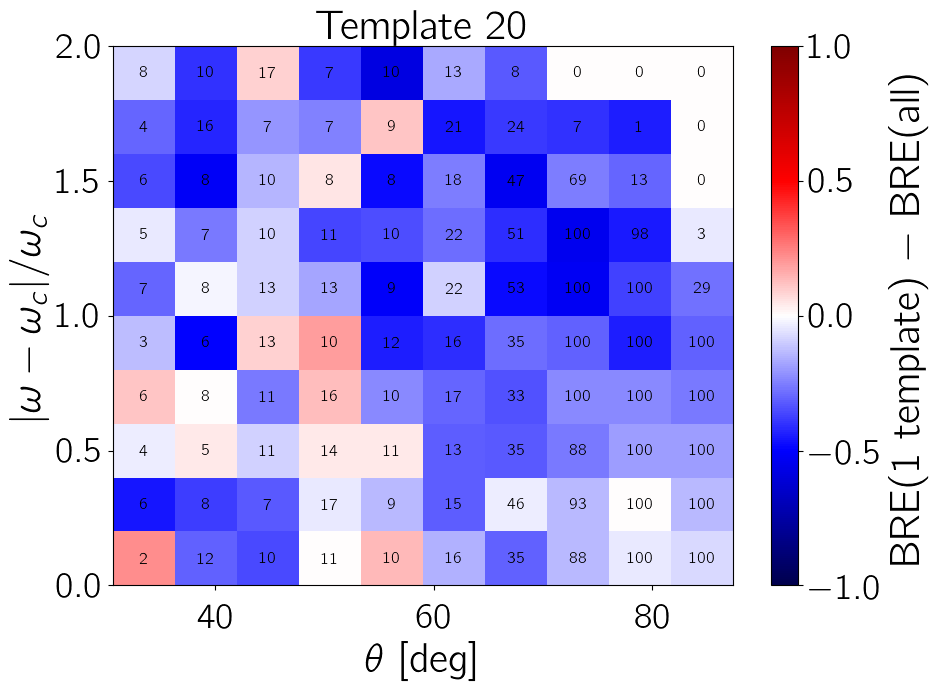

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.19970787317420732
-0.16795511221945136


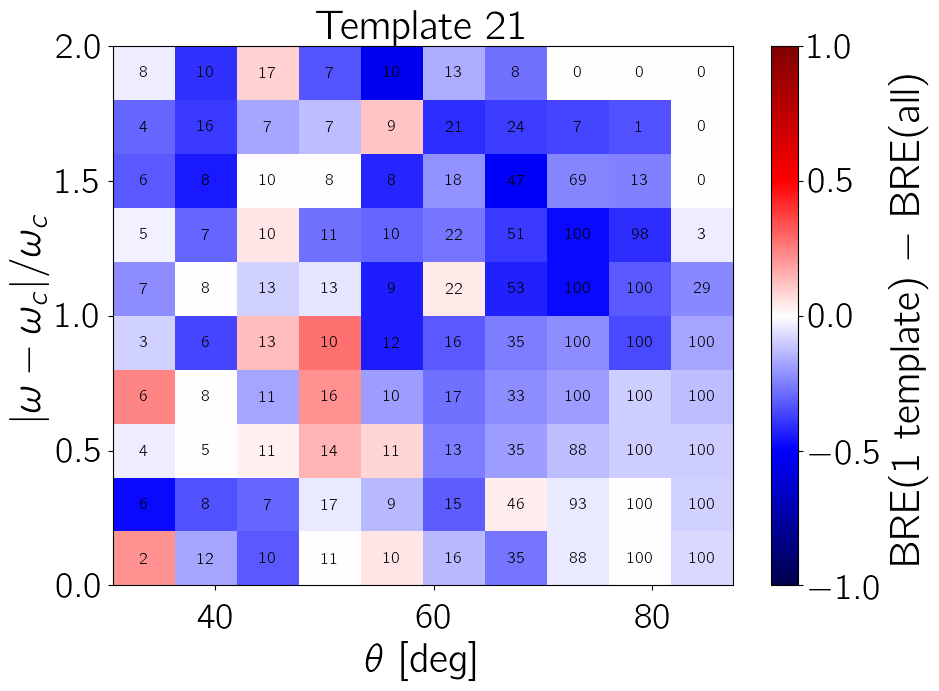

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3414036337727111
-0.2757780548628429


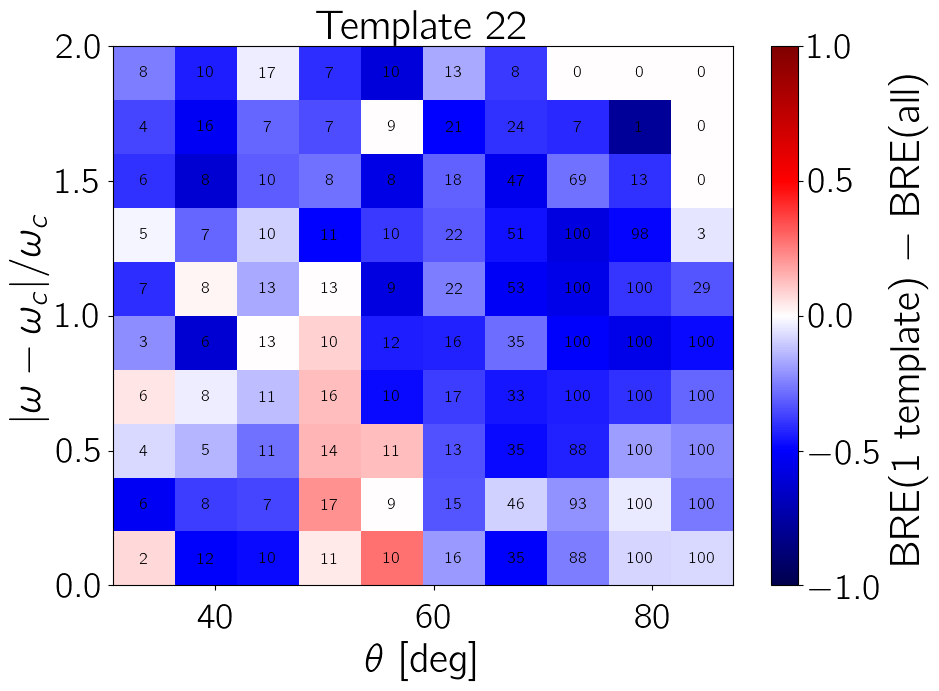

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.10380477377983614
-0.09418453865336658


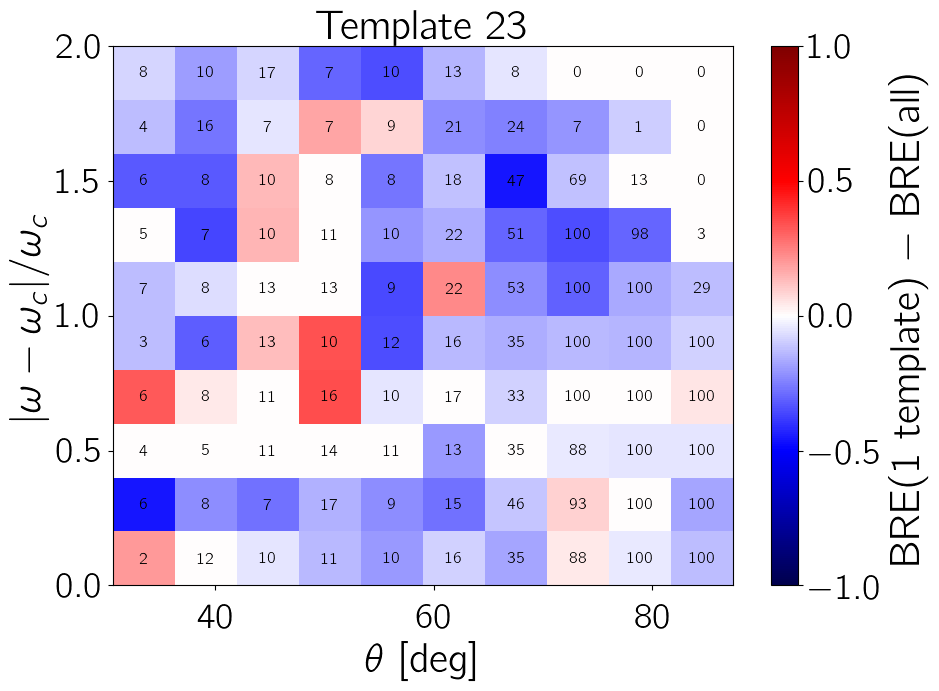

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3933095831848949
-0.3313017456359102


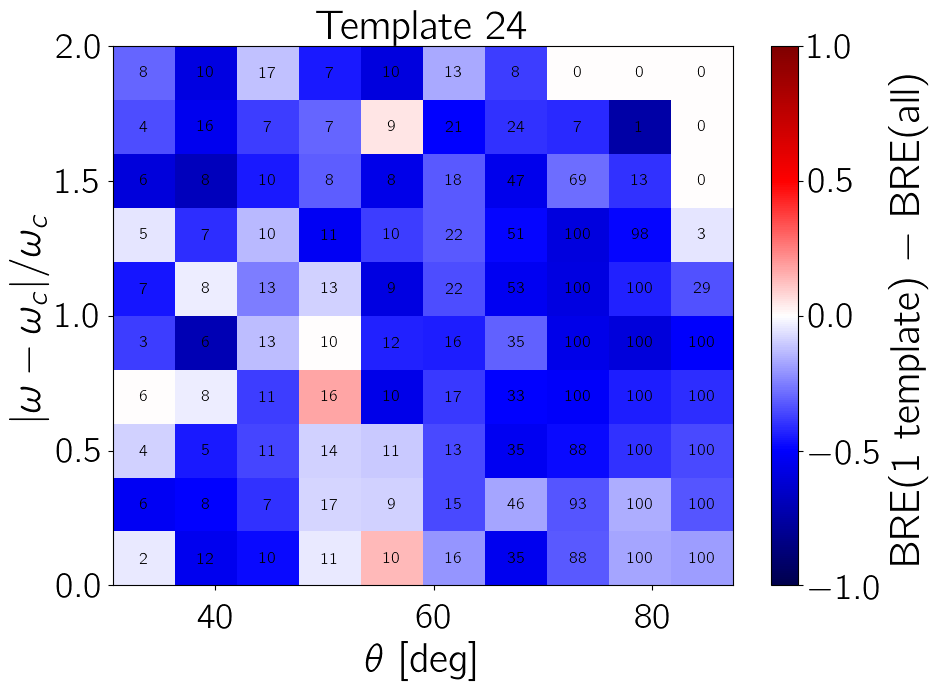

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.015781973637335224
-0.023872817955112223


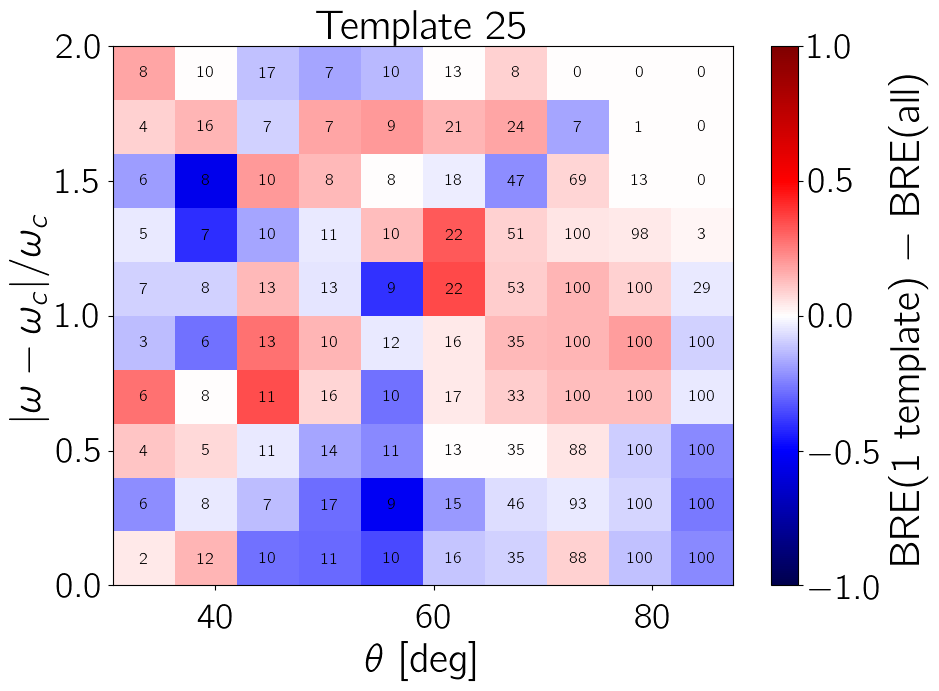

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.048136800855005345
-0.07416708229426434


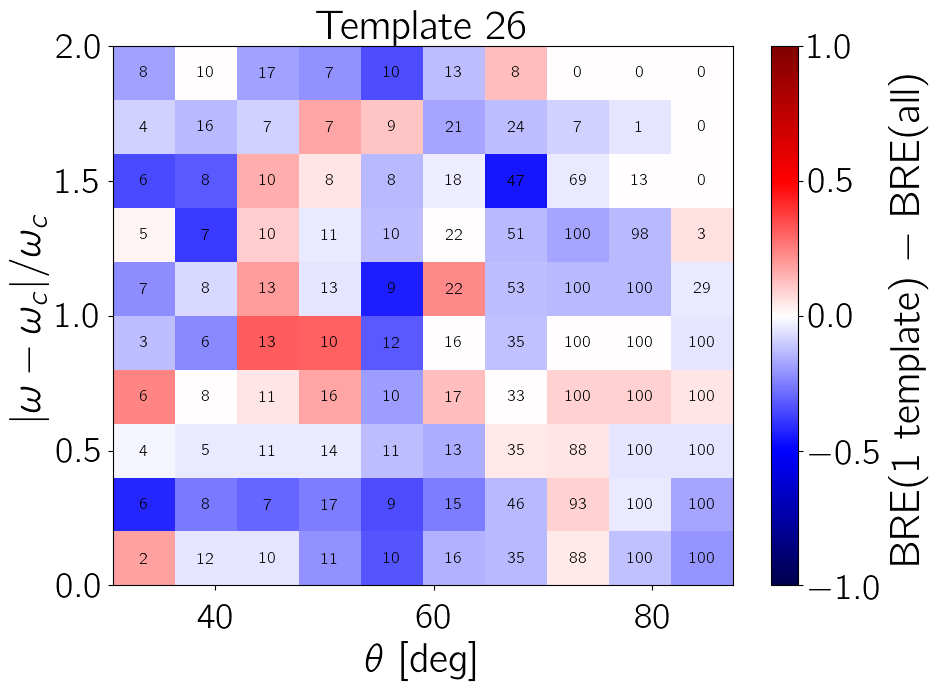

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4238332739579623
-0.38547880299251863


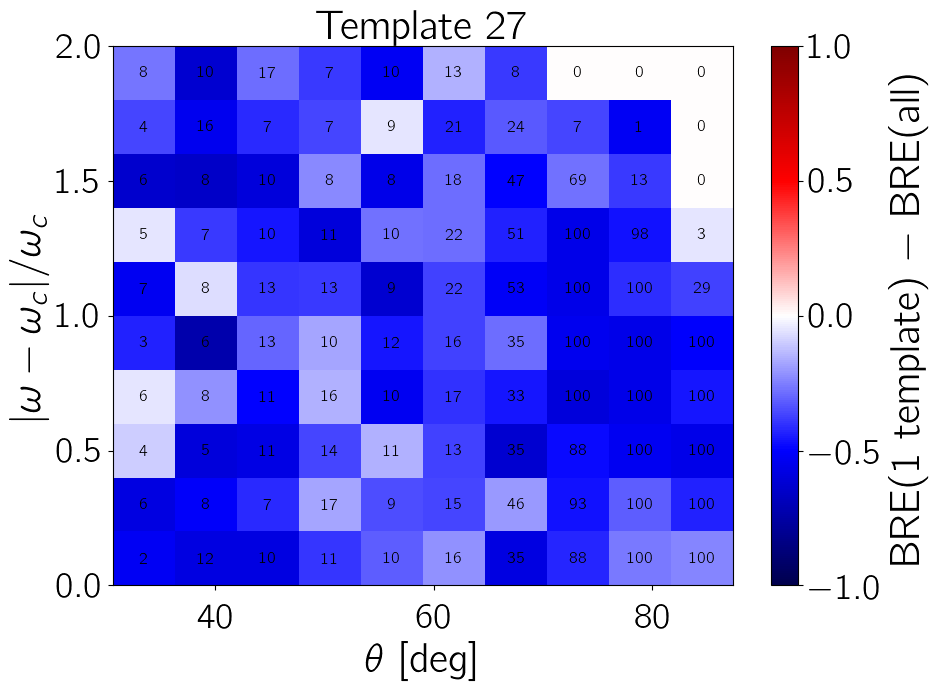

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.42085500534378334
-0.3945810473815461


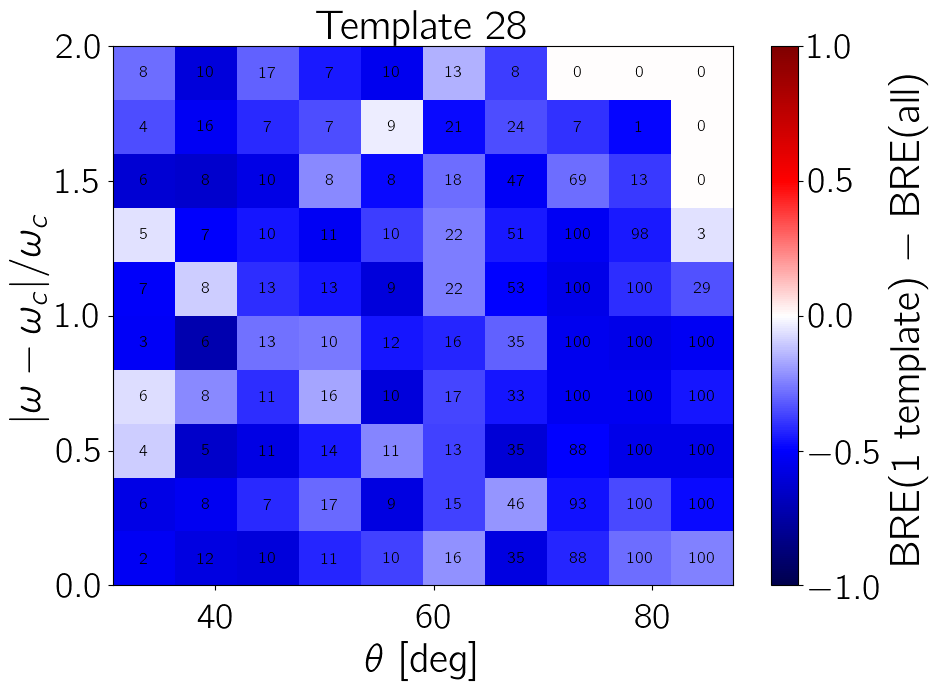

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.19502671891699325
-0.21591022443890273


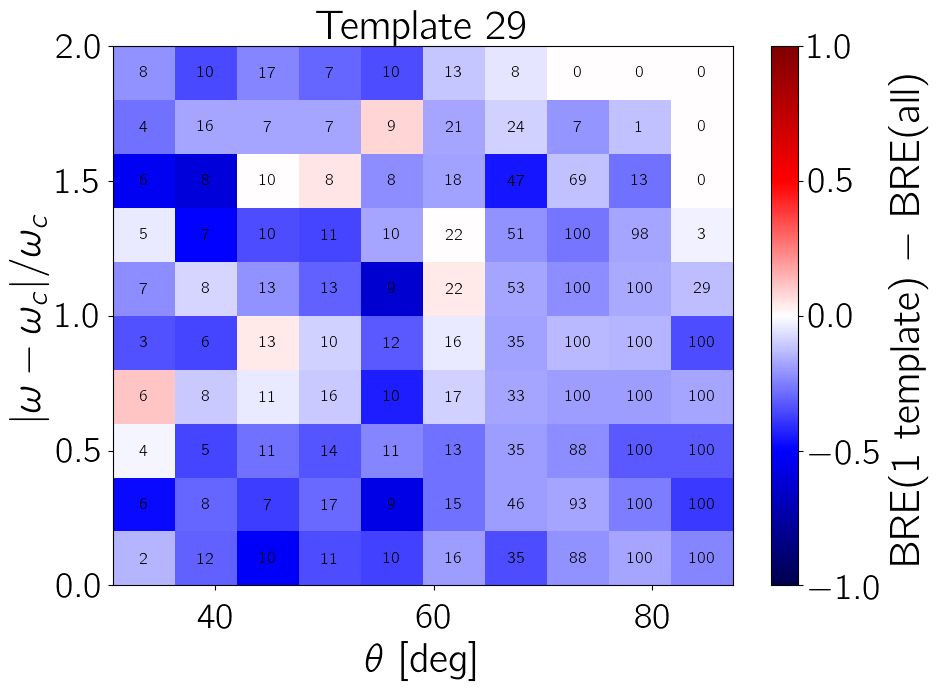

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.41429283933024585
-0.3578977556109726


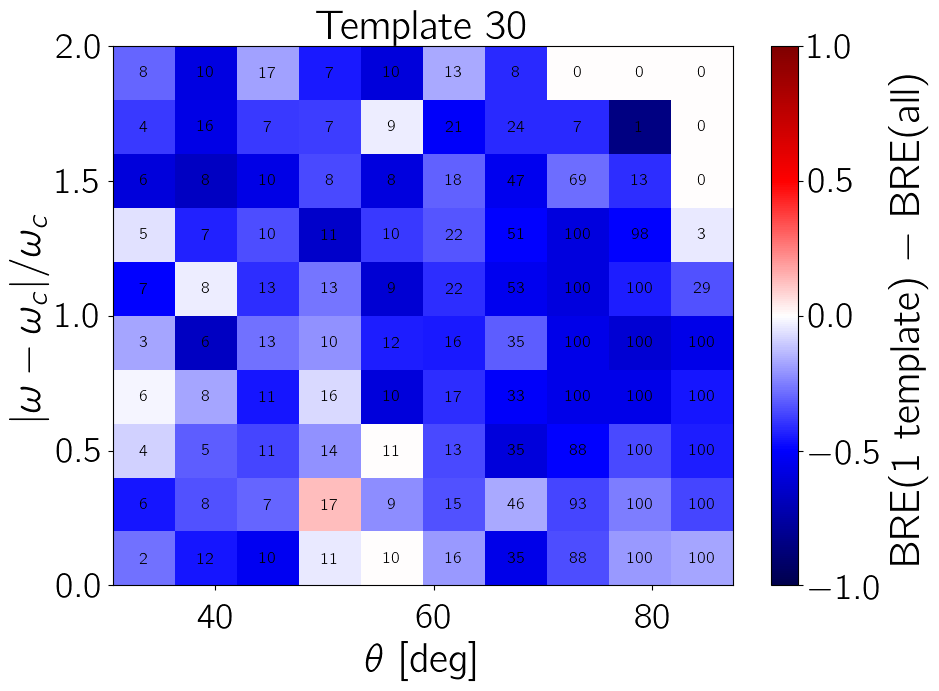

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.2427360171001069
-0.19334413965087283


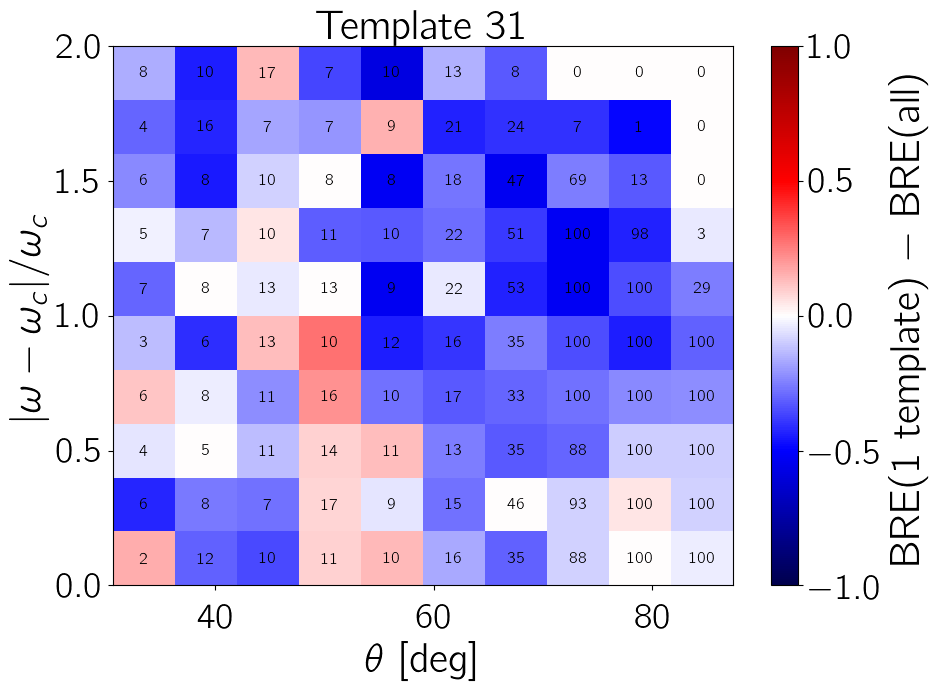

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.15291770573566082
-0.16460099750623441


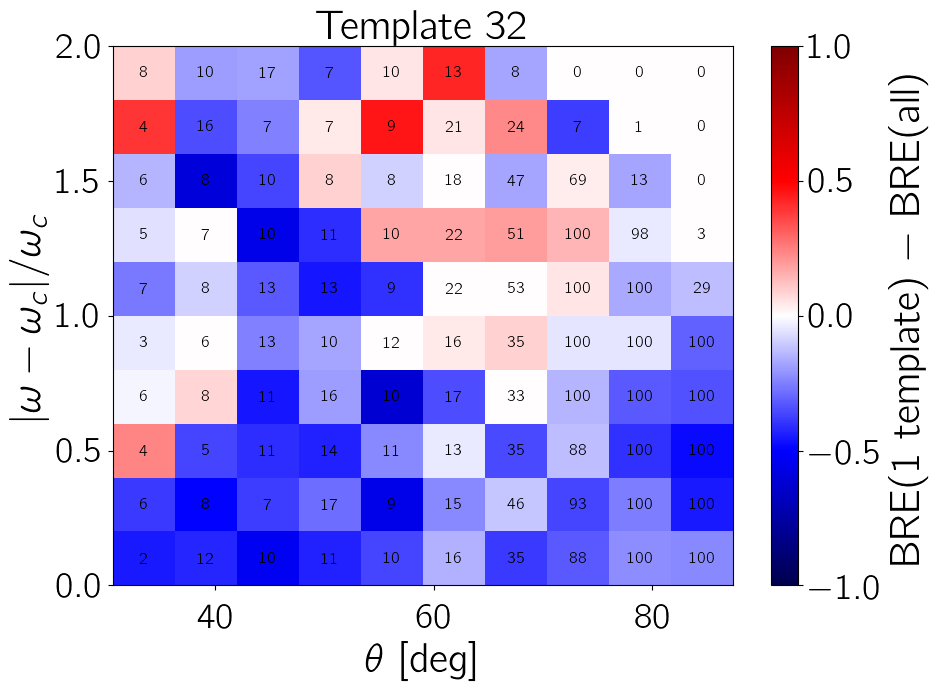

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.21258282864267902
-0.17494014962593518


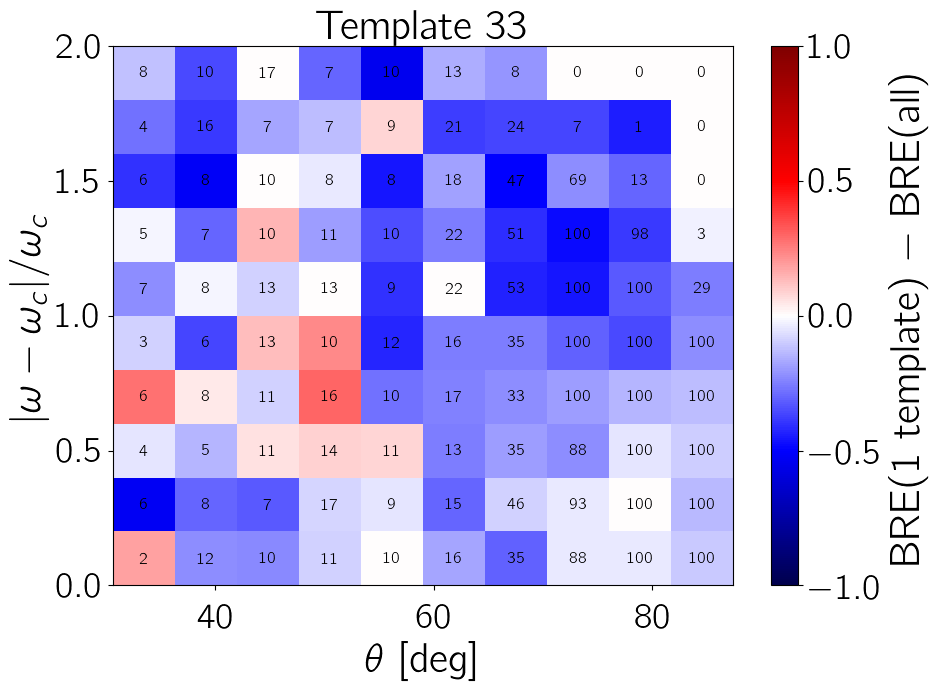

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.2337513359458497
-0.19385536159601


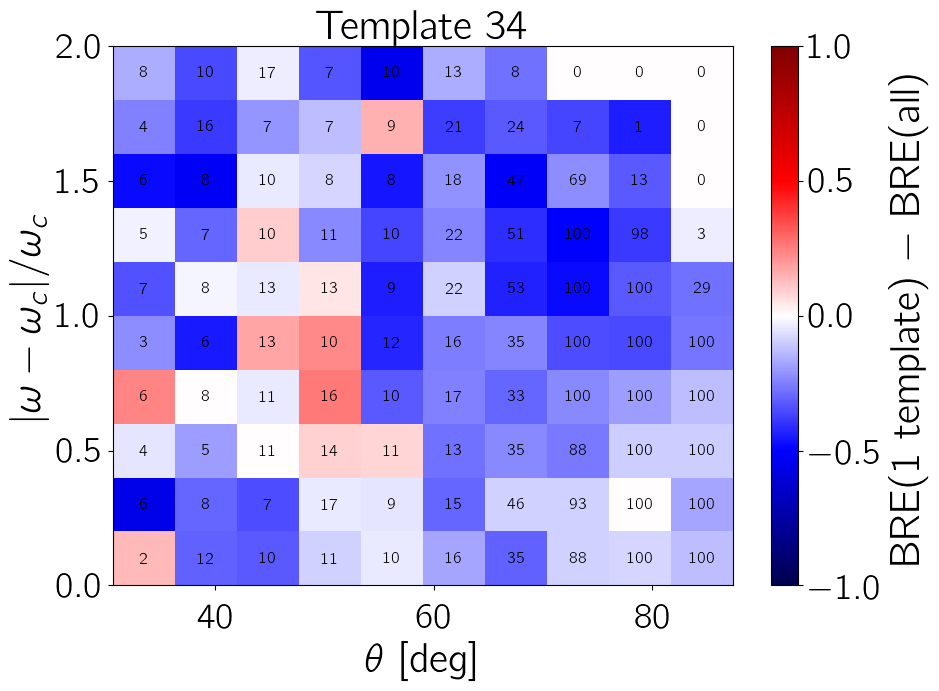

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.12621303883149274
-0.11299002493765586


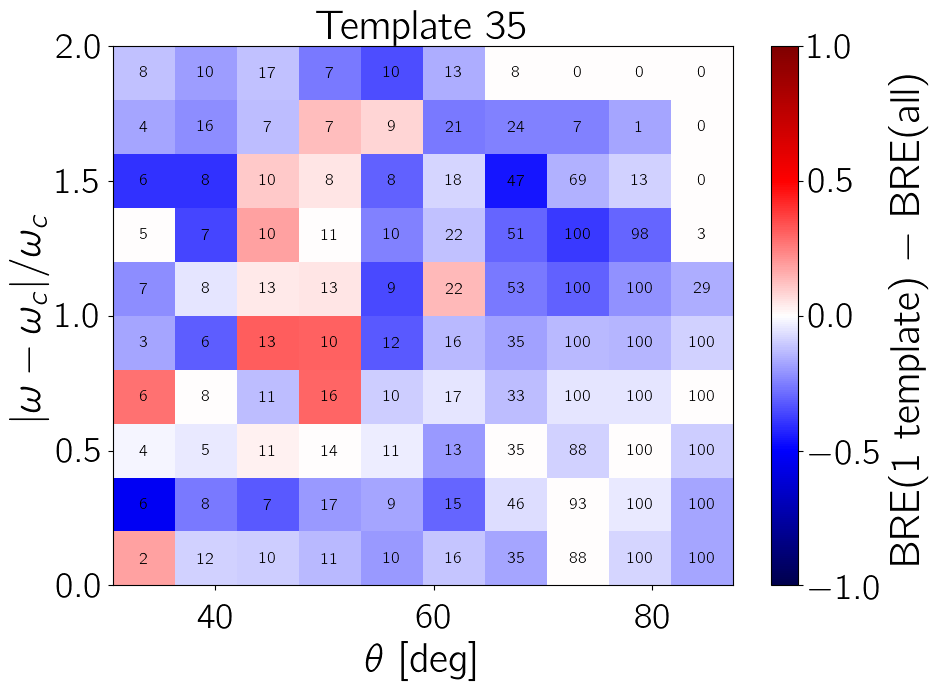

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4039543997149982
-0.3874887780548628


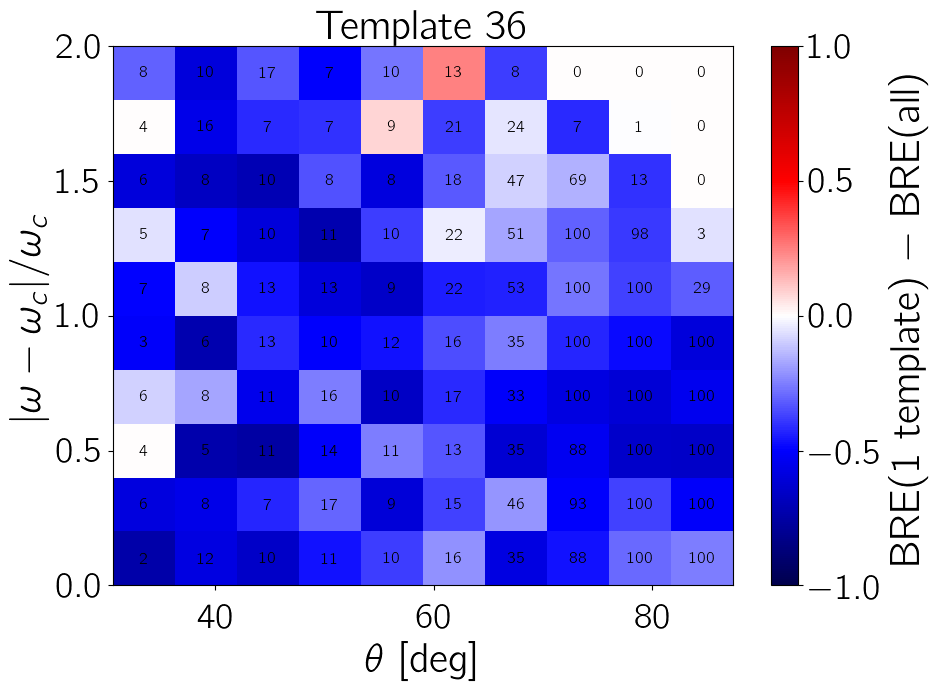

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.031321695760598484
-0.035157107231920205


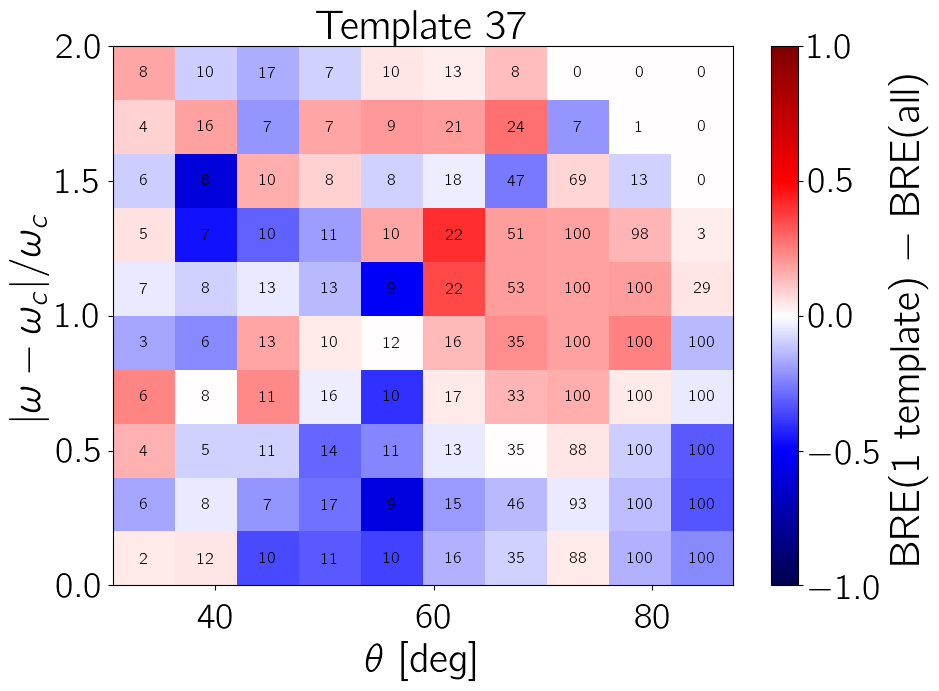

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4037833986462416
-0.3869725685785537


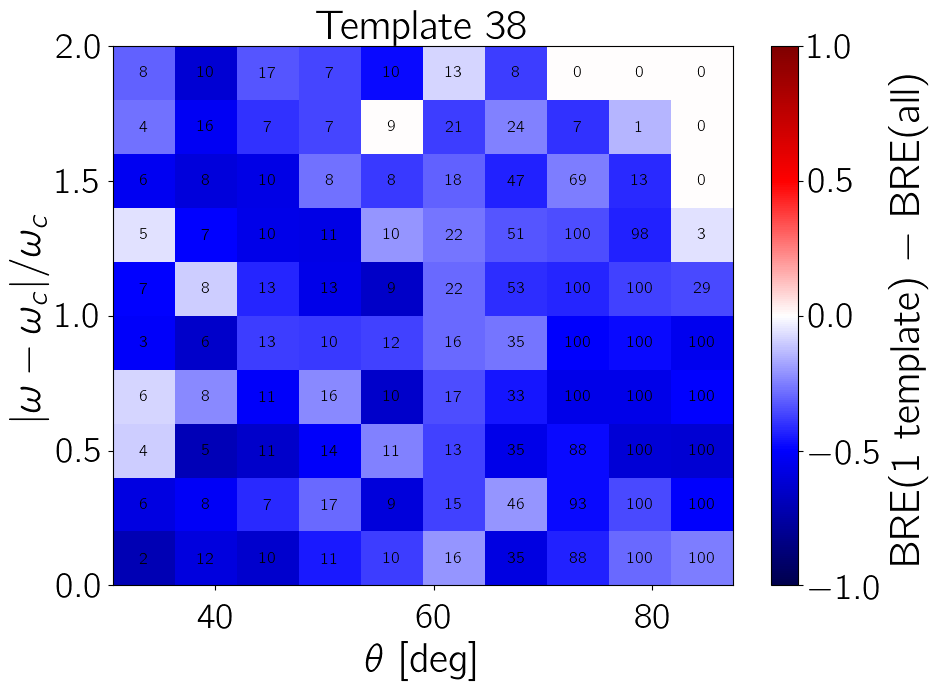

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4657071606697542
-0.4435087281795511


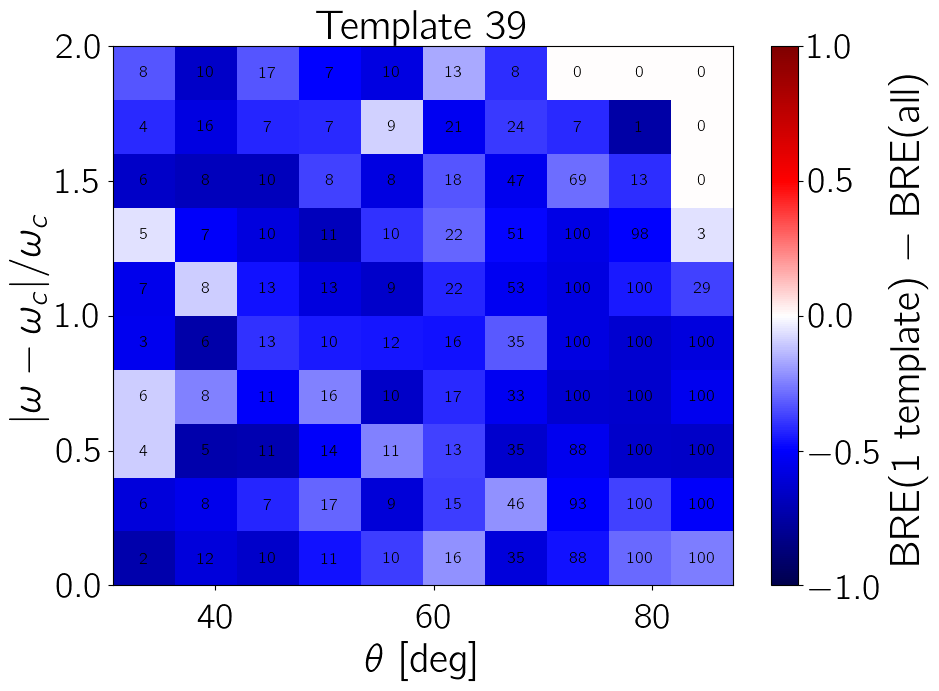

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4192019950124689
-0.36500498753117205


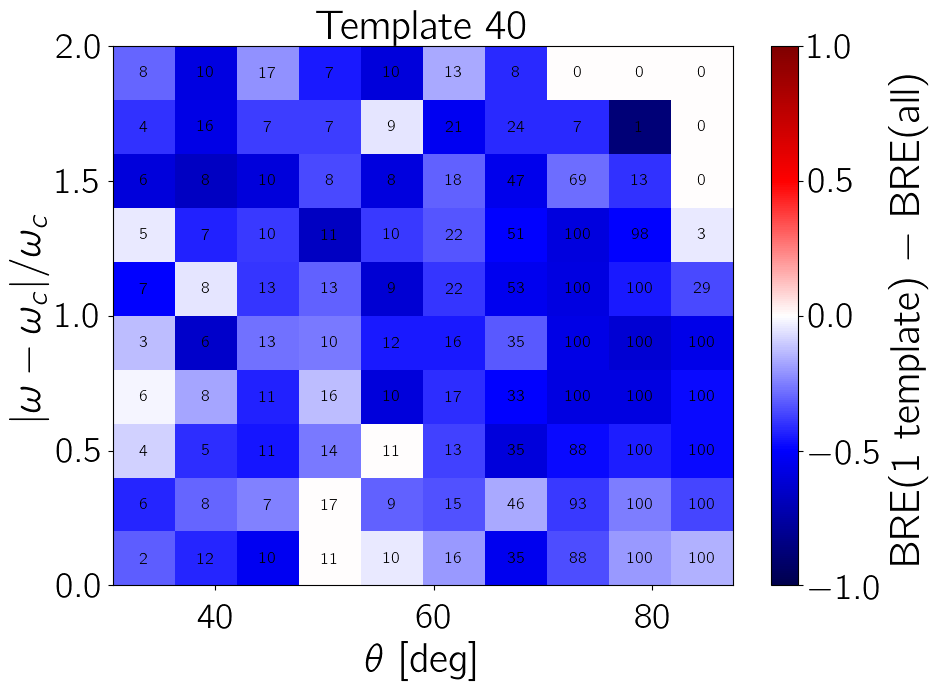

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3388956180976132
-0.27783541147132174


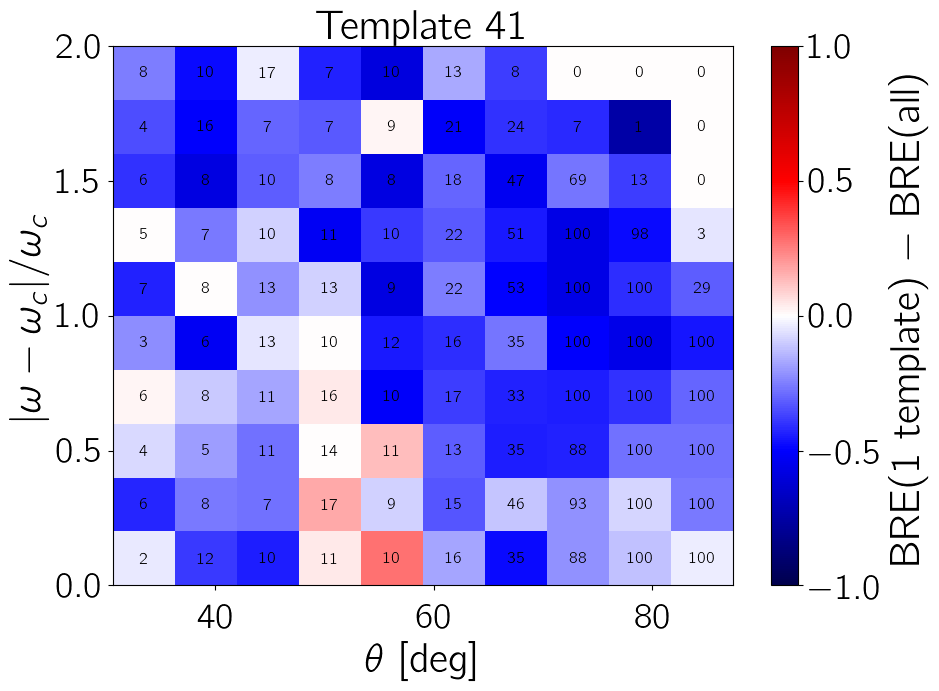

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3345065906661917
-0.3366832917705736


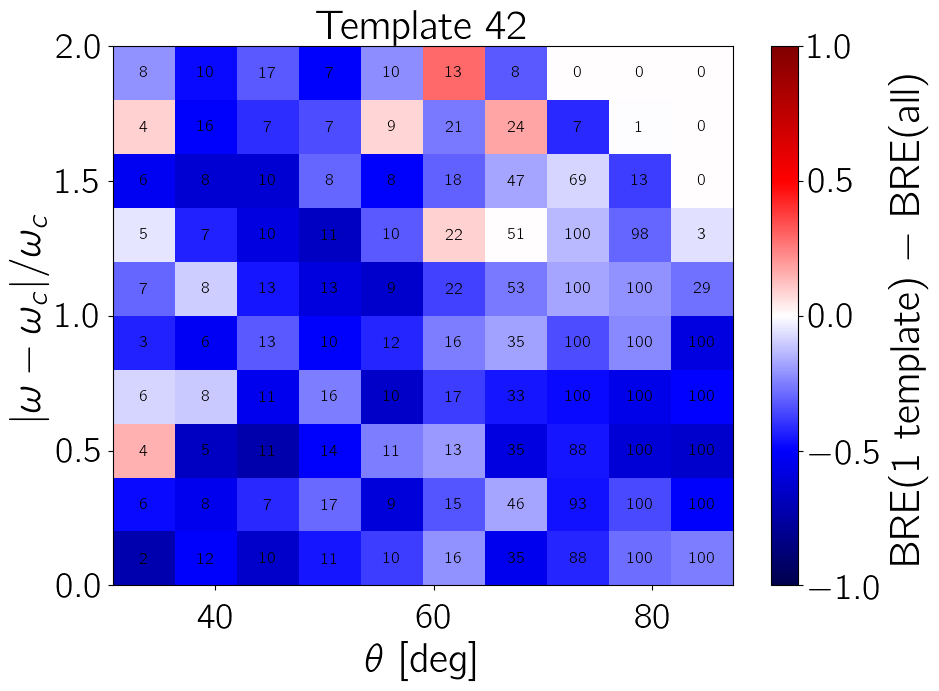

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4242465265407909
-0.3989800498753117


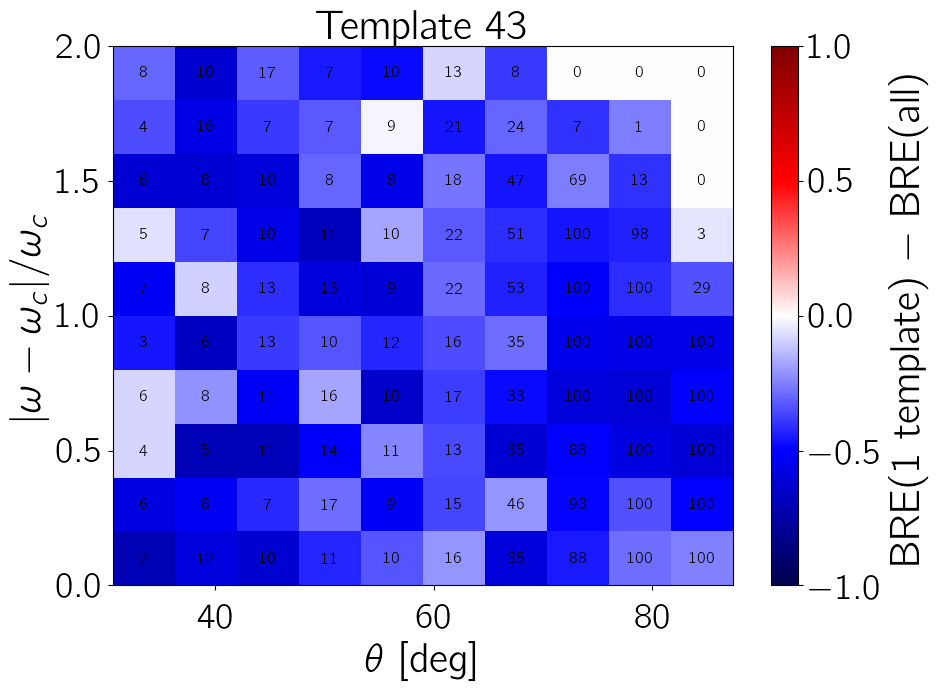

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.09923762023512647
-0.12031172069825438


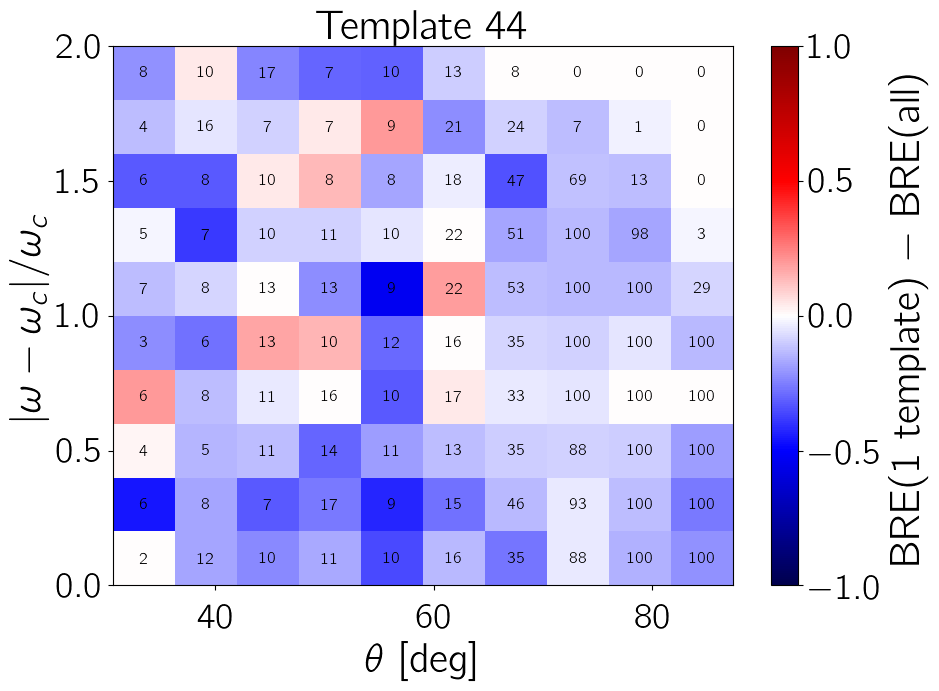

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3865835411471322
-0.33838403990024946


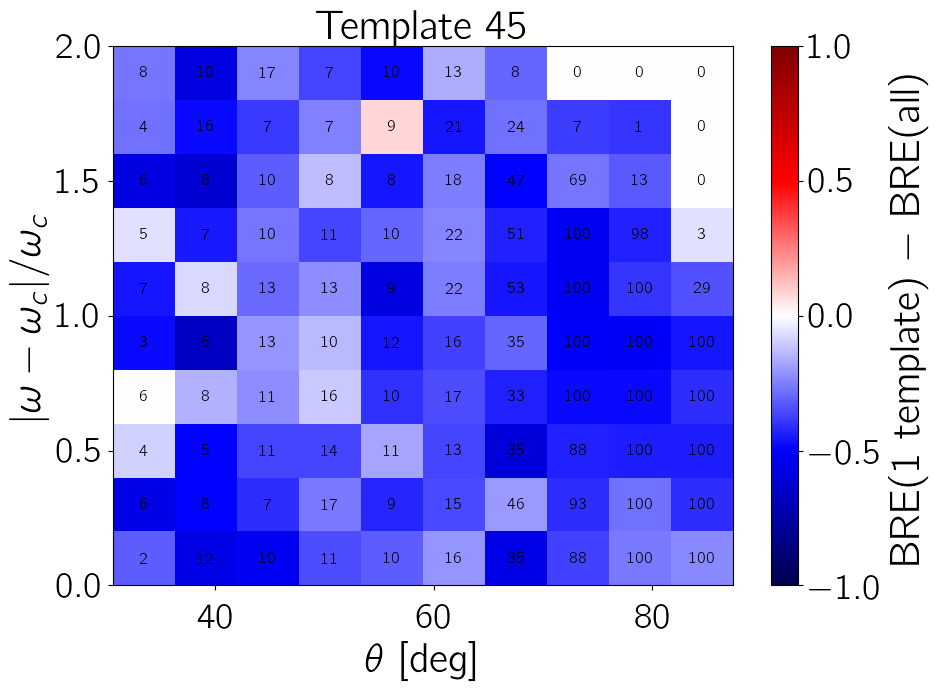

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3356893480584254
-0.3121945137157108


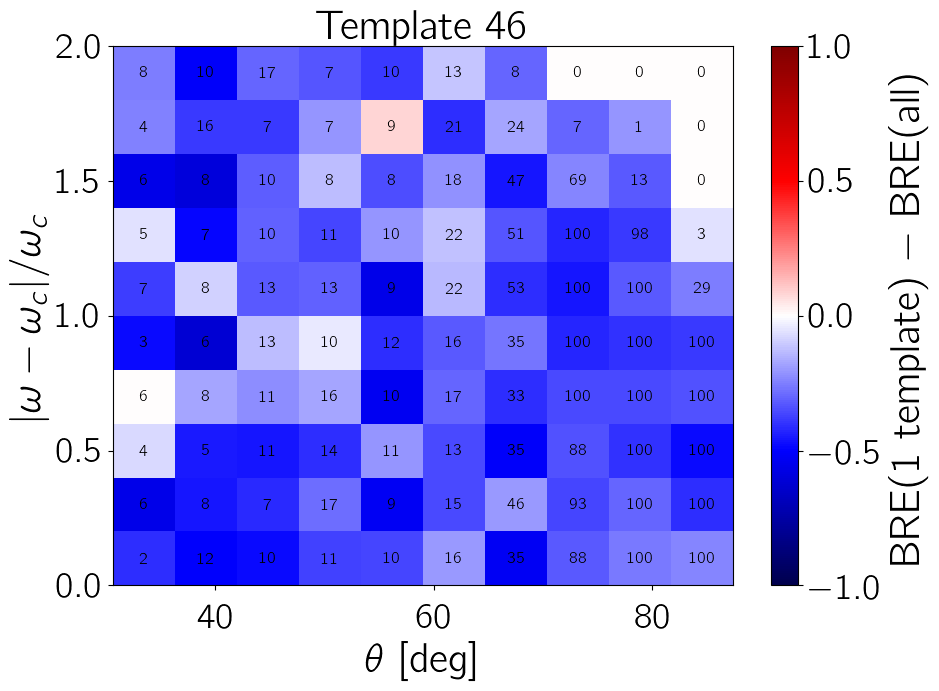

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.42773779836123976
-0.4087481296758104


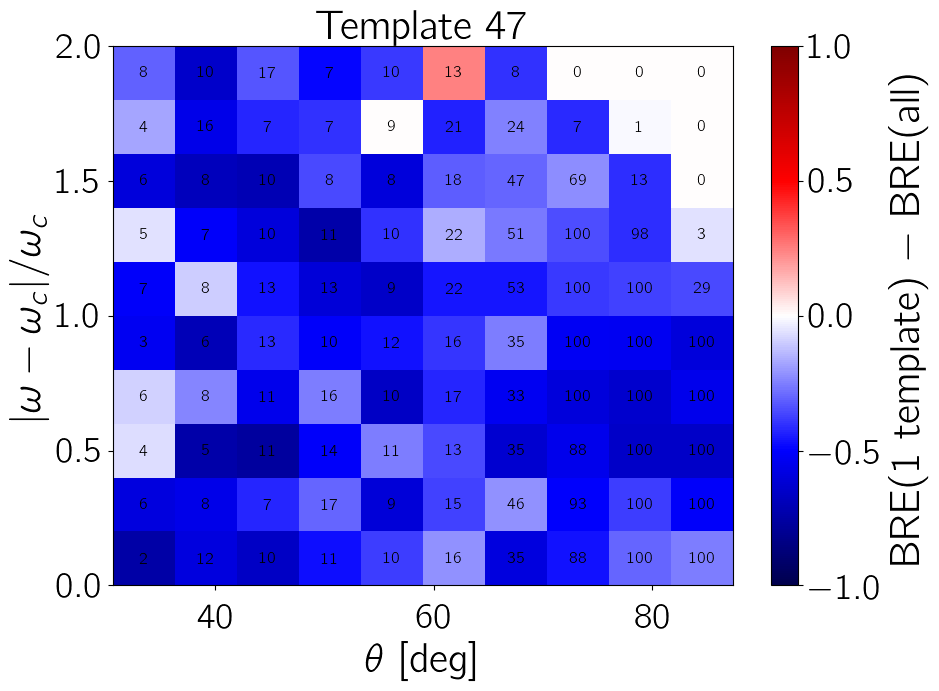

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.44698966868542933
-0.41686284289276815


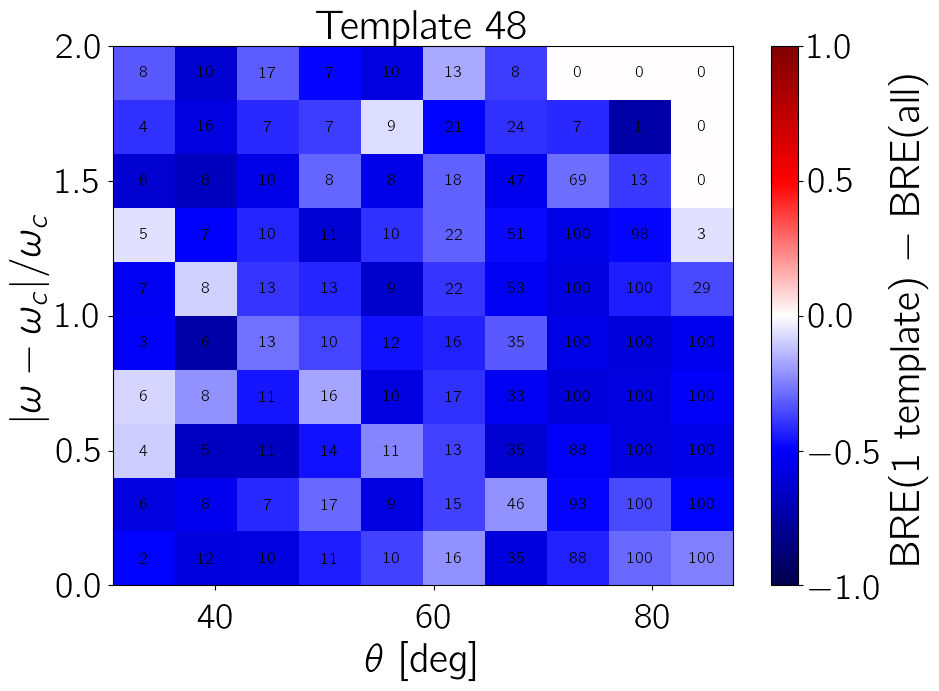

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.47867474171713575
-0.45571072319201994


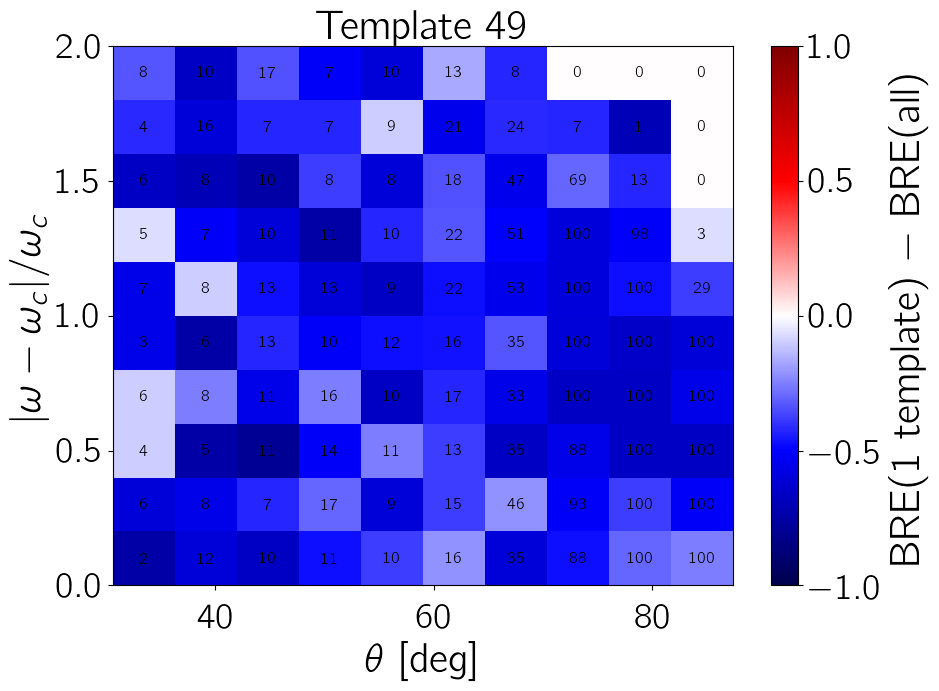

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4624866405415035
-0.43349376558603486


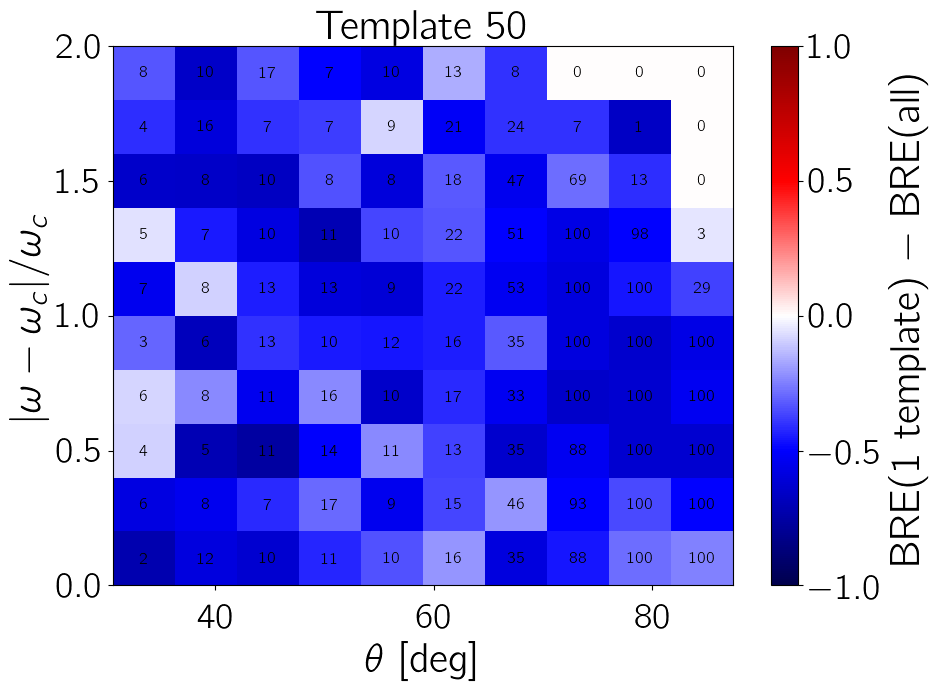

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.37595297470609196
-0.36553615960099756


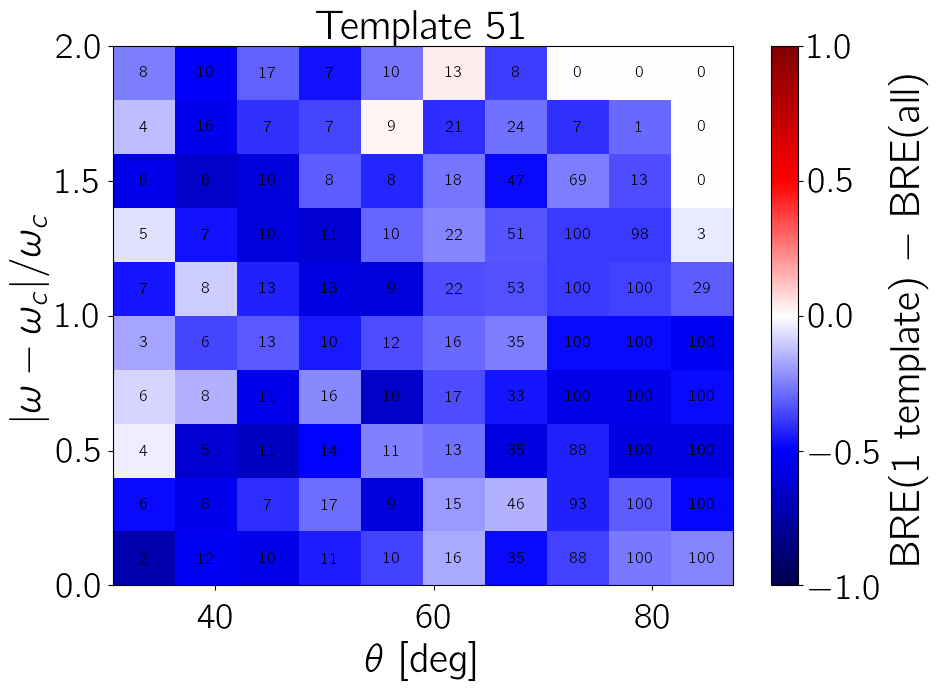

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3328179551122195
-0.3357755610972568


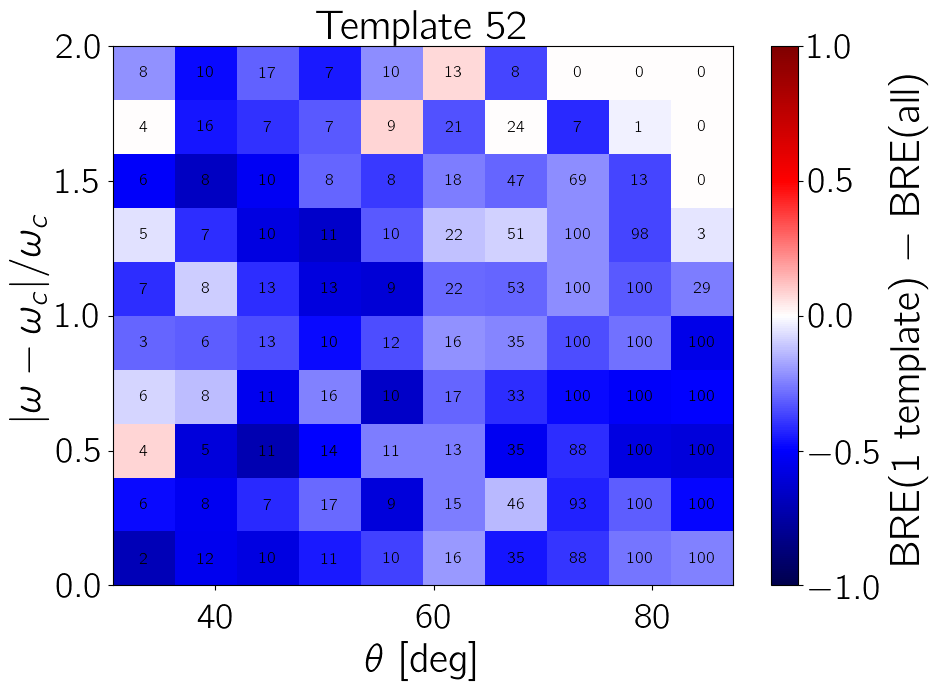

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.29360171001068763
-0.2393865336658354


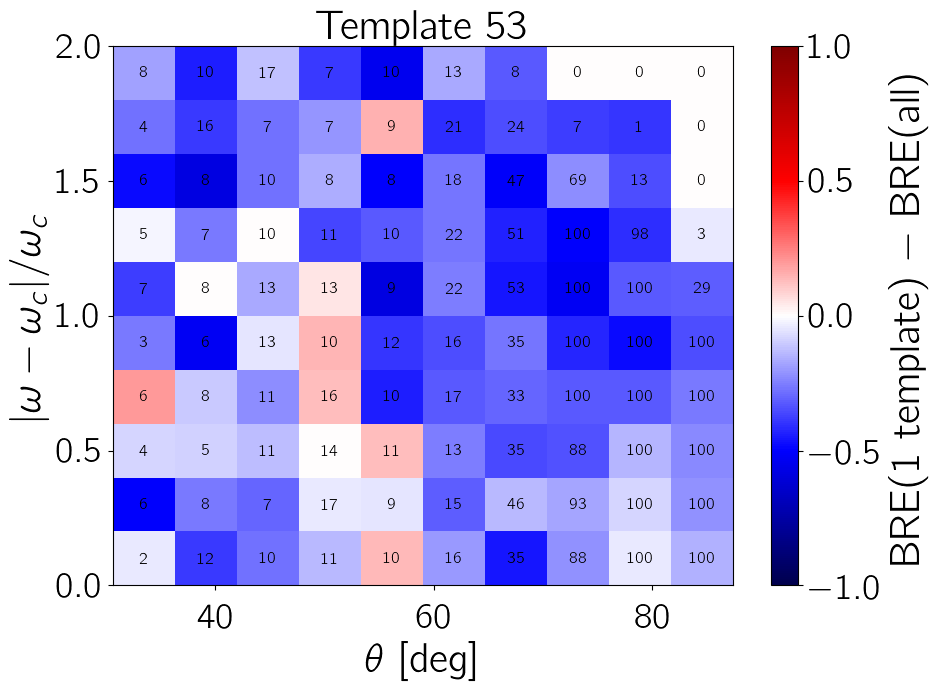

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.35766298539365876
-0.3569925187032419


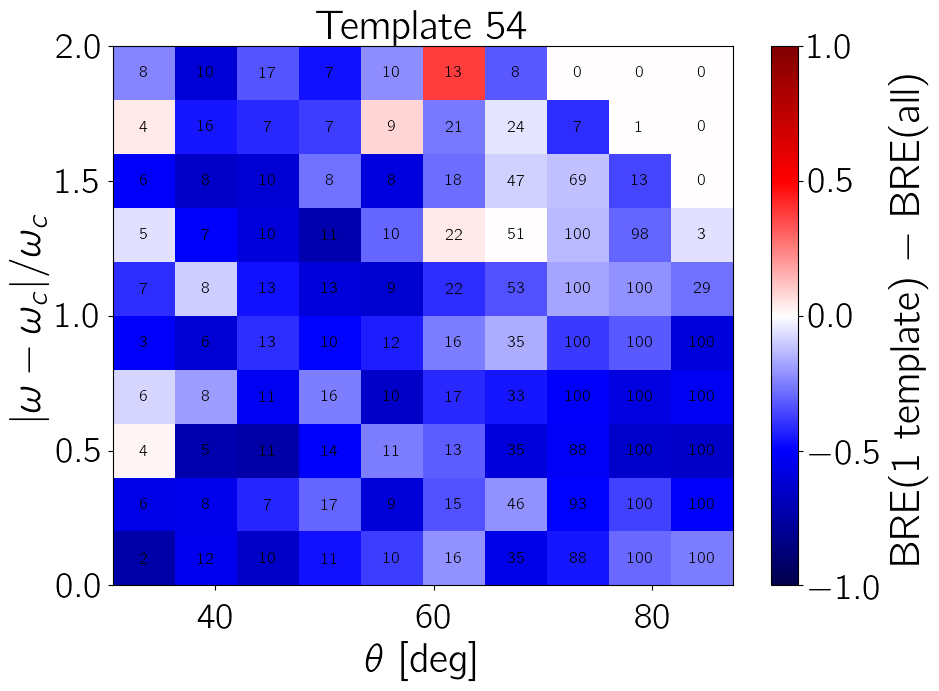

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4506519415746349
-0.42438403990024937


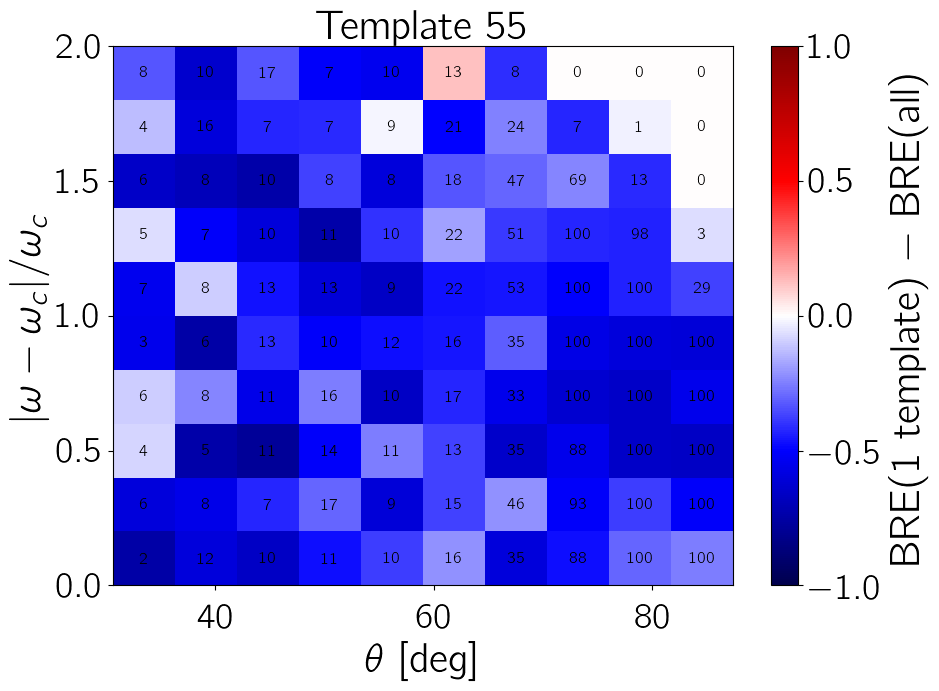

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4673316708229426
-0.4389875311720698


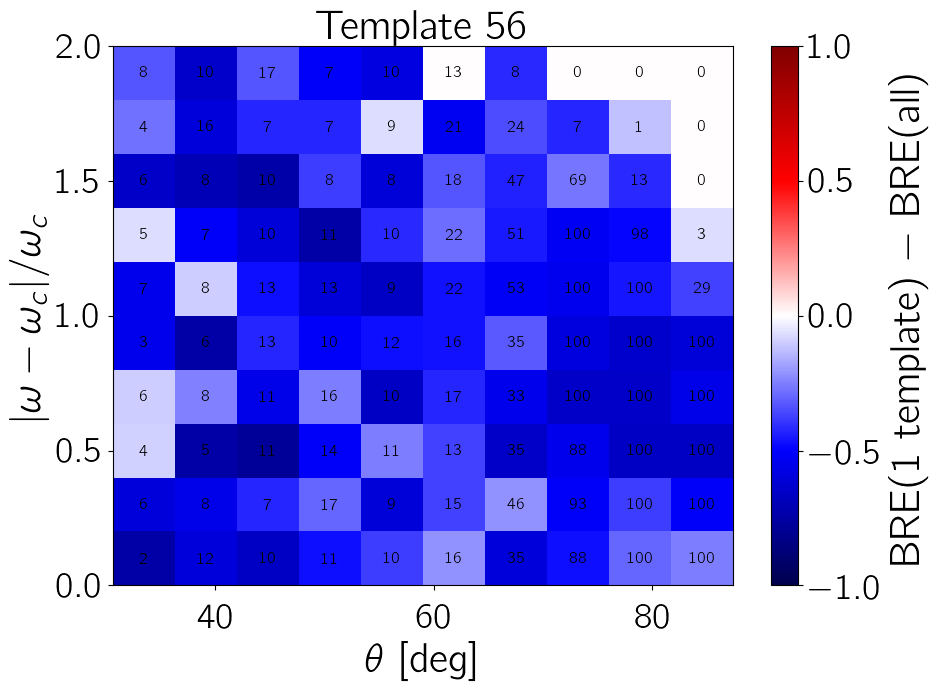

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.45296045600285006
-0.42858603491271813


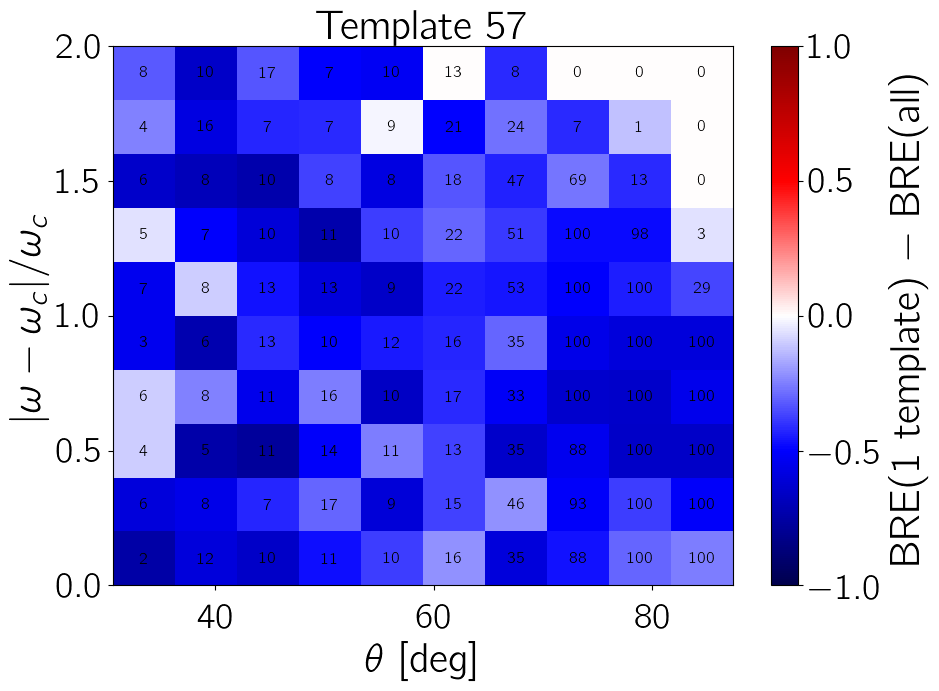

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.47980762379764885
-0.4579551122194514


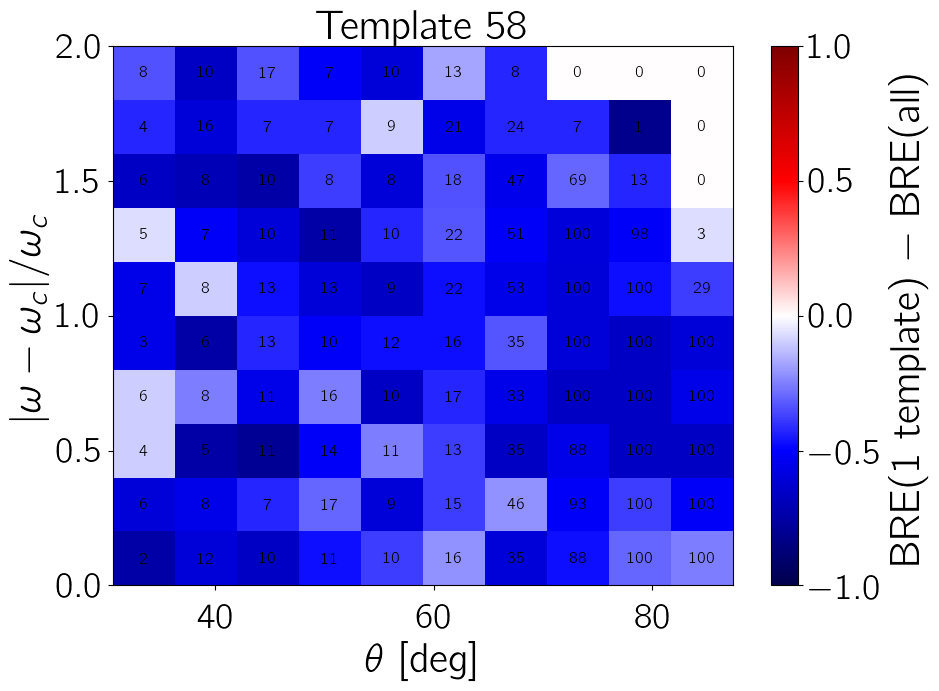

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.47915211970074817
-0.45768827930174566


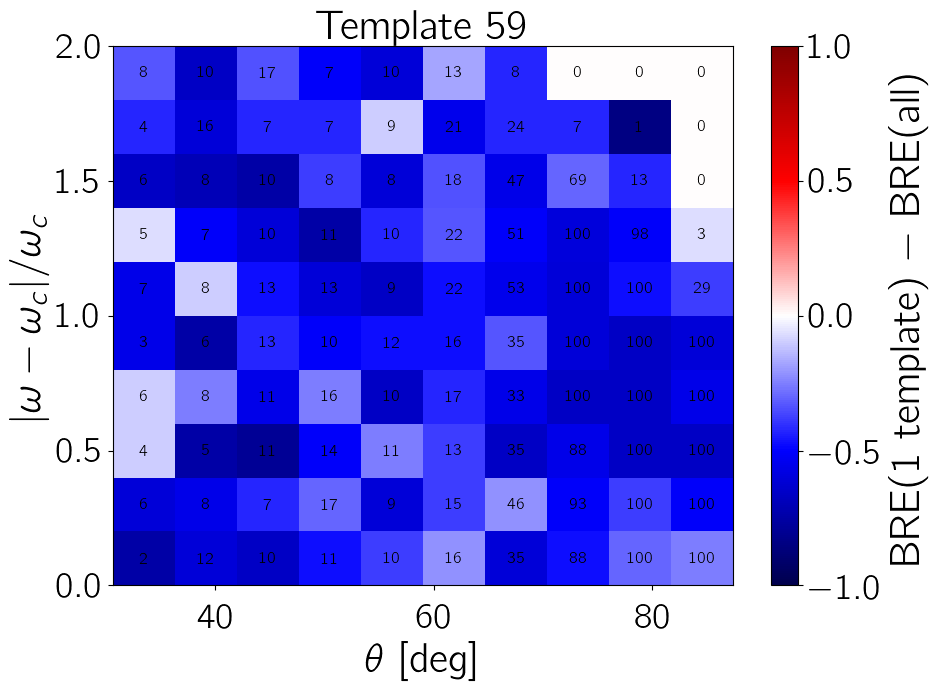

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.1943142144638404
-0.22094513715710726


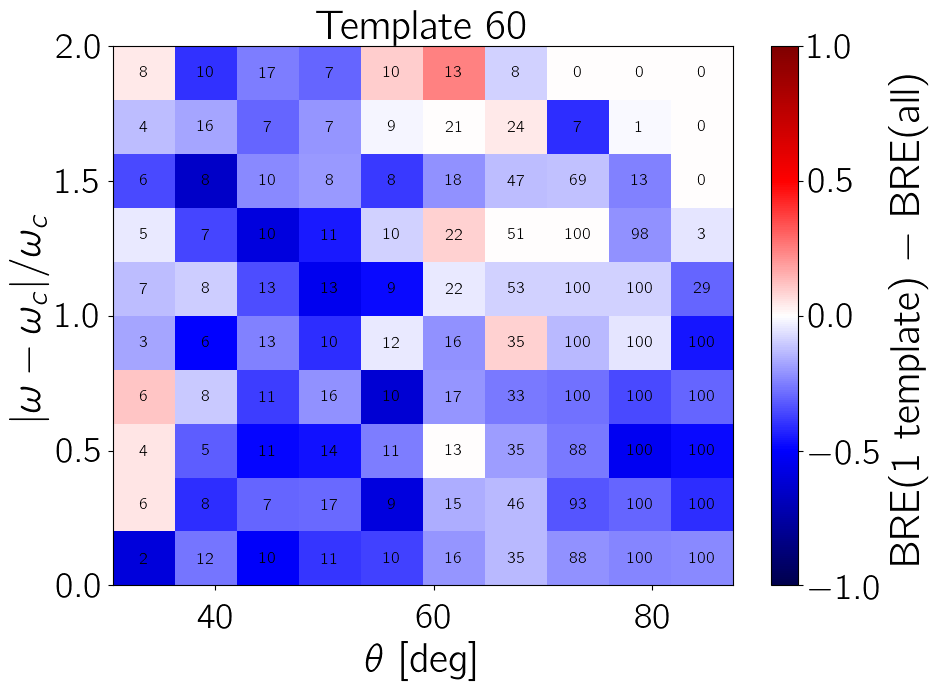

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.2476879230495191
-0.2654688279301746


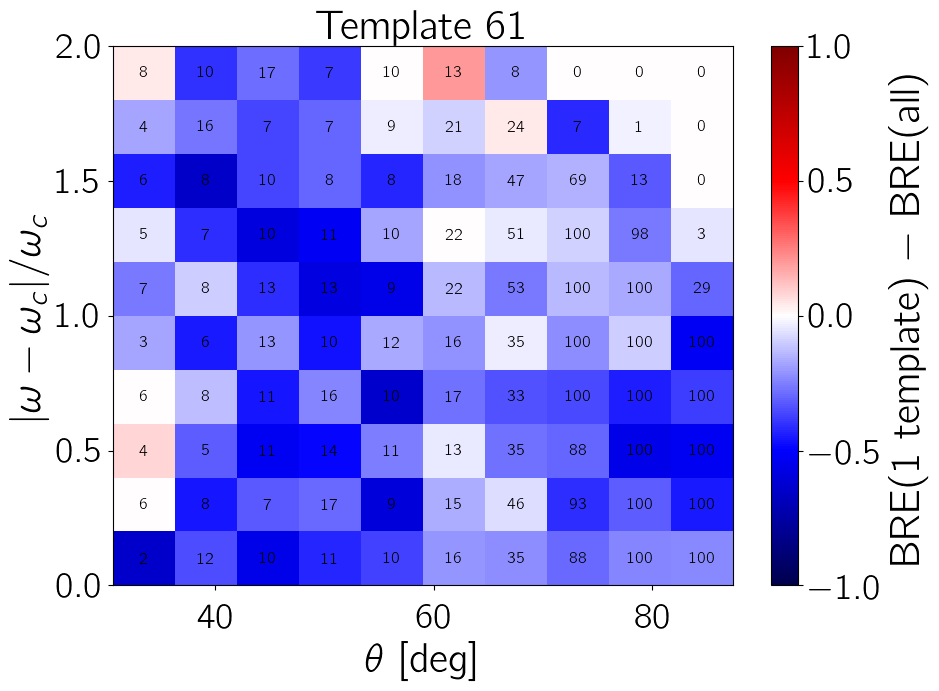

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.24859992874955472
-0.2616059850374065


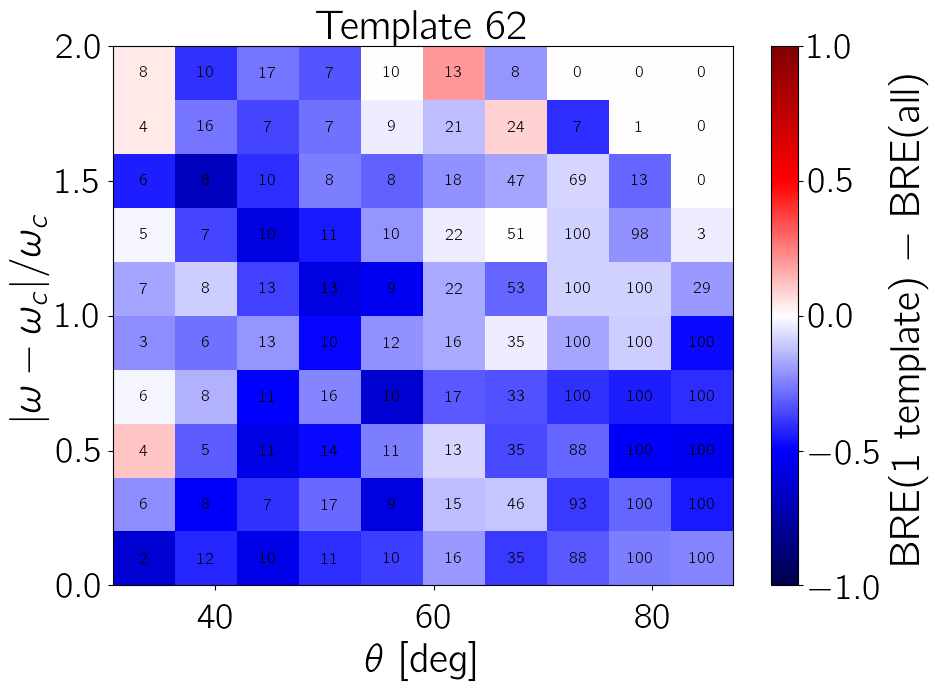

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.15488421802636268
-0.19235910224438904


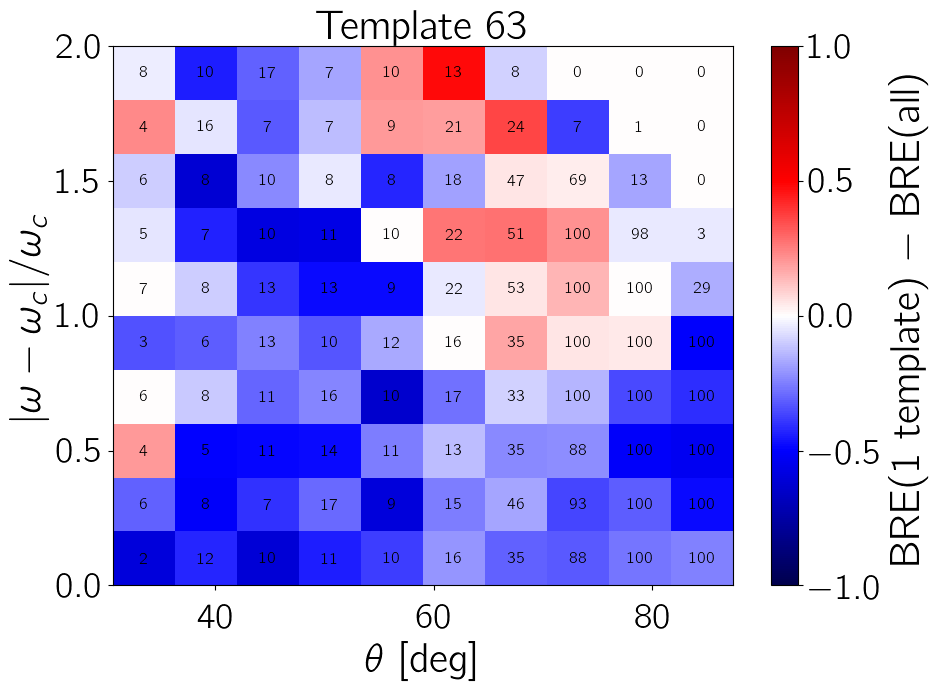

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3725757035981475
-0.3679925187032419


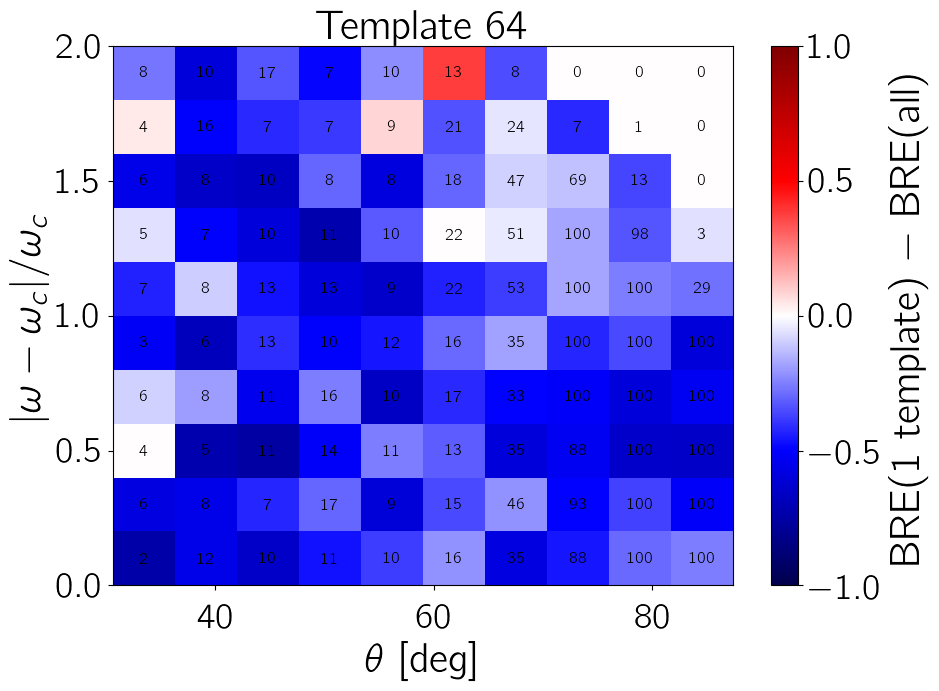

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.36488778054862847
-0.36413216957605987


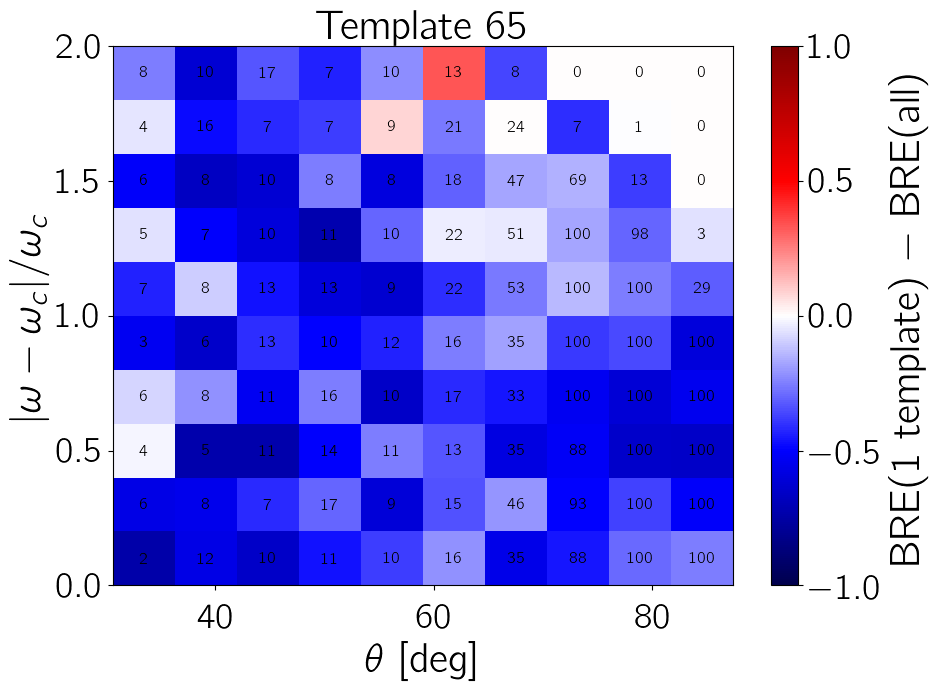

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.37019593872461704
-0.36670074812967585


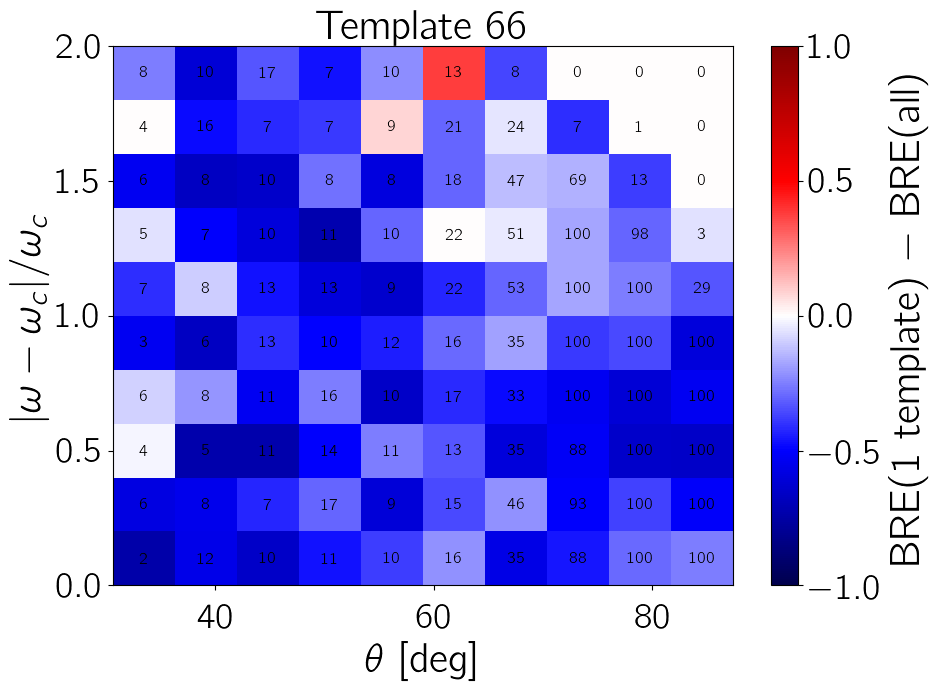

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4715639472746705
-0.44392518703241896


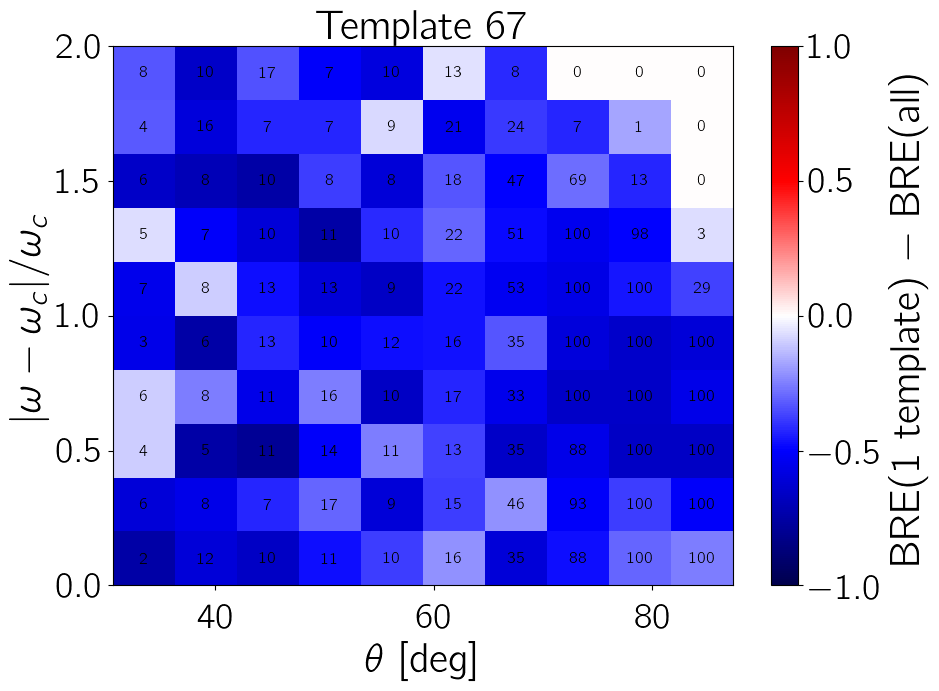

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.47722835767723554
-0.4516084788029926


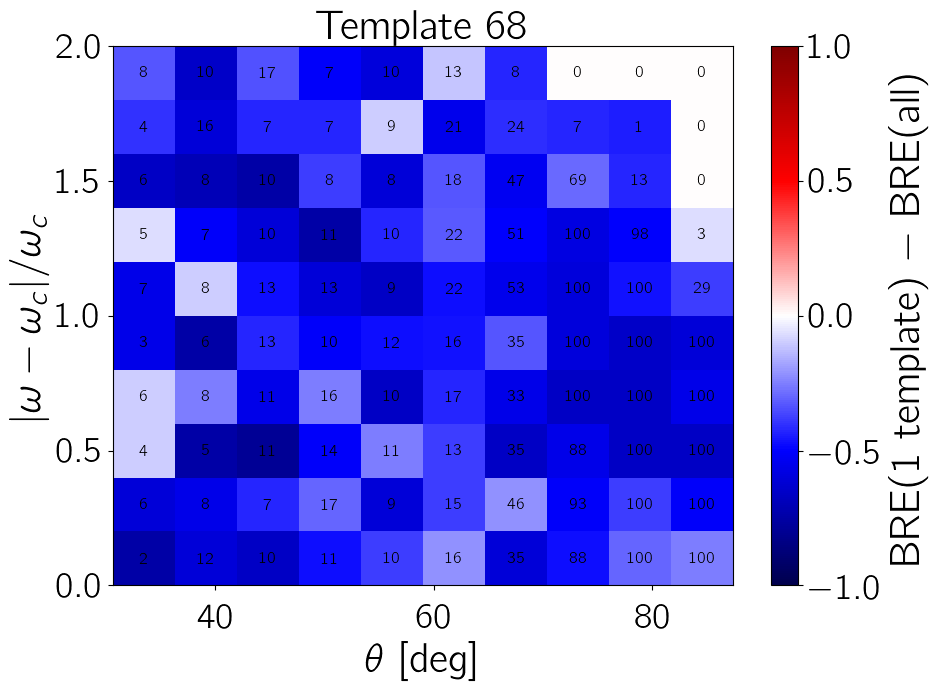

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4159315995724973
-0.40070573566084783


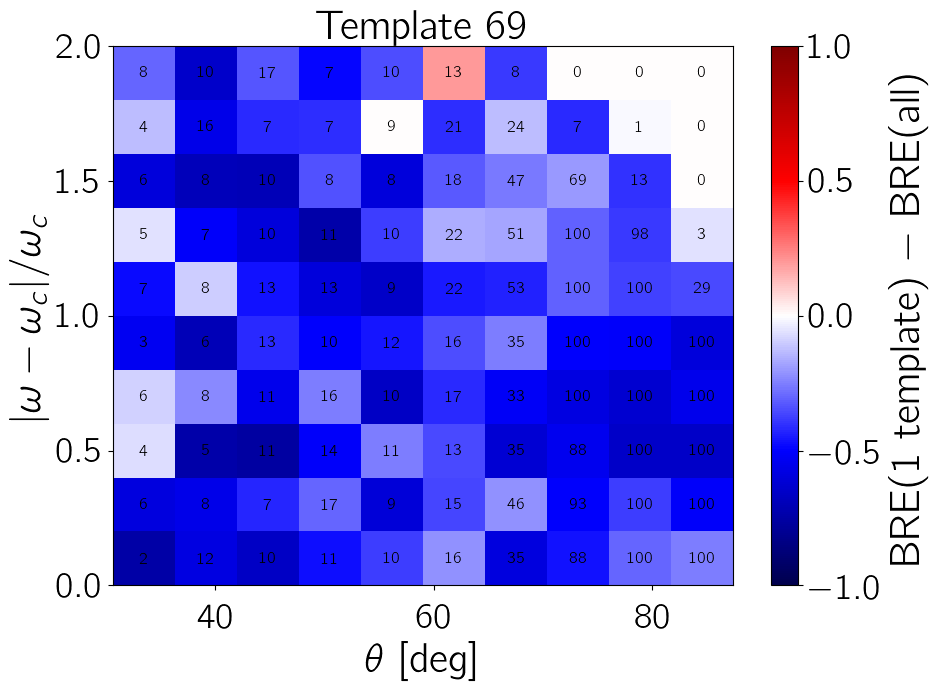

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.028920555753473444
0.006446384039900244


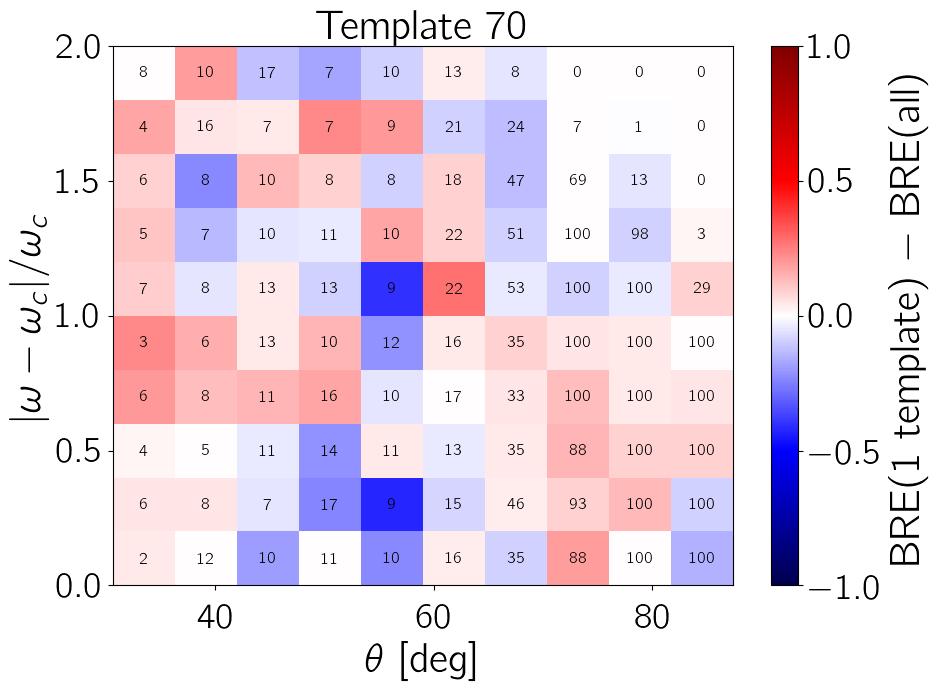

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.07749910936943356
0.04028428927680798


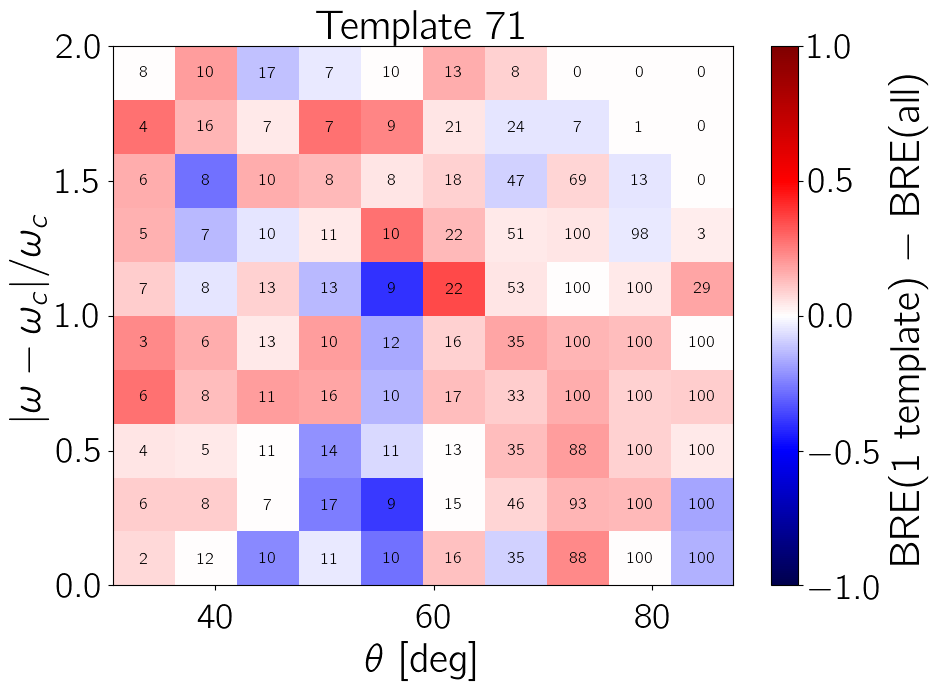

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.025301033131457058
-0.02238154613466335


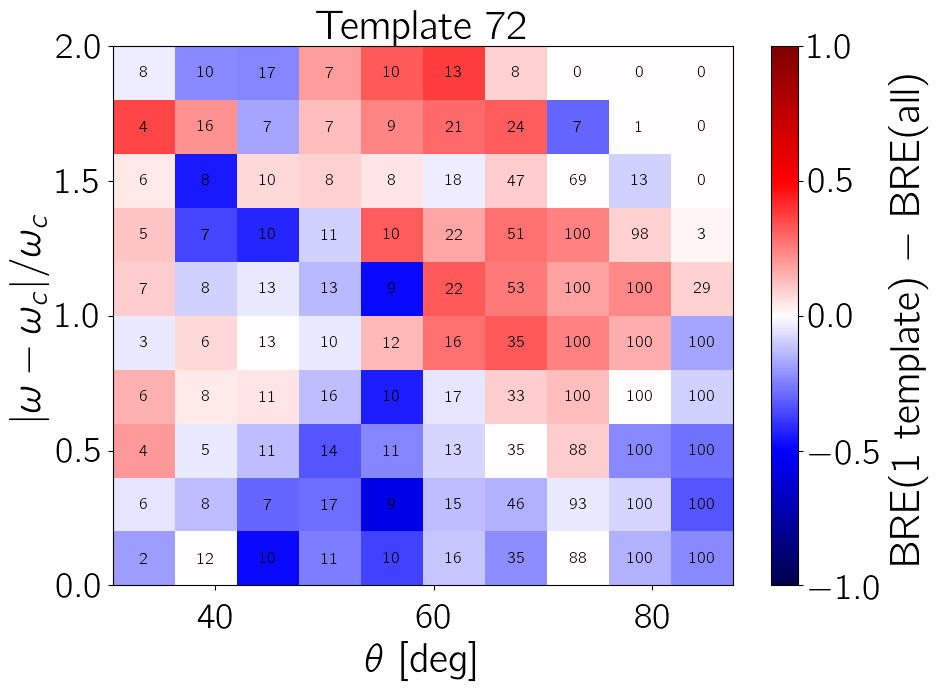

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.08864267901674384
0.047795511221945135


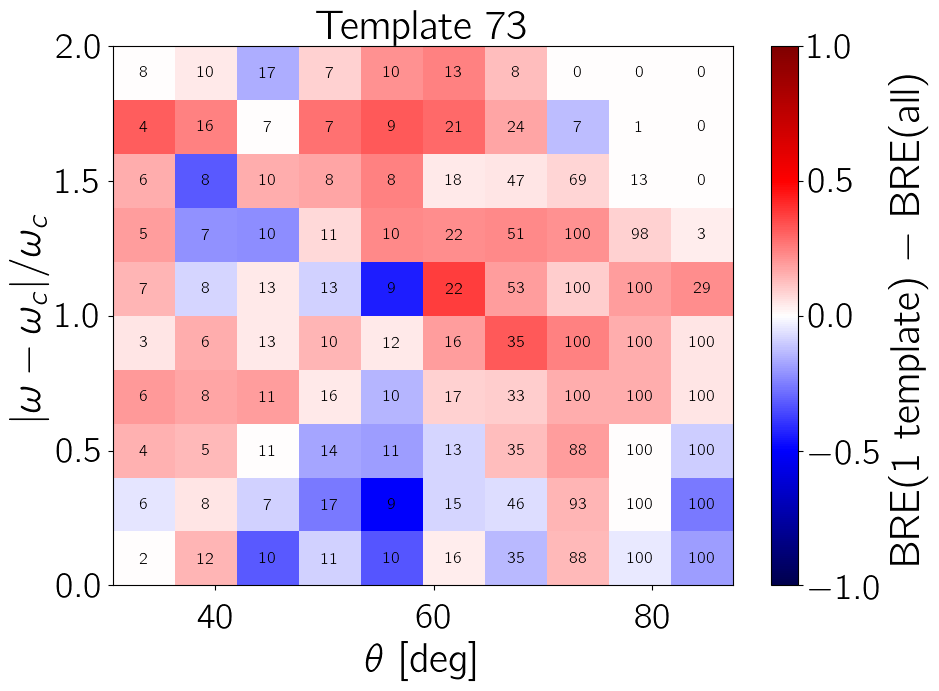

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.27431421446384036
-0.2960972568578554


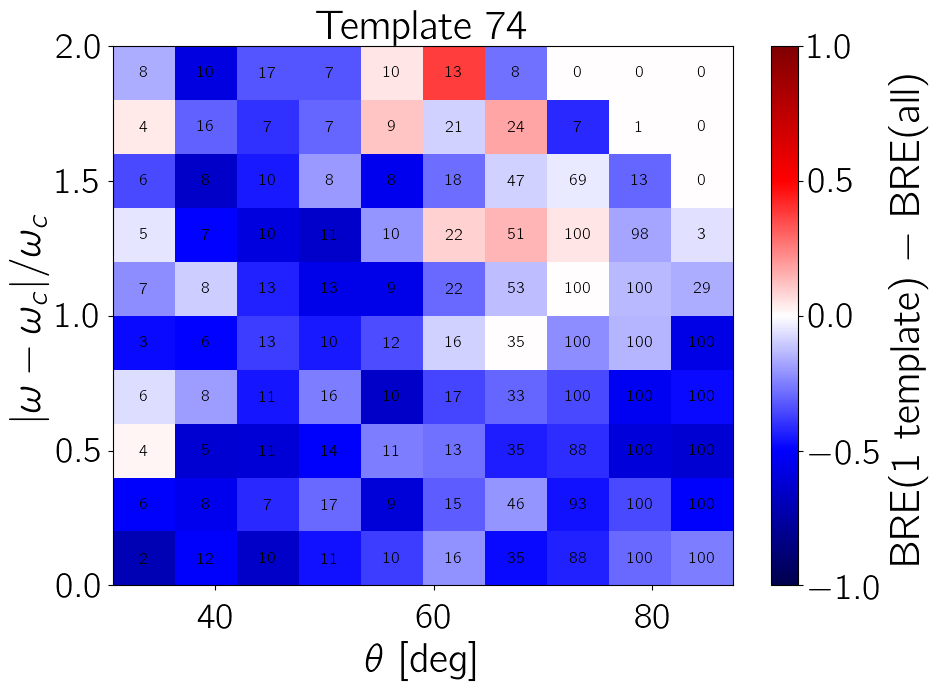

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.22451015318845746
-0.25062842892768084


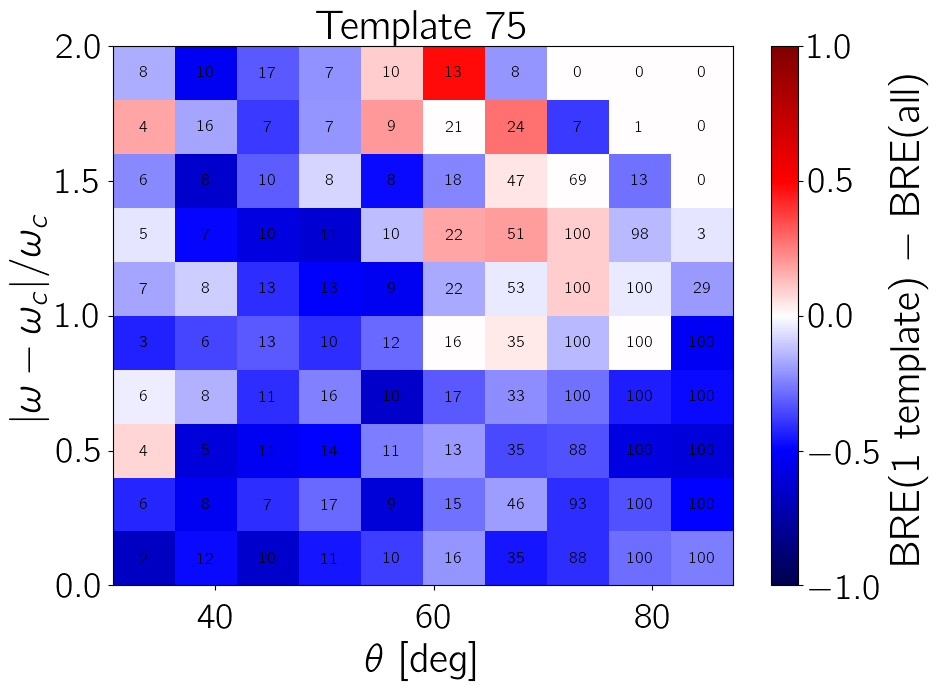

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4068400427502672
-0.3932369077306733


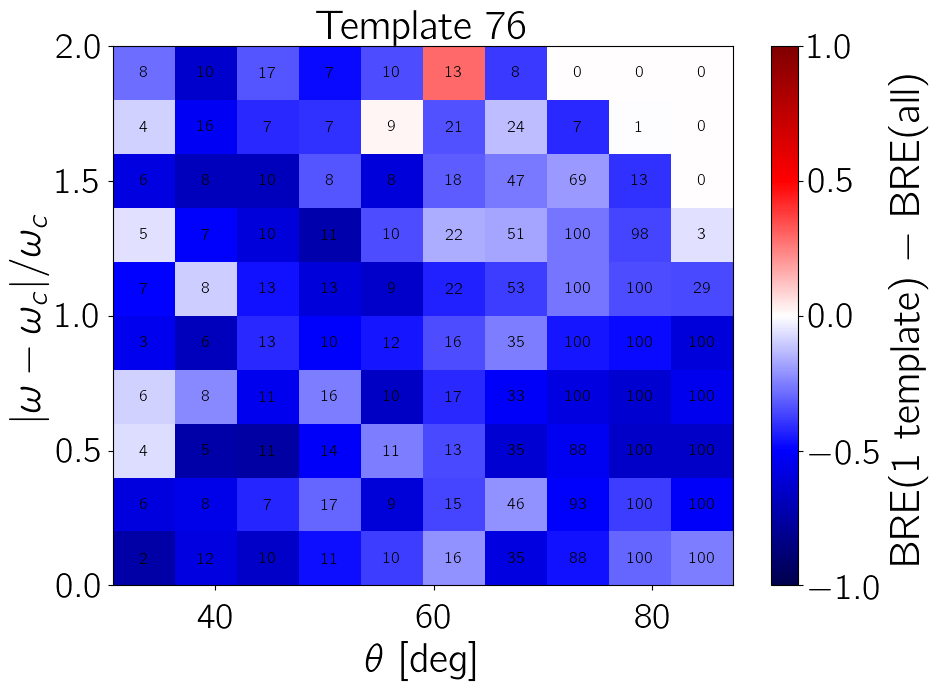

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4743569647310295
-0.44828678304239405


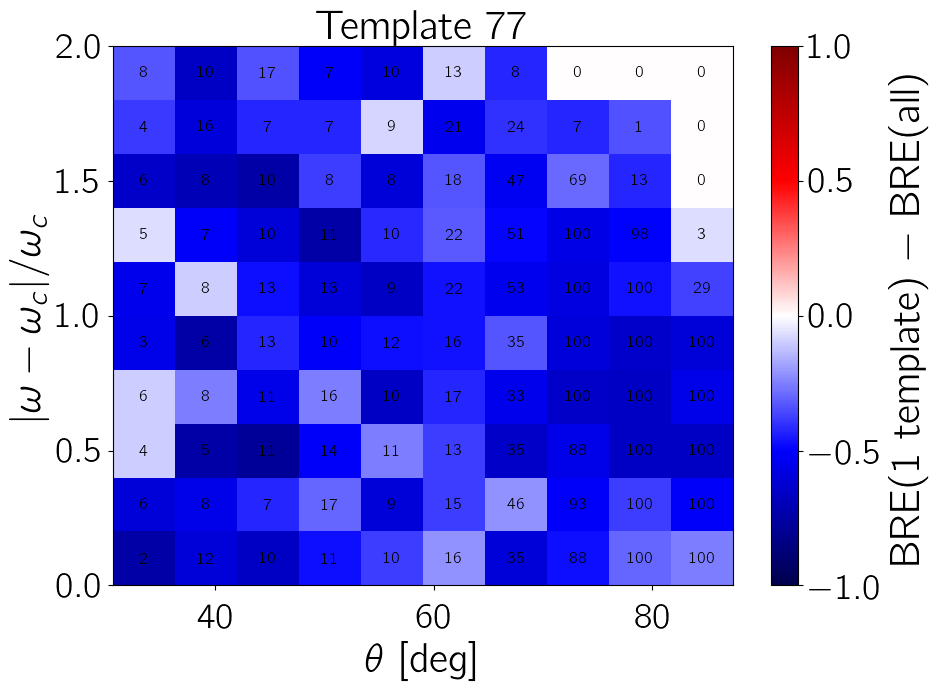

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4751692198076238
-0.448785536159601


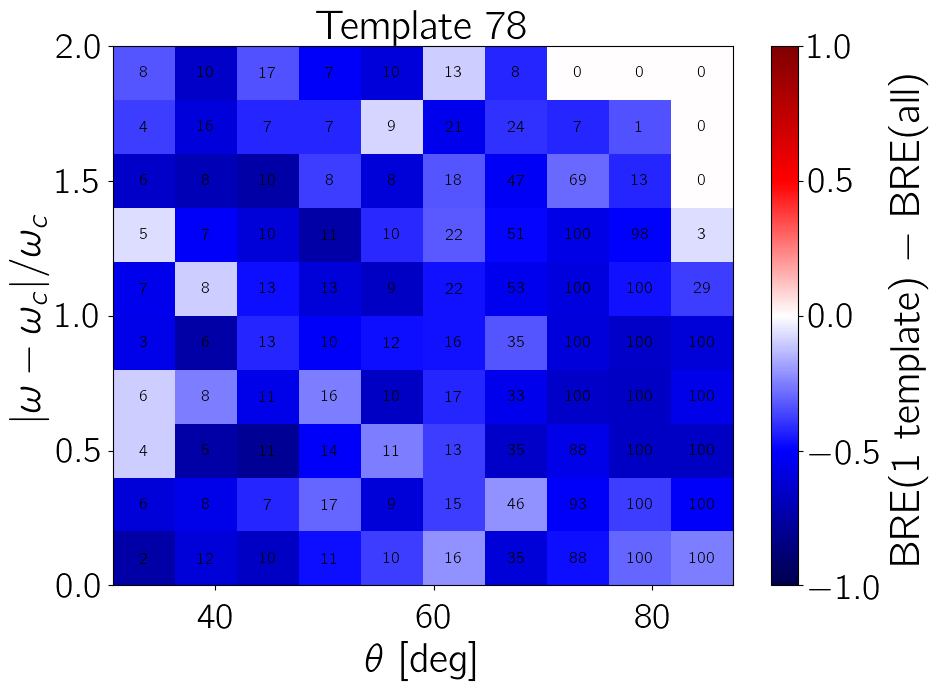

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4786319914499466
-0.4548079800498753


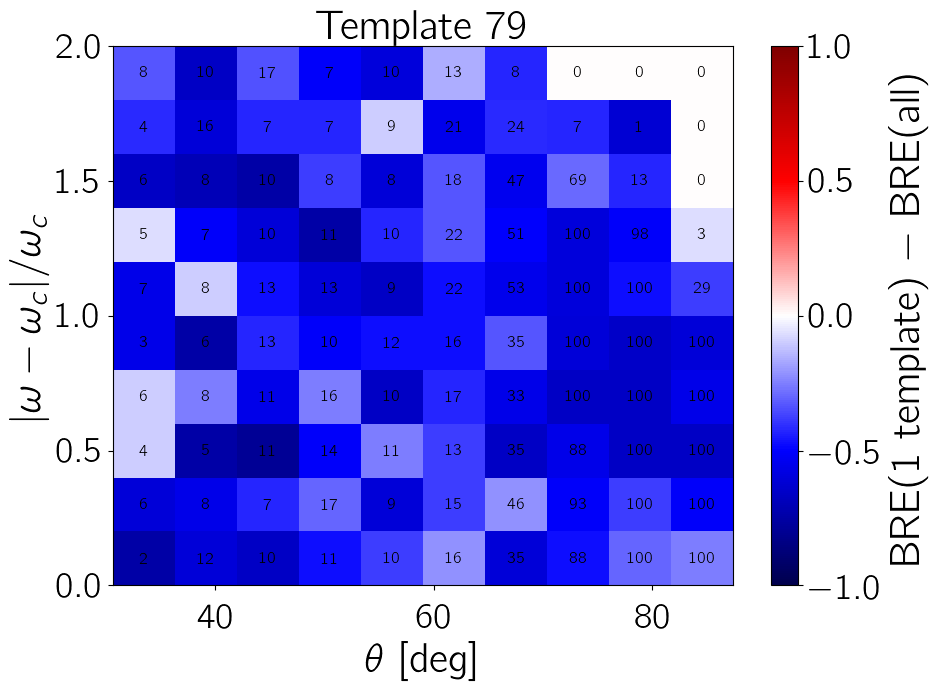

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.13794086213038836
-0.11860598503740649


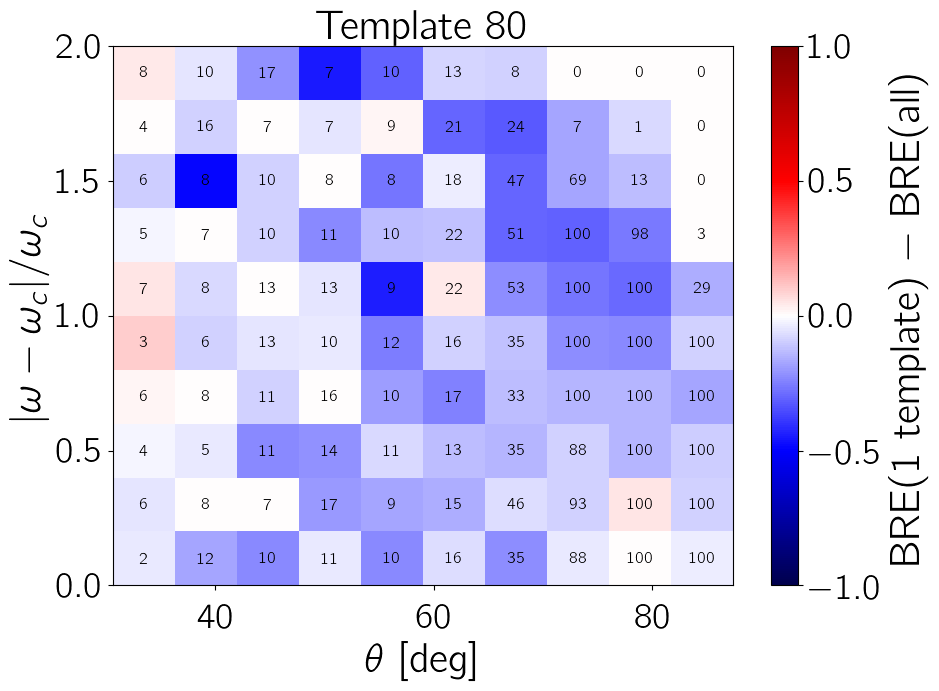

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.0864125400783755
-0.0766783042394015


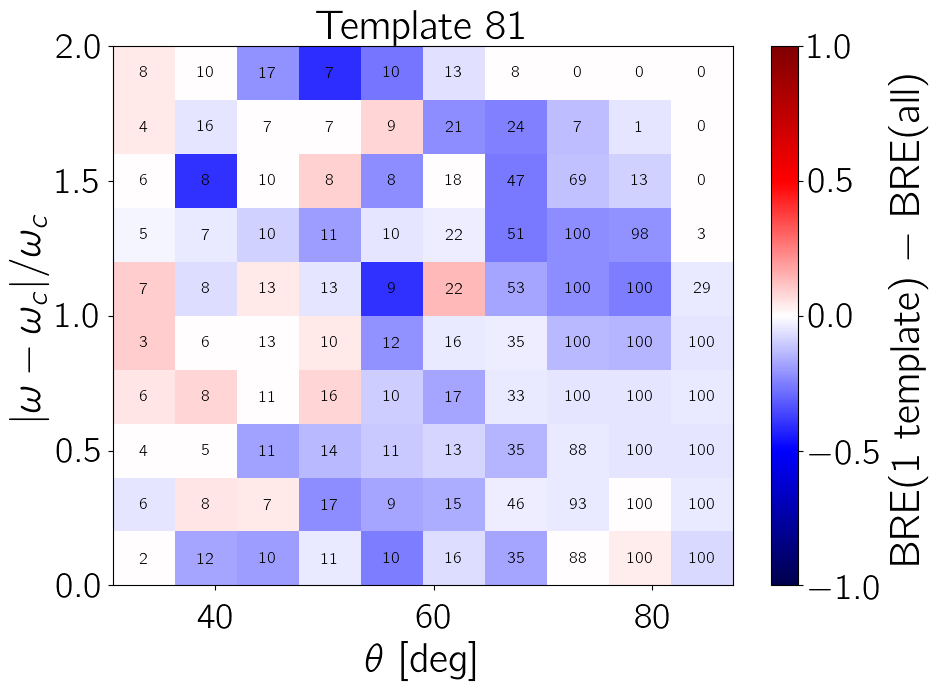

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.06314926968293552
0.030179551122194514


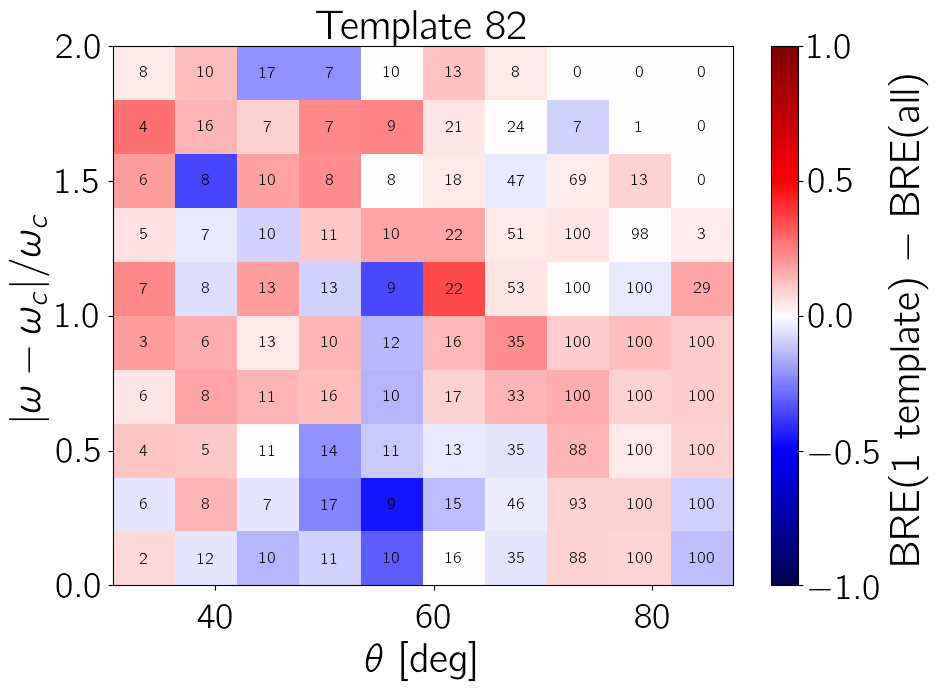

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.04208051300320627
0.014089775561097256


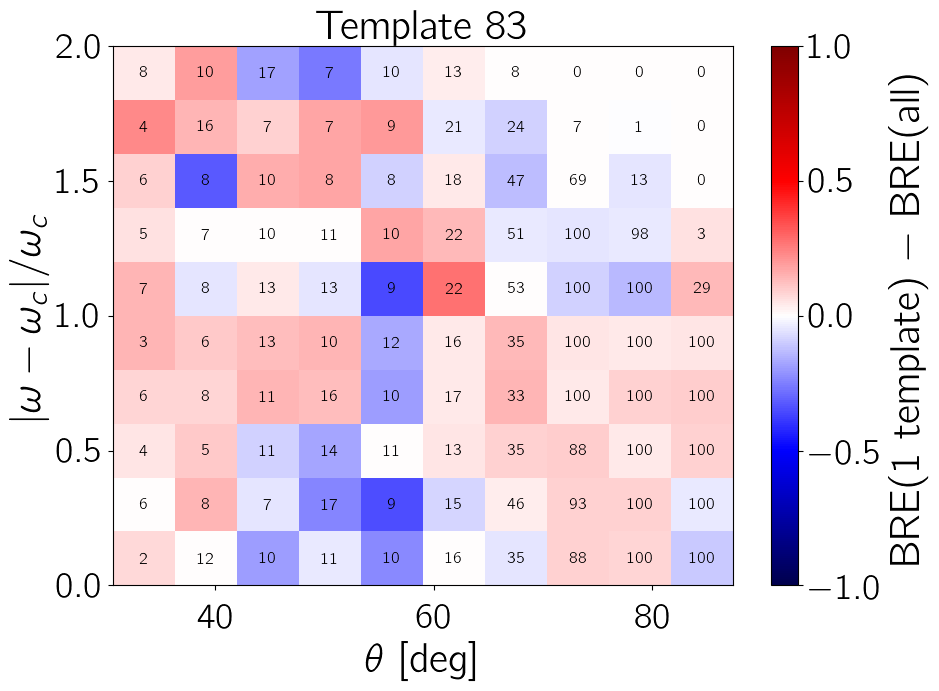

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.20949768436052726
-0.23681546134663342


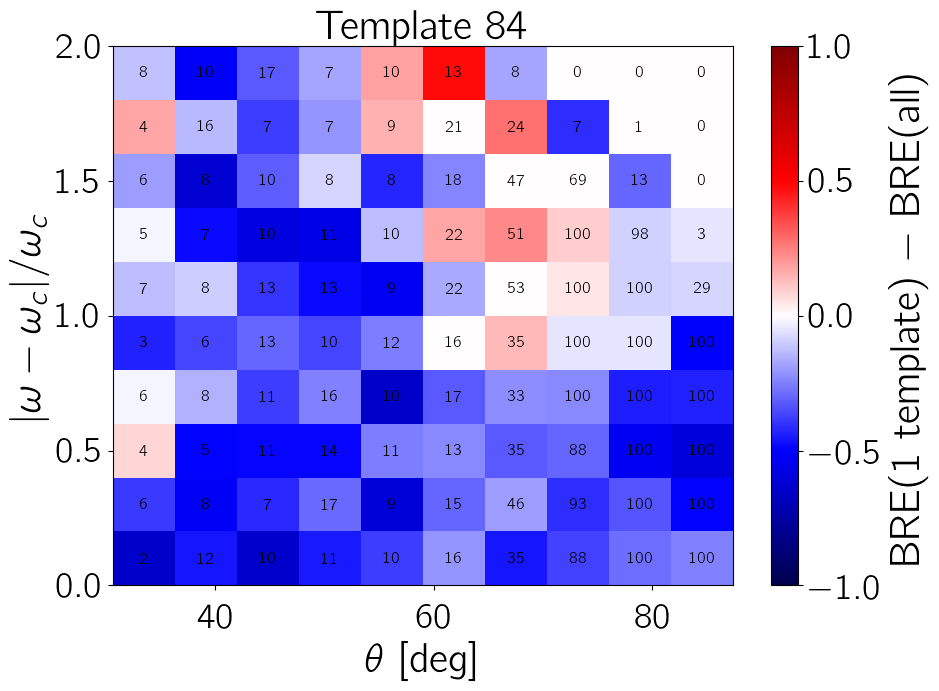

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4141075881724261
-0.39766084788029926


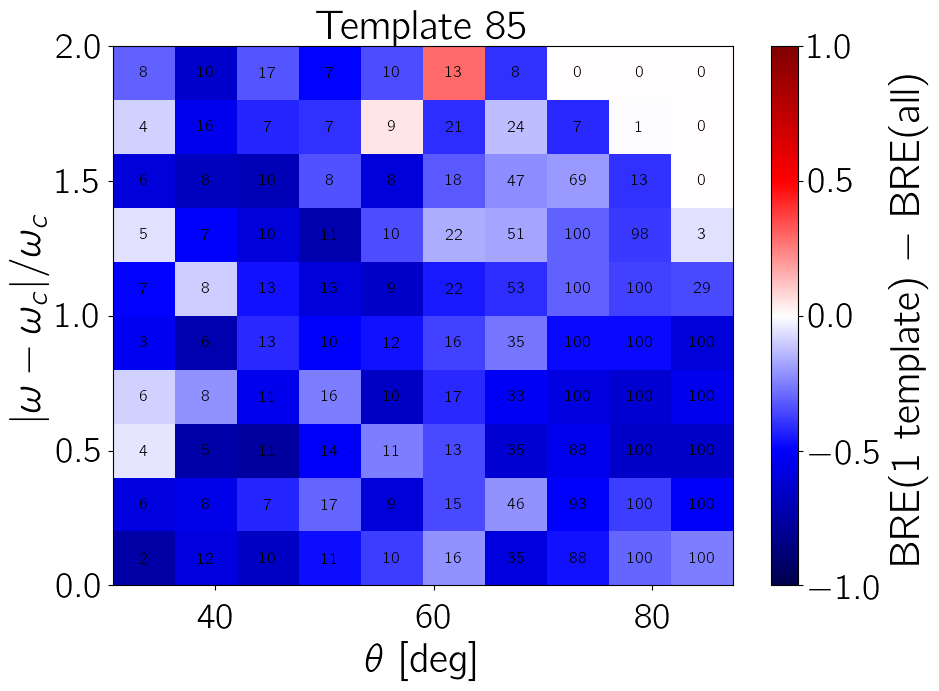

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4010473815461347
-0.3886483790523691


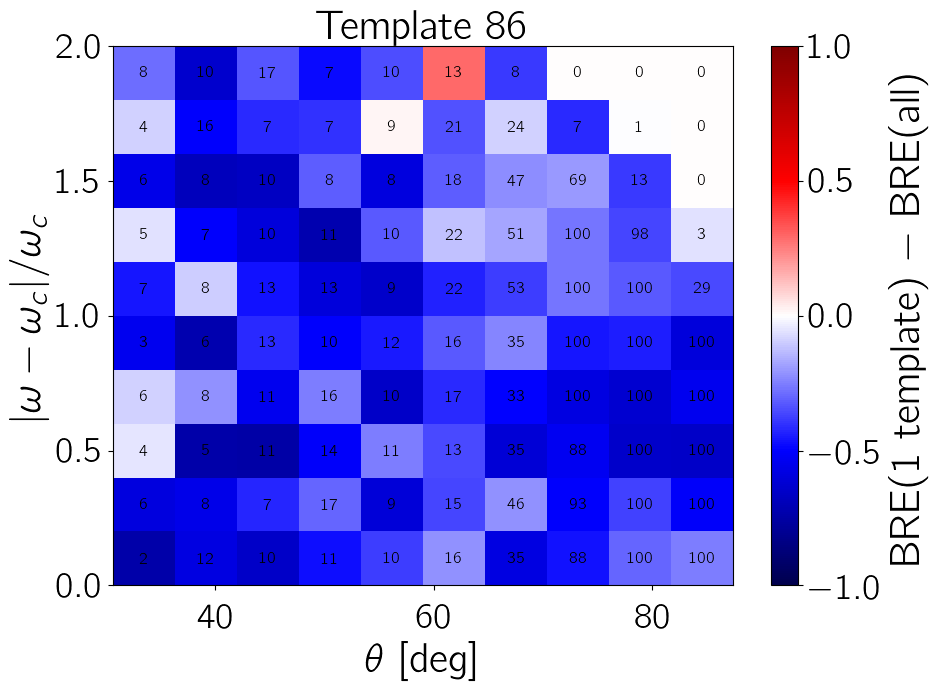

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.41680798004987535
-0.401206982543641


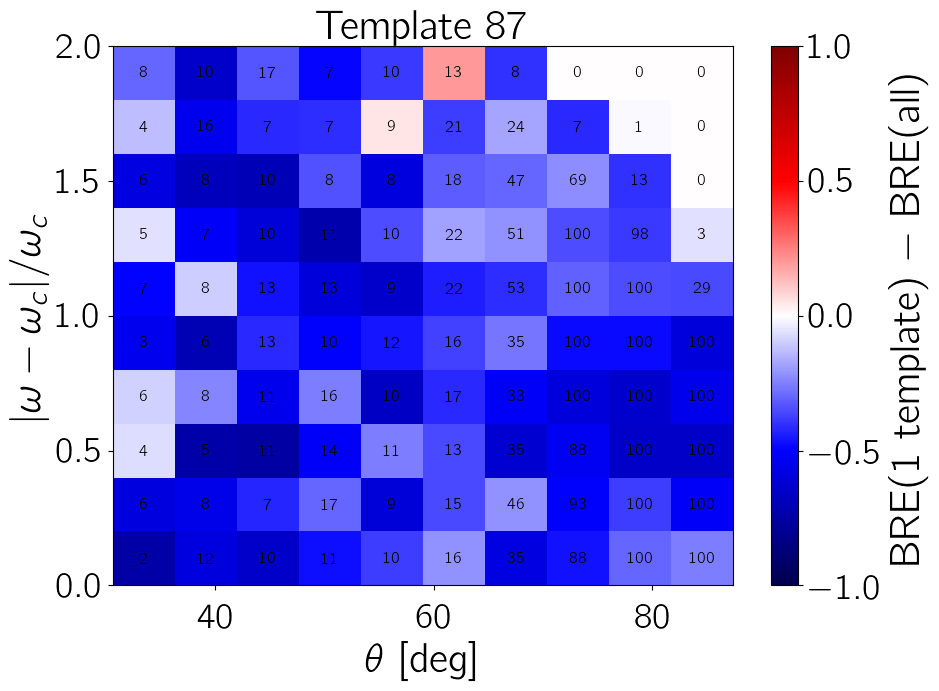

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.4677734235838974
-0.4402369077306733


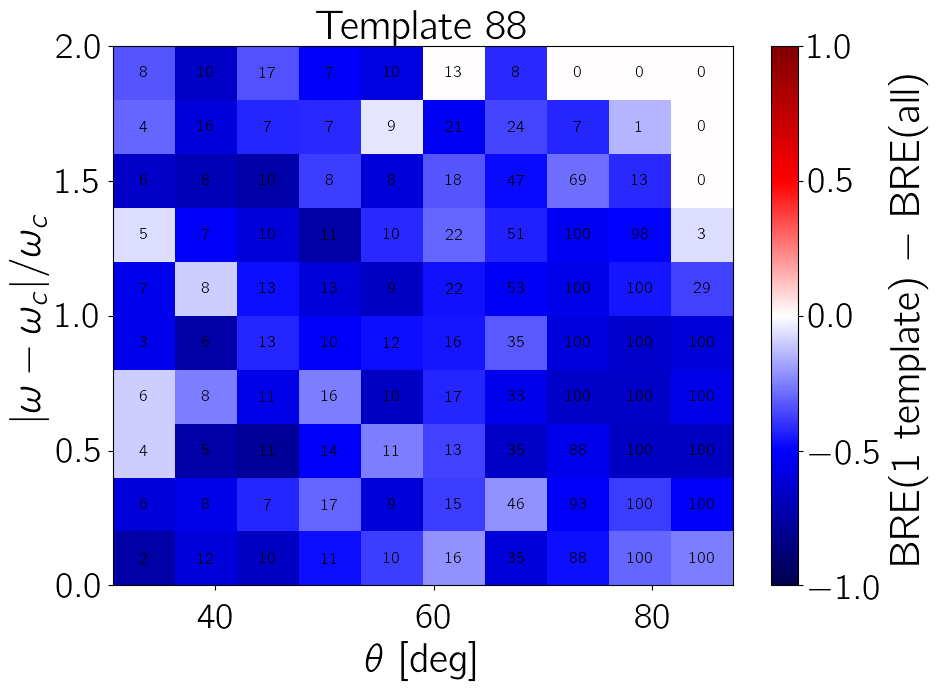

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3789597434983969
-0.3461645885286783


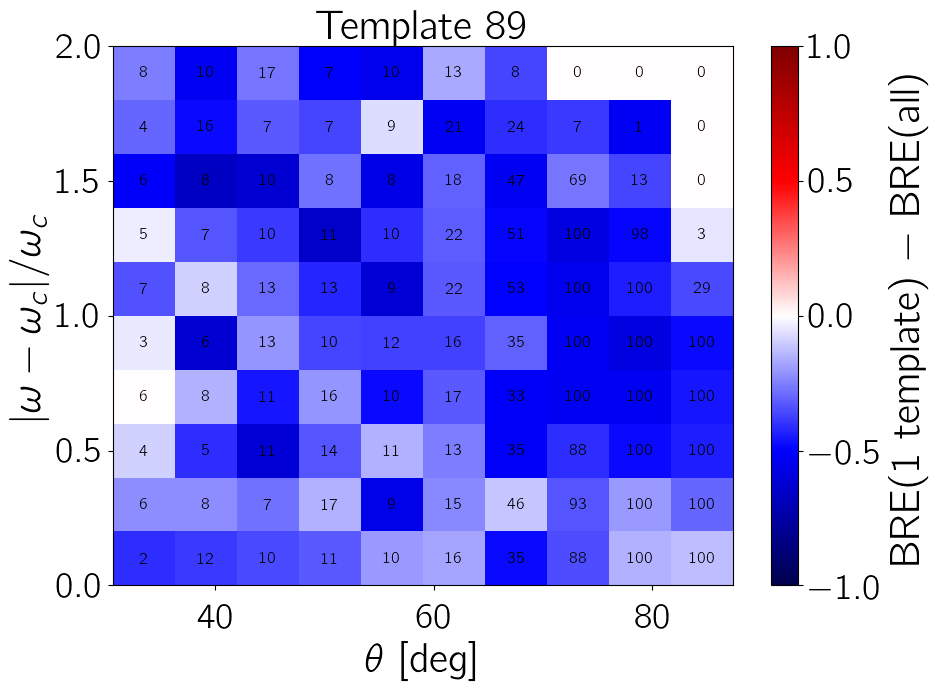

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.00921980762379764
-0.005064837905236914


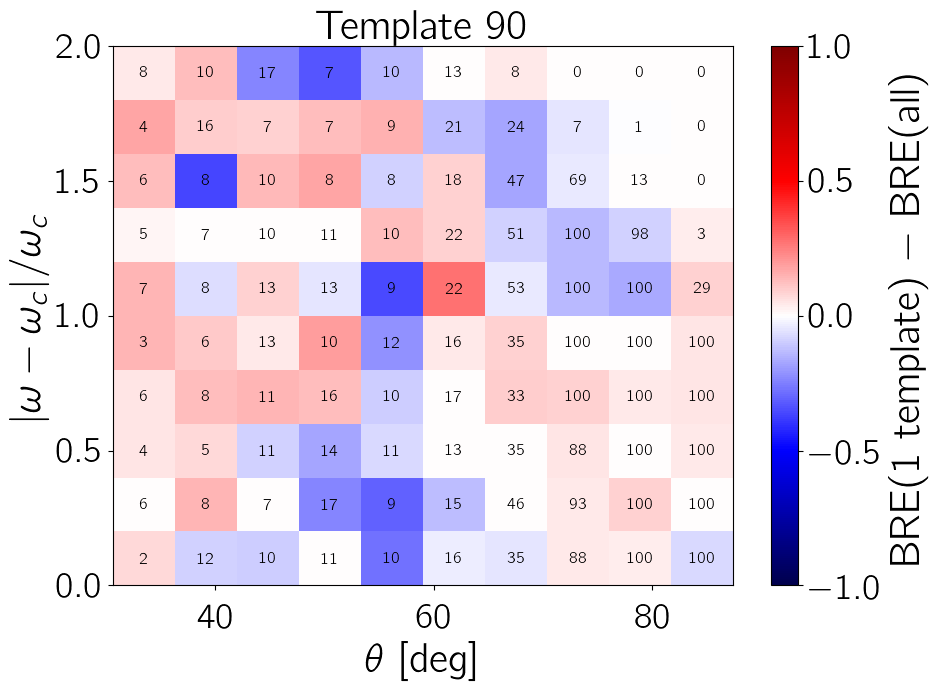

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.14216601353758465
-0.13123940149625937


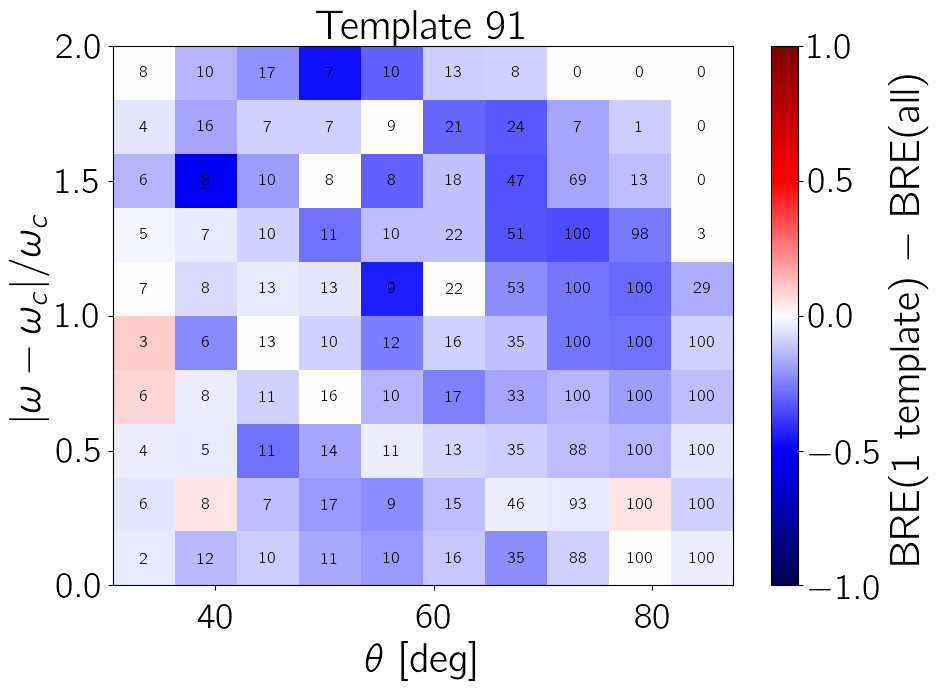

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.005614535090844321
-0.022408977556109724


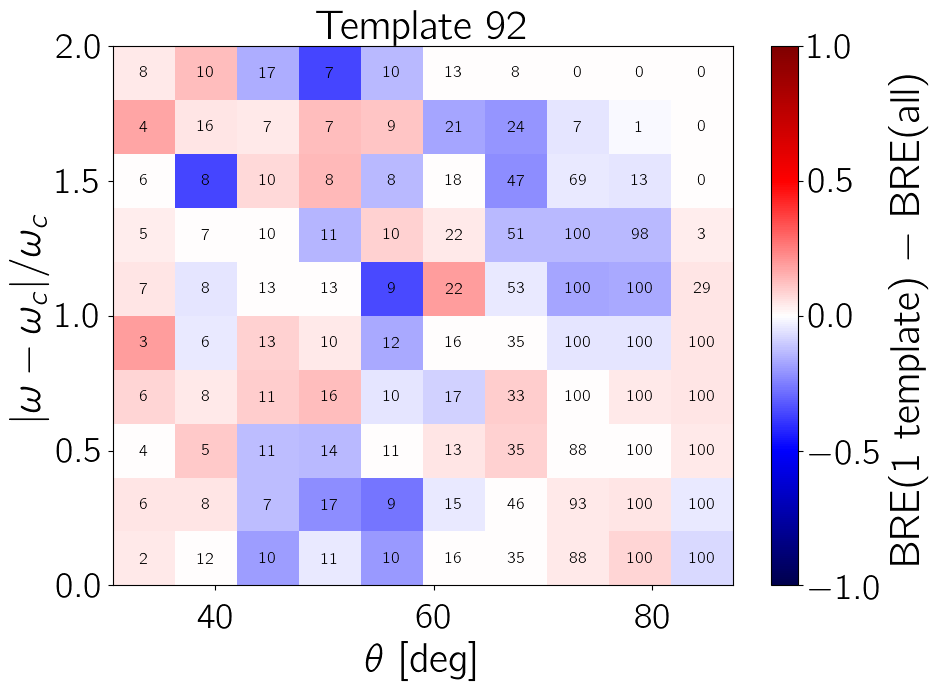

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


0.024075525472034193
-0.001770573566084792


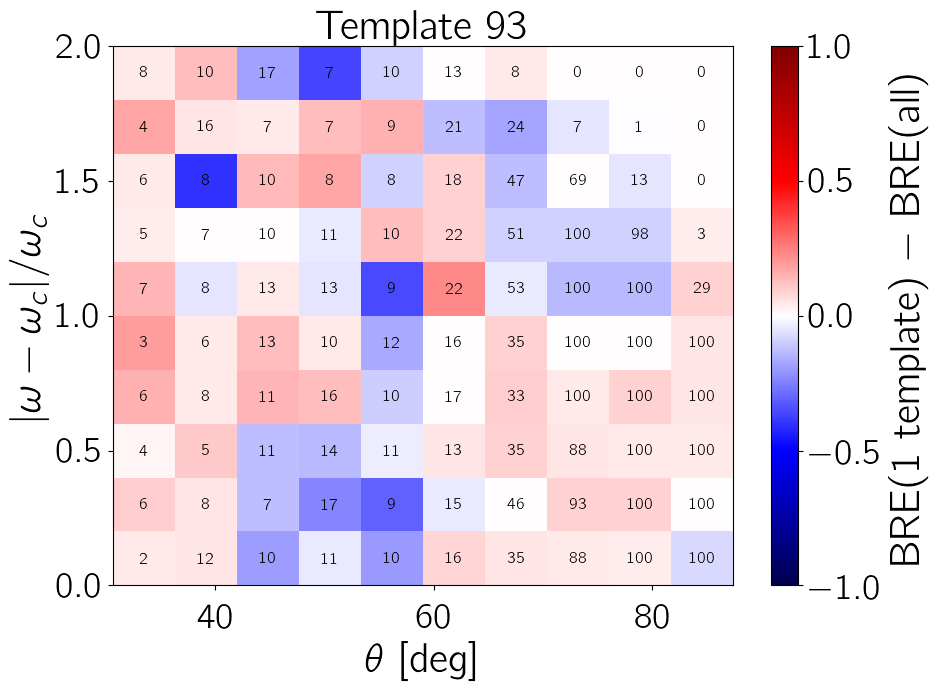

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.21211257570359818
-0.2402967581047382


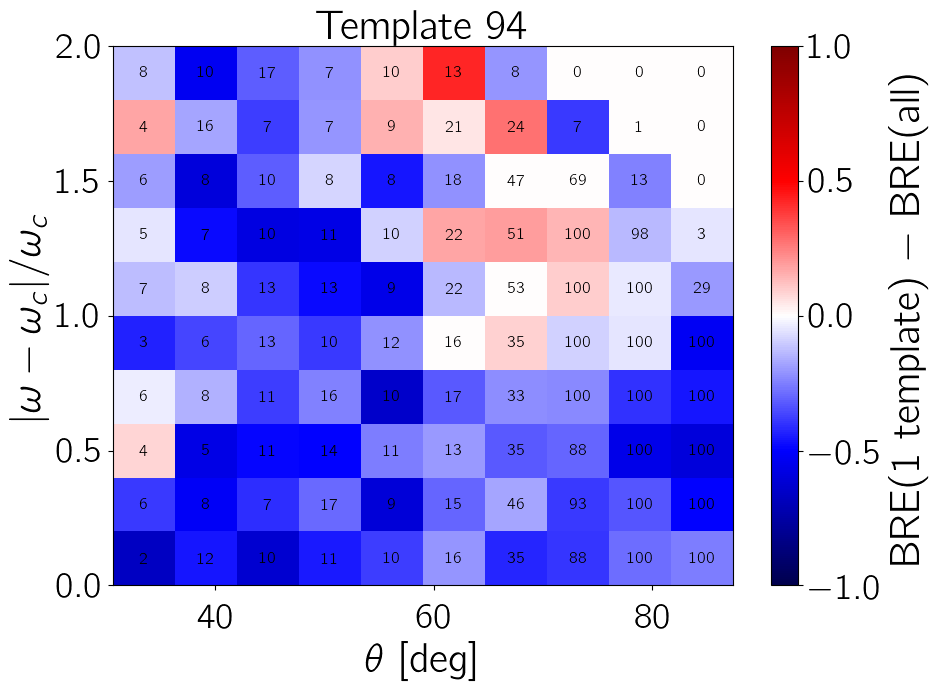

/pbs/home/p/pcorrea/grand/nutrig/flt/tools.py:130: RuntimeWarning: invalid value encountered in divide
  selection_eff /= len(ts_values)


-0.3787246170288564
-0.37356109725685793


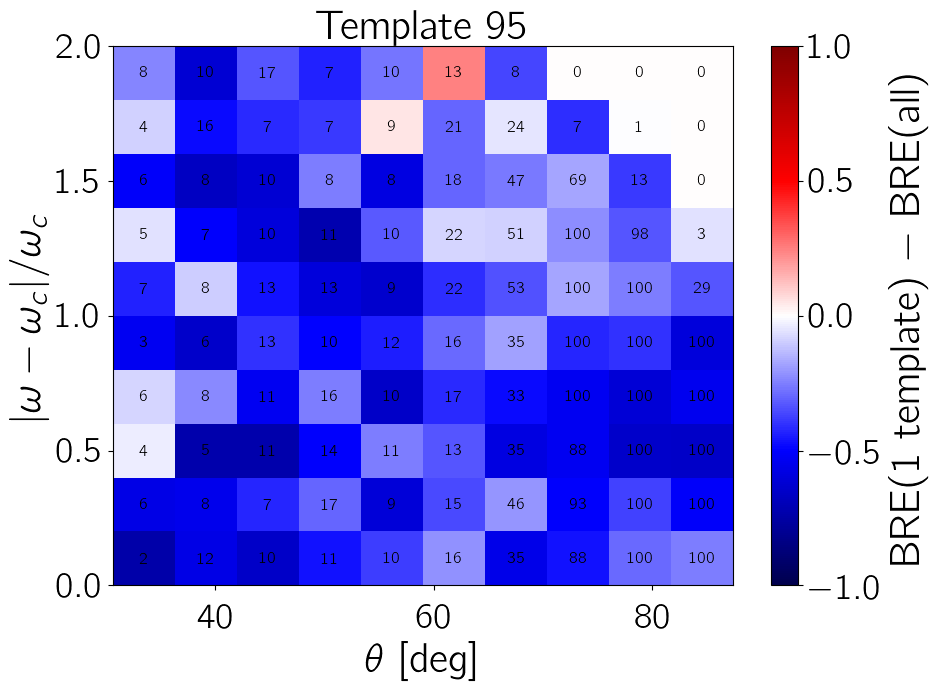

In [29]:
template_ids = np.arange(96)
corr_thresh  = np.arange(0,1,.01)

bkg_rej_eff_for_sig_sel_eff_90_best = np.zeros((n_bins_zenith,n_bins_omega))
template_id_best                    = -1*np.ones((n_bins_zenith,n_bins_omega))

for template_id in template_ids:
    param_str     = f'templates_random_{template_id}_1_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
    bias_res_file = f'/sps/grand/pcorrea/nutrig/template/results_bias/results_template_FLT_{pol}_sig_dataset_{dataset}_bins_{n_bins_zenith}x{n_bins_omega}_zenith_{range_zenith[0]}_{range_zenith[1]}_omega_diff_{range_omega[0]}_{range_omega[1]}_seed_300_{param_str}.npz'
    #bkg_res_file  = f'/sps/grand/pcorrea/nutrig/template/results_random/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'

    bias_results = tools.load_results(bias_res_file,n_pol)
    bkg_results  = tools.load_results(bkg_res_file,n_pol)

    bkg_sel_eff = tools.get_selection_efficiency(bkg_results['corr_max'],corr_thresh)
    bkg_rej_eff = 1 - bkg_sel_eff

    bkg_rej_eff_for_sig_sel_eff_90_single_temp = np.zeros((n_bins_zenith,n_bins_omega))

    for i in range(n_bins_zenith):
        for j in range(n_bins_omega):
            mask_bin = np.where(np.logical_and( np.logical_and( zenith>=bin_edges_zenith[i],zenith<bin_edges_zenith[i+1] ),
                                                np.logical_and( omega_diff>=bin_edges_omega[j],omega_diff<bin_edges_omega[j+1] ) ),
                                True,
                                False)
            sig_sel_eff = tools.get_selection_efficiency(bias_results['corr_max'][mask_bin],corr_thresh)
            thresh = np.where(sig_sel_eff<.9)[0]

            if np.any(thresh):
                bkg_rej_eff_for_sig_sel_eff_90_single_temp[i,j] = bkg_rej_eff[thresh[0]]

                if bkg_rej_eff[thresh[0]] > bkg_rej_eff_for_sig_sel_eff_90_best[i,j]:
                    bkg_rej_eff_for_sig_sel_eff_90_best[i,j] = bkg_rej_eff[thresh[0]]
                    template_id_best[i,j]                    = template_id

    diff = bkg_rej_eff_for_sig_sel_eff_90_single_temp-bkg_rej_eff_for_sig_sel_eff_90

    fig, ax = plt.subplots()
    ax.grid(False)

    hist    = ax.pcolormesh(zenith_grid,omega_grid,diff,cmap='seismic',vmin=-1,vmax=1)
    cbar    = plt.colorbar(hist,label='BRE(1 template) $-$ BRE(all)')# BRE ratio (1 template / all) for 90\% SSE

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')

    for i, bin_zenith in enumerate(bin_centers_zenith):
        for j, bin_omega in enumerate(bin_centers_omega):
            ax.text(bin_zenith,bin_omega,f'{sim_counts_per_bin[i,j]:.0f}',fontsize=12,va='center',ha='center')
    
    print(np.mean(diff[5:,:7]))
    print(np.mean(diff))
            
    title = f'Template {template_id}' #, SNR=4--8
    ax.set_title(title)

    plt.show()

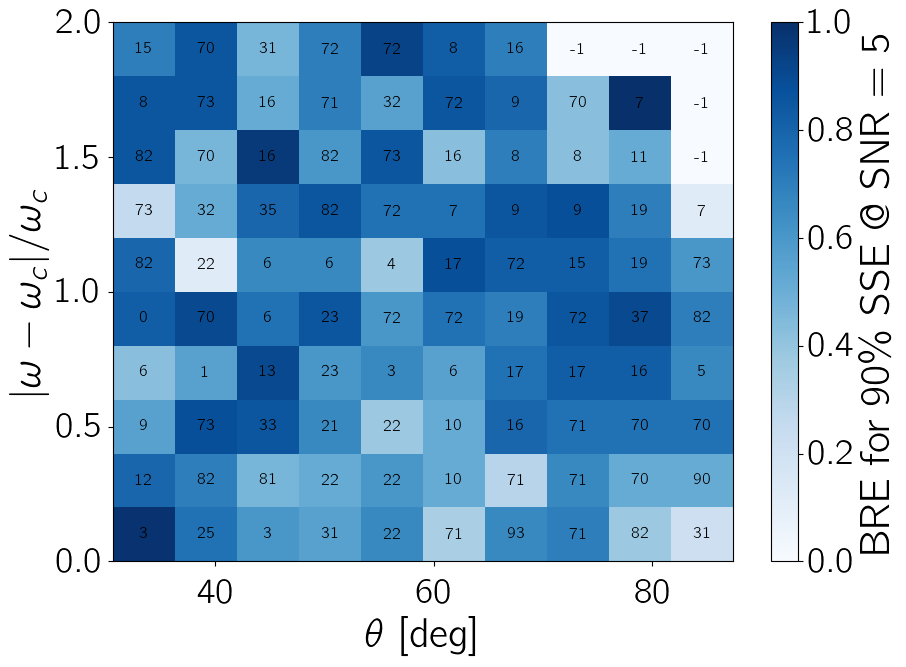

In [30]:
fig, ax = plt.subplots()
ax.grid(False)

hist = ax.pcolormesh(zenith_grid,omega_grid,bkg_rej_eff_for_sig_sel_eff_90_best,cmap='Blues',vmin=0,vmax=1)
cbar = plt.colorbar(hist,label='BRE for 90\% SSE @ SNR = 5')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')

for i, bin_zenith in enumerate(bin_centers_zenith):
    for j, bin_omega in enumerate(bin_centers_omega):
        ax.text(bin_zenith,bin_omega,f'{template_id_best[i,j]:.0f}',fontsize=12,va='center',ha='center')

plt.show()

## Make a template selection

Looking at the distributions above for each template - see **LINK TO PRESENTATION** for a more lkdj overview - we conclude:
- there seems to be no dependence on zenith (but not a lot of statistics at low zenith to know better);
- there is a tendency with templates to yield better results in their respective $\omega$ bins.

We therefore make a selection of 5 templates uniformly spread within the bins $|\omega - \omega_c|/\omega_c \in [[0.0,0.4],[0.4,0.8],[0.8,1.2],[1.2,1.6],[1.6,2.0]]$.

From visual inspection, we pick the following templates in each respective bin: $[89, 62, 74, 77, 79]$.

Here, we select those bins from the original template library and save them in a separate file.

In [2]:
pol = 'XY'
rf_chain = 'rfv2'
n_templates = 96
savefig = False

lib_path  = '/sps/grand/pcorrea/nutrig/template/lib/'
lib_name  = 'templates_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)
meta_name = 'metadata_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)

with np.load( os.path.join(lib_path,lib_name) ) as f:
    templates = f['templates']

try:
    template_ids = f['template_ids']
except:
    template_ids = np.arange(n_templates)

with np.load( os.path.join(lib_path,meta_name) ) as f:
    energy     = f['energy']
    zenith     = f['zenith']
    azimuth    = f['azimuth']
    omega      = f['omega']
    omega_c    = f['omega_c']
    omega_diff = f['omega_diff']
    vf         = f['vf']
    du_idx     = f['du_idx']

In [3]:
template_ids_output = np.array([9,17,82,31,25]) #np.array([16,73,82]) #np.array([62,74,77,79,89])
output_lib_name     = f'templates_{len(template_ids_output)}_{pol}_{rf_chain}.npz'
output_meta_name    = f'metadata_{len(template_ids_output)}_{pol}_{rf_chain}.npz'

In [6]:
np.savez(os.path.join(lib_path,output_lib_name),
         templates=templates[template_ids_output],
         template_ids=template_ids_output)

np.savez(os.path.join(lib_path,output_meta_name) ,
         energy     = energy[template_ids_output],
         zenith     = zenith[template_ids_output],
         azimuth    = azimuth[template_ids_output],
         omega      = omega[template_ids_output],
         omega_c    = omega_c[template_ids_output],
         omega_diff = omega_diff[template_ids_output],
         vf         = vf[template_ids_output],
         du_idx     = du_idx[template_ids_output])